In [197]:
"""
Módulo mejorado para evaluación de modelos de series temporales financieras.
Incluye clases y funciones para el análisis de rendimiento, evaluación de estrategias
y visualización de resultados.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Union
from darts import TimeSeries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
from darts.dataprocessing.transformers import Scaler
from scipy.stats import norm

# FUNCIONES UTILES

In [198]:
class DataPreprocessor:
    """Clase para el preprocesamiento de datos."""

    @staticmethod
    def to_pandas_series(
        data: Union[TimeSeries, np.ndarray, pd.Series],
        index: Optional[pd.DatetimeIndex] = None,
    ) -> pd.Series:
        """
        Convierte diferentes tipos de datos a pandas Series.

        Args:
            data: Datos a convertir
            index: Índice temporal opcional

        Returns:
            pandas.Series: Serie convertida
        """
        if isinstance(data, TimeSeries):
            return pd.Series(data.values().flatten(), index=data.time_index)
        elif isinstance(data, np.ndarray):
            if index is not None and len(data) == len(index):
                return pd.Series(data, index=index)
            return pd.Series(data)
        elif isinstance(data, pd.Series):
            if index is not None and not isinstance(data.index, pd.DatetimeIndex):
                data.index = index
            return data
        else:
            raise ValueError(f"Tipo de datos no soportado: {type(data)}")

In [199]:
class ForecastHandler:
    """
    Clase mejorada para manejar las predicciones de diferentes modelos,
    con corrección específica para el escalado.
    """

    def __init__(self, train_data: TimeSeries, test_data: TimeSeries):
        """
        Inicializa el manejador con los datos de entrenamiento y prueba.
        """
        self.scaler = Scaler()
        self.train_scaled = self.scaler.fit_transform(train_data)
        self.test_scaled = self.scaler.transform(test_data)
        self.test_index = test_data.time_index

        # Definir qué modelos necesitan desescalado y su tipo
        self.model_types = {
            # Modelos Darts que usan escalado
            "NBEATS": {"scaled": True, "type": "darts"},
            "NHITS": {"scaled": True, "type": "darts"},
            "AutoARIMA": {"scaled": True, "type": "darts"},
            "TSMixer": {"scaled": True, "type": "darts"},
            "TiDE": {"scaled": True, "type": "darts"},
            "Chronos": {"scaled": True, "type": "darts"},
            "Prophet": {"scaled": True, "type": "darts"},
            "MOIRAI": {"scaled": True, "type": "numpy"},
            # Modelos que no usan el escalador Darts
            "CatBoost": {"scaled": False, "type": "numpy"},
            "LSTM": {"scaled": False, "type": "numpy"},
            "TimesFM": {"scaled": False, "type": "numpy"},
        }

    def inverse_transform_data(
        self, data: Union[pd.Series, np.ndarray, list, TimeSeries], model_name: str
    ) -> pd.Series:
        """
        Desescala los datos según el tipo de modelo.
        Corregido para manejar correctamente el escalado de los modelos Darts.
        """
        try:
            if not self.model_types[model_name]["scaled"]:
                # Si el modelo no usa escalado, devolver directamente como serie
                if isinstance(data, TimeSeries):
                    return data.pd_series()
                elif isinstance(data, pd.Series):
                    return data
                else:
                    return pd.Series(data, index=self.test_index)

            # Para modelos que usan escalado
            if isinstance(data, TimeSeries):
                # Importante: asegurarse de que el escalado inverso se aplica correctamente
                return self.scaler.inverse_transform(data).pd_series()
            elif isinstance(data, pd.Series):
                # Convertir a TimeSeries de Darts primero
                darts_ts = TimeSeries.from_series(data)
                return self.scaler.inverse_transform(darts_ts).pd_series()
            else:
                # Para arrays o listas
                data_2d = self._ensure_2d_array(data)
                temp_ts = TimeSeries.from_values(data_2d)
                return self.scaler.inverse_transform(temp_ts).pd_series()

        except Exception as e:
            print(f"Error en inverse_transform_data para {model_name}: {str(e)}")
            if isinstance(data, pd.Series):
                return data
            return pd.Series(data, index=self.test_index)

    def _ensure_2d_array(self, data: Union[np.ndarray, list]) -> np.ndarray:
        """Asegura que los datos estén en formato 2D para el escalador."""
        data = np.array(data)
        if data.ndim == 1:
            return data.reshape(-1, 1)
        return data

    def load_forecasts(
        self, model_name: str
    ) -> Tuple[Optional[pd.Series], Optional[pd.Series]]:
        """Carga las predicciones del modelo desde archivos pickle."""
        try:
            # Cargar predicciones
            with open(f"{model_name.lower()}_forecast_no_retrain.pkl", "rb") as f:
                no_retrain = pickle.load(f)
            with open(f"{model_name.lower()}_forecast_retrain.pkl", "rb") as f:
                with_retrain = pickle.load(f)

            # Si el modelo usa escalado, aplicar inverse_transform
            if self.model_types[model_name]["scaled"]:
                if isinstance(no_retrain, TimeSeries):
                    no_retrain = self.inverse_transform_data(no_retrain, model_name)
                if isinstance(with_retrain, TimeSeries):
                    with_retrain = self.inverse_transform_data(with_retrain, model_name)
            else:
                # Para modelos sin escalado, convertir a Series si es necesario
                if isinstance(no_retrain, TimeSeries):
                    no_retrain = no_retrain.pd_series()
                elif isinstance(no_retrain, (np.ndarray, list)):
                    no_retrain = pd.Series(no_retrain, index=self.test_index)

                if isinstance(with_retrain, TimeSeries):
                    with_retrain = with_retrain.pd_series()
                elif isinstance(with_retrain, (np.ndarray, list)):
                    with_retrain = pd.Series(with_retrain, index=self.test_index)

            return no_retrain, with_retrain

        except Exception as e:
            print(f"Error cargando predicciones para {model_name}: {str(e)}")
            return None, None

    def process_all_models(
        self, model_list: list
    ) -> Dict[str, Tuple[pd.Series, pd.Series]]:
        """
        Procesa todos los modelos, manejando correctamente el escalado según el tipo.
        """
        processed_models = {}

        for model_name in model_list:
            print(f"\nProcesando modelo: {model_name}")
            no_retrain, with_retrain = self.load_forecasts(model_name)

            if no_retrain is not None and with_retrain is not None:
                try:
                    processed_models[model_name] = (no_retrain, with_retrain)
                    print(f"✓ {model_name}: Predicciones procesadas exitosamente")

                    # Verificación rápida de rangos
                    print(
                        f"  Rango de valores (sin reentrenamiento): [{no_retrain.min():.4f}, {no_retrain.max():.4f}]"
                    )
                    print(
                        f"  Rango de valores (con reentrenamiento): [{with_retrain.min():.4f}, {with_retrain.max():.4f}]"
                    )

                except Exception as e:
                    print(f"✗ Error procesando {model_name}: {str(e)}")
            else:
                print(f"✗ {model_name}: No se pudieron cargar las predicciones")

        return processed_models

In [200]:
class TradingMetrics:
    """Clase para el cálculo de métricas de trading."""

    @staticmethod
    def calculate_returns(series: Union[pd.Series, TimeSeries]) -> pd.Series:
        """
        Calcula retornos porcentuales.

        Args:
            series: Serie temporal (puede ser pandas Series o Darts TimeSeries)

        Returns:
            pd.Series con los retornos calculados
        """
        # Convertir TimeSeries a pandas Series si es necesario
        if isinstance(series, TimeSeries):
            series = series.pd_series()
        elif not isinstance(series, pd.Series):
            series = pd.Series(series)

        return series.pct_change().dropna()

    @staticmethod
    def calculate_cumulative_return(returns: pd.Series) -> pd.Series:
        """Calcula retornos acumulados."""
        return (1 + returns).cumprod() - 1

    @staticmethod
    # def implement_trading_strategy(real_returns: pd.Series, predicted_returns: pd.Series) -> pd.Series:
    #     """Implementa estrategia de trading basada en predicciones."""
    #     position = pd.Series(np.where(predicted_returns > 0, 1, -1),
    #                        index=predicted_returns.index)
    #     strategy_returns = real_returns * position
    #     return strategy_returns

    def implement_trading_strategy_adaptive(
        real_returns: pd.Series, predicted_returns: pd.Series, lookback: int = 12
    ) -> pd.Series:
        """
        Ajusta los thresholds según la volatilidad reciente del PEN.
        """
        position = pd.Series(0, index=predicted_returns.index)

        # Calcular volatilidad rolling
        rolling_std = real_returns.rolling(lookback).std()

        # Threshold base
        base_threshold = 0.0075  # 0.75%

        # Ajustar threshold según volatilidad
        dynamic_threshold = base_threshold * (rolling_std / rolling_std.mean())

        # Tomar posiciones con threshold dinámico
        for i in range(len(predicted_returns)):
            if predicted_returns.iloc[i] > dynamic_threshold.iloc[i]:
                position.iloc[i] = 1
            elif predicted_returns.iloc[i] < -dynamic_threshold.iloc[i]:
                position.iloc[i] = -1

        return real_returns * position

    @staticmethod
    def calculate_performance_metrics(
        pred_returns: pd.Series, benchmark_returns: Optional[pd.Series] = None
    ) -> Dict:
        """
        Calcula métricas de rendimiento exactamente como la implementación original.
        """
        # Asegurar que los inputs sean pandas.Series
        if not isinstance(pred_returns, pd.Series):
            pred_returns = pd.Series(pred_returns)

        # Crear benchmark de ceros si no se proporciona
        if benchmark_returns is None:
            benchmark_returns = pd.Series(
                [0] * len(pred_returns), index=pred_returns.index
            )
        elif not isinstance(benchmark_returns, pd.Series):
            benchmark_returns = pd.Series(benchmark_returns)

        # Retornos totales y anualizados
        total_return = (1 + pred_returns).prod() - 1
        annualized_return = (1 + total_return) ** (12 / len(pred_returns)) - 1

        # Sharpe Ratio (sin tasa libre de riesgo)
        sharpe_ratio = np.sqrt(12) * pred_returns.mean() / pred_returns.std()

        # Exceso de retornos para Information Ratio
        excess_returns = pred_returns - benchmark_returns
        tracking_error = excess_returns.std()
        information_ratio = excess_returns.mean() / tracking_error

        # Máximo Drawdown
        cumulative_returns = (1 + pred_returns).cumprod()
        peak = cumulative_returns.cummax()
        max_drawdown = ((cumulative_returns / peak) - 1).min()

        return {
            "Total Return": total_return,
            "Annualized Return": annualized_return,
            "Sharpe Ratio": sharpe_ratio,
            "Information Ratio": information_ratio,
            "Max Drawdown": max_drawdown,
        }

In [201]:
def generate_strategies_panel(
    all_returns_with_retrain: dict,
    real_returns: pd.Series,
    model_list: list,
    start_date=None,
    periods=None,
) -> pd.DataFrame:
    """
    Genera un DataFrame con las estrategias de trading de todos los modelos.

    Args:
        all_returns_with_retrain: Diccionario con los retornos de cada modelo
        real_returns: Serie de retornos reales
        model_list: Lista de nombres de modelos
        start_date: Fecha de inicio para el análisis (str o datetime)
        periods: Número de períodos a considerar

    Returns:
        DataFrame con las estrategias de todos los modelos
    """
    strategies_df = pd.DataFrame(index=real_returns.index)

    for model_name in model_list:
        try:
            if model_name in all_returns_with_retrain:
                pred_returns = all_returns_with_retrain[model_name]

                # Implementar estrategia
                strategy = TradingMetrics.implement_trading_strategy_adaptive(
                    real_returns=real_returns, predicted_returns=pred_returns
                )

                strategies_df[f"{model_name}_strategy"] = strategy

        except Exception as e:
            print(f"Error procesando estrategia para {model_name}: {str(e)}")

    # Filtrar por fecha y períodos si se especifican
    if start_date is not None:
        if isinstance(start_date, str):
            start_date = pd.to_datetime(start_date)
        strategies_df = strategies_df[strategies_df.index >= start_date]

        if periods is not None:
            strategies_df = strategies_df.iloc[:periods]

    return strategies_df

In [202]:
def generate_cumulative_returns_panel(
    strategies_df: pd.DataFrame, start_date=None, periods=None
) -> pd.DataFrame:
    """
    Genera un DataFrame con los retornos acumulados de todas las estrategias.

    Args:
        strategies_df: DataFrame con las estrategias de trading
        start_date: Fecha de inicio para el análisis (str o datetime)
        periods: Número de períodos a considerar

    Returns:
        DataFrame con los retornos acumulados
    """
    cumulative_df = pd.DataFrame(index=strategies_df.index)

    for column in strategies_df.columns:
        strategy_returns = strategies_df[column]

        # Calcular retornos acumulados
        cum_returns = TradingMetrics.calculate_cumulative_return(strategy_returns)
        cumulative_df[f"{column}_cumulative"] = cum_returns

    # Filtrar por fecha y períodos si se especifican
    if start_date is not None:
        if isinstance(start_date, str):
            start_date = pd.to_datetime(start_date)
        cumulative_df = cumulative_df[cumulative_df.index >= start_date]

        if periods is not None:
            cumulative_df = cumulative_df.iloc[:periods]

    return cumulative_df

In [203]:
# Función para visualizar retornos acumulados por período
def plot_cumulative_returns_by_period(
    cumulative_df: pd.DataFrame, period: str, title: str = None
):
    """
    Visualiza los retornos acumulados para un período específico.

    Args:
        cumulative_df: DataFrame con retornos acumulados
        period: Año o período a visualizar (e.g., '2019', '2020')
        title: Título opcional para el gráfico
    """
    plt.figure(figsize=(15, 8))

    # Filtrar datos para el período
    period_data = cumulative_df[cumulative_df.index.strftime("%Y") == period]

    # Resetear los retornos para que empiecen desde 0
    for column in period_data.columns:
        first_value = period_data[column].iloc[0]
        period_data[column] = (1 + period_data[column]) / (1 + first_value) - 1

    # Graficar
    for column in period_data.columns:
        plt.plot(
            period_data.index,
            period_data[column],
            label=column.replace("_cumulative", ""),
        )

    plt.title(title or f"Retornos Acumulados - {period}")
    plt.xlabel("Fecha")
    plt.ylabel("Retorno Acumulado")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [204]:
class ModelEvaluator:
    """Clase para evaluación de modelos con verificación estricta."""

    @staticmethod
    def _prepare_data(data: Union[np.ndarray, pd.Series, TimeSeries]) -> np.ndarray:
        """
        Prepara los datos para evaluación, asegurando que sean numpy arrays 1D.
        """
        if isinstance(data, TimeSeries):
            return data.values().flatten()
        elif isinstance(data, pd.Series):
            return data.values
        elif isinstance(data, np.ndarray):
            return data.flatten()
        else:
            return np.array(data).flatten()

    def evaluate_predictions(
        self,
        y_true: Union[np.ndarray, pd.Series, TimeSeries],
        y_pred: Union[np.ndarray, pd.Series, TimeSeries],
        verbose: bool = True,
    ) -> Dict:
        """
        Calcula métricas de error de predicción.
        """
        # Preparar datos
        y_true_clean = self._prepare_data(y_true)
        y_pred_clean = self._prepare_data(y_pred)

        # Verificar dimensiones
        if len(y_true_clean) != len(y_pred_clean):
            raise ValueError(
                f"Length mismatch: y_true ({len(y_true_clean)}) != y_pred ({len(y_pred_clean)})"
            )

        # Verificar NaN
        if np.any(np.isnan(y_true_clean)) or np.any(np.isnan(y_pred_clean)):
            raise ValueError("Data contains NaN values")

        # Calcular métricas
        metrics = {
            "MSE": mean_squared_error(y_true_clean, y_pred_clean),
            "RMSE": np.sqrt(mean_squared_error(y_true_clean, y_pred_clean)),
            "MAE": mean_absolute_error(y_true_clean, y_pred_clean),
            "R2": r2_score(y_true_clean, y_pred_clean),
        }

        if verbose:
            print("\nMétricas calculadas:")
            for metric, value in metrics.items():
                print(f"{metric}: {value:.4f}")

        return metrics

    def calculate_hit_ratio(
        self,
        y_pred: Union[np.ndarray, pd.Series, TimeSeries],
        y_true: Union[np.ndarray, pd.Series, TimeSeries],
        verbose: bool = True,
    ) -> Tuple[float, str]:
        """
        Calcula el hit ratio basado en la dirección de los cambios.
        """
        # Preparar datos
        y_true_clean = self._prepare_data(y_true)
        y_pred_clean = self._prepare_data(y_pred)

        # Verificar dimensiones
        if len(y_true_clean) != len(y_pred_clean):
            raise ValueError(
                f"Length mismatch: y_true ({len(y_true_clean)}) != y_pred ({len(y_pred_clean)})"
            )

        # Verificar NaN
        if np.any(np.isnan(y_true_clean)) or np.any(np.isnan(y_pred_clean)):
            raise ValueError("Data contains NaN values")

        # Calcular variaciones
        y_true_returns = np.diff(y_true_clean)
        y_pred_returns = np.diff(y_pred_clean)

        # Calcular hit ratio basado en la dirección de los cambios
        same_direction_count = np.sum(
            np.sign(y_pred_returns) == np.sign(y_true_returns)
        )
        hit_ratio = same_direction_count / len(y_true_returns) * 100
        hit_ratio_string = f"Hit Ratio = {hit_ratio:.2f}%"

        if verbose:
            print(f"\n{hit_ratio_string}")
            print(f"Total points: {len(y_true_returns)}")
            print(f"Correct directions: {same_direction_count}")
            print(f"Accuracy: {same_direction_count / len(y_true_returns):.4f}")

        return hit_ratio, hit_ratio_string

In [205]:
def visualize_model_comparison(results_df):
    """
    Crea visualizaciones comparativas de los resultados de los modelos.
    """
    # Configuración de estilo
    plt.style.use("seaborn")

    # 1. Gráfico de barras para R2 y Hit Ratio
    plt.figure(figsize=(15, 6))

    x = np.arange(len(results_df))
    width = 0.35

    plt.bar(x - width / 2, results_df["R2"], width, label="R²", color="skyblue")
    plt.bar(
        x + width / 2,
        results_df["Hit Ratio"] / 100,
        width,
        label="Hit Ratio",
        color="lightgreen",
    )

    plt.xlabel("Modelos")
    plt.ylabel("Score")
    plt.title("Comparación de R² y Hit Ratio por Modelo")
    plt.xticks(x, results_df["Model"], rotation=45, ha="right")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2. Gráfico de barras para métricas de error
    plt.figure(figsize=(15, 6))

    bar_width = 0.25
    r1 = np.arange(len(results_df))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    plt.bar(r1, results_df["MSE"], width=bar_width, label="MSE", color="salmon")
    plt.bar(r2, results_df["RMSE"], width=bar_width, label="RMSE", color="lightblue")
    plt.bar(r3, results_df["MAE"], width=bar_width, label="MAE", color="lightgreen")

    plt.xlabel("Modelos")
    plt.ylabel("Error")
    plt.title("Comparación de Métricas de Error por Modelo")
    plt.xticks(
        [r + bar_width for r in range(len(results_df))],
        results_df["Model"],
        rotation=45,
        ha="right",
    )
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 3. Tabla de resumen
    summary_df = results_df.copy()
    summary_df["Hit Ratio"] = summary_df["Hit Ratio"].apply(lambda x: f"{x:.2f}%")
    for col in ["MSE", "RMSE", "MAE", "R2"]:
        summary_df[col] = summary_df[col].apply(lambda x: f"{x:.4f}")

    print("\nResumen de Resultados:")
    print(summary_df.to_string(index=False))

    # 4. Identificar mejores modelos
    best_r2 = results_df.loc[results_df["R2"].idxmax()]
    best_hit_ratio = results_df.loc[results_df["Hit Ratio"].idxmax()]
    lowest_rmse = results_df.loc[results_df["RMSE"].idxmin()]

    print("\nMejores Modelos:")
    print(f"Mejor R²: {best_r2['Model']} (R² = {best_r2['R2']:.4f})")
    print(
        f"Mejor Hit Ratio: {best_hit_ratio['Model']} (Hit Ratio = {best_hit_ratio['Hit Ratio']:.2f}%)"
    )
    print(f"Menor RMSE: {lowest_rmse['Model']} (RMSE = {lowest_rmse['RMSE']:.4f})")

In [206]:
def compare_model_predictions(
    model_name: str, y_true, y_pred, evaluator: ModelEvaluator
):
    """
    Función helper para comparar predicciones de un modelo.
    """
    print(f"\nEvaluando modelo: {model_name}")

    # Calcular métricas
    metrics = evaluator.evaluate_predictions(y_true, y_pred)
    hit_ratio, hit_ratio_string = evaluator.calculate_hit_ratio(y_pred, y_true)

    # Combinar resultados
    results = {"Model": model_name, **metrics, "Hit Ratio": hit_ratio}

    return results

In [207]:
class StrategyVisualizer:
    """Clase para visualizar estrategias de trading con estilo personalizado."""

    def __init__(self):
        """Inicializa el estilo del gráfico."""
        plt.style.use("seaborn")
        # Definir paleta de colores para múltiples modelos
        self.model_colors = [
            "#1f77b4",
            "#ff7f0e",
            "#2ca02c",
            "#d62728",
            "#9467bd",
            "#8c564b",
            "#e377c2",
            "#7f7f7f",
            "#bcbd22",
            "#17becf",
        ]

        self.colors = {"buy_hold": "black", "with_retrain": "magenta"}
        self.line_styles = {"buy_hold": "-", "with_retrain": "-"}
        self.alpha = {"buy_hold": 1.0, "with_retrain": 0.8}

    def plot_all_models_comparison(
        self,
        real_returns: pd.Series,
        all_returns_with_retrain: dict,
        figsize: tuple = (15, 8),
        grid: bool = True,
    ) -> None:
        """
        Visualiza todos los modelos contra el retorno real en una sola gráfica.
        """
        # Calcular retorno acumulado real
        cumulative_real = (1 + real_returns).cumprod() - 1

        # Crear figura
        plt.figure(figsize=figsize)

        # Plotear Buy & Hold
        plt.plot(
            cumulative_real.index,
            cumulative_real,
            label="Buy and Hold",
            color=self.colors["buy_hold"],
            linestyle=self.line_styles["buy_hold"],
            linewidth=2,
            alpha=self.alpha["buy_hold"],
        )

        # Plotear cada modelo
        for i, (model_name, returns) in enumerate(all_returns_with_retrain.items()):
            cumulative_returns = (1 + returns).cumprod() - 1
            plt.plot(
                cumulative_returns.index,
                cumulative_returns,
                label=f"{model_name}",
                color=self.model_colors[i % len(self.model_colors)],
                alpha=0.7,
            )

        # Configurar gráfico
        plt.title("Comparación de Todos los Modelos vs Buy and Hold")
        plt.xlabel("Fecha")
        plt.ylabel("Retorno Acumulado")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

        if grid:
            plt.grid(True, alpha=0.3)

        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Imprimir métricas comparativas
        self._print_comparative_metrics(real_returns, all_returns_with_retrain)

    def plot_strategy_returns_comparison(
        self,
        real_returns: pd.Series,
        all_returns_with_retrain: dict,
        figsize: tuple = (15, 8),
        grid: bool = True,
    ) -> None:
        """
        Visualiza la diferencia entre los retornos de las estrategias y el retorno real.
        """
        plt.figure(figsize=figsize)

        # Plotear diferencias de retornos para cada modelo
        for i, (model_name, returns) in enumerate(all_returns_with_retrain.items()):
            # Calcular diferencia de retornos
            excess_returns = returns - real_returns
            plt.plot(
                excess_returns.index,
                excess_returns.cumsum(),
                label=f"{model_name}",
                color=self.model_colors[i % len(self.model_colors)],
                alpha=0.7,
            )

        # Configurar gráfico
        plt.title("Retornos Acumulados en Exceso sobre Buy and Hold")
        plt.xlabel("Fecha")
        plt.ylabel("Retorno en Exceso Acumulado")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

        if grid:
            plt.grid(True, alpha=0.3)

        # Añadir línea horizontal en cero
        plt.axhline(y=0, color="black", linestyle="--", alpha=0.5)

        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def _print_comparative_metrics(
        self, real_returns: pd.Series, all_returns_with_retrain: dict
    ) -> None:
        """
        Imprime métricas comparativas de todos los modelos.
        """
        print("\nMétricas Comparativas:")
        print("-" * 100)
        print(
            f"{'Modelo':<15} {'Total Return':>12} {'Sharpe Ratio':>12} {'Information Ratio':>15} {'Max Drawdown':>12}"
        )
        print("-" * 100)

        for model_name, returns in all_returns_with_retrain.items():
            metrics = TradingMetrics.calculate_performance_metrics(
                returns, real_returns
            )

            print(
                f"{model_name:<15} {metrics['Total Return']:>12.4f} {metrics['Sharpe Ratio']:>12.4f} "
                f"{metrics['Information Ratio']:>15.4f} {metrics['Max Drawdown']:>12.4f}"
            )

    def plot_strategy_comparison(
        self,
        real_returns: pd.Series,
        strategy_returns_with_retrain: pd.Series,
        model_name: str,
        figsize: tuple = (12, 6),
        grid: bool = True,
        strategy_returns_no_retrain: pd.Series = None,
    ) -> None:
        """
        Visualiza la comparación entre Buy & Hold y estrategia de trading con reentrenamiento.

        Args:
            real_returns: Serie de retornos reales (Buy & Hold)
            strategy_returns_with_retrain: Serie de retornos de estrategia con reentrenamiento
            model_name: Nombre del modelo para el título
            figsize: Tamaño de la figura
            grid: Si se muestra la grilla
            strategy_returns_no_retrain: Ignorado, mantenido para compatibilidad
        """
        # Calcular retornos acumulados
        cumulative_real = (1 + real_returns).cumprod() - 1
        cumulative_strategy = (1 + strategy_returns_with_retrain).cumprod() - 1

        # Crear figura
        plt.figure(figsize=figsize)

        # Plotear estrategias
        plt.plot(
            cumulative_real.index,
            cumulative_real,
            label="Buy and Hold",
            color=self.colors["buy_hold"],
            linestyle=self.line_styles["buy_hold"],
            alpha=self.alpha["buy_hold"],
        )

        plt.plot(
            cumulative_strategy.index,
            cumulative_strategy,
            label=f"{model_name} Con Reentrenamiento",
            color=self.colors["with_retrain"],
            linestyle=self.line_styles["with_retrain"],
            alpha=self.alpha["with_retrain"],
        )

        # Configurar gráfico
        plt.title(f"{model_name}: Estrategia vs Buy and Hold")
        plt.xlabel("Fecha")
        plt.ylabel("Retorno Acumulado")
        plt.legend()

        if grid:
            plt.grid(True, alpha=0.3)

        # Rotar etiquetas del eje x
        plt.xticks(rotation=45)

        # Ajustar espaciado
        plt.tight_layout()

        # Mostrar gráfico
        plt.show()

        # Imprimir métricas
        self._print_strategy_metrics(
            real_returns, strategy_returns_with_retrain, model_name
        )

    def _print_strategy_metrics(
        self, real_returns: pd.Series, strategy_returns: pd.Series, model_name: str
    ) -> None:
        """Imprime métricas clave de la estrategia."""
        metrics = TradingMetrics.calculate_performance_metrics(
            strategy_returns, real_returns
        )
        # hit_ratio, _ = ModelEvaluator.calculate_hit_ratio(strategy_returns, real_returns)

        print(f"\nMétricas para {model_name} con reentrenamiento:")
        for k, v in metrics.items():
            print(f"{k}: {v:.4f}")
        # print(f"Hit Ratio: {hit_ratio:.4f}")

    def set_style(
        self, colors: dict = None, line_styles: dict = None, alpha: dict = None
    ) -> None:
        """Personaliza el estilo del gráfico."""
        if colors:
            self.colors.update(colors)
        if line_styles:
            self.line_styles.update(line_styles)
        if alpha:
            self.alpha.update(alpha)

In [208]:
class RollingAnalyzer:
    """Clase para análisis rolling de métricas de consistencia de una estrategia."""

    @staticmethod
    def calculate_strategy_consistency(
        real_returns: pd.Series,
        predicted_returns: pd.Series,
        strategy_returns: pd.Series,
        window: int = 12,
    ) -> pd.DataFrame:
        """
        Calcula métricas rolling para evaluar la consistencia de una estrategia de trading.

        Args:
            real_returns: Serie de retornos reales (benchmark).
            predicted_returns: Serie de retornos predichos por el modelo.
            strategy_returns: Serie de retornos obtenidos al aplicar la estrategia.
            window: Tamaño de la ventana rolling.

        Returns:
            DataFrame con métricas rolling.
        """
        metrics_df = pd.DataFrame(index=real_returns.index)

        # Rolling Information Ratio (Excess return vs benchmark)
        excess_returns = strategy_returns - real_returns
        metrics_df["Information_Ratio"] = (
            excess_returns.rolling(window=window).mean()
            / excess_returns.rolling(window=window).std()
        )

        # Rolling Excess Return (Anualizado)
        metrics_df["Excess_Return"] = excess_returns.rolling(window=window).mean() * 12

        # Rolling Hit Ratio (Predicciones acertadas en dirección)
        metrics_df["Hit_Ratio"] = (
            np.sign(real_returns)
            .rolling(window=window)
            .apply(
                lambda x: (x == np.sign(predicted_returns.loc[x.index])).mean() * 100
            )
        )

        # Rolling Sharpe Ratio (Estrategia)
        metrics_df["Sharpe_Ratio"] = (
            strategy_returns.rolling(window=window).mean()
            / strategy_returns.rolling(window=window).std()
            * np.sqrt(12)
        )

        # Rolling Volatility (Estrategia)
        metrics_df["Volatility"] = strategy_returns.rolling(
            window=window
        ).std() * np.sqrt(12)

        # Rolling Max Drawdown (Estrategia)
        def rolling_max_drawdown(x):
            cum_rets = (1 + x).cumprod()
            rolling_max = cum_rets.expanding().max()
            drawdowns = cum_rets / rolling_max - 1
            return drawdowns.min()

        metrics_df["Max_Drawdown"] = strategy_returns.rolling(window=window).apply(
            rolling_max_drawdown
        )

        return metrics_df

In [209]:
def analyze_rolling_statistics(
    rolling_metrics: pd.DataFrame, confidence_level: float = 0.95
):
    """
    Analiza la consistencia estadística de métricas rolling.

    Args:
        rolling_metrics: DataFrame con métricas rolling.
        confidence_level: Nivel de confianza para los intervalos.

    Returns:
        summary_table: DataFrame con estadísticos descriptivos.
    """
    # 1. Crear tabla de resumen
    summary_table = rolling_metrics.describe().T
    summary_table["median"] = rolling_metrics.median()

    # Calcular Intervalos de Confianza
    z_score = norm.ppf((1 + confidence_level) / 2)  # Valor crítico z
    for col in rolling_metrics.columns:
        mean = rolling_metrics[col].mean()
        std = rolling_metrics[col].std()
        n = rolling_metrics[col].count()
        ci_margin = z_score * (std / np.sqrt(n))
        summary_table.loc[col, "CI_lower"] = mean - ci_margin
        summary_table.loc[col, "CI_upper"] = mean + ci_margin

    # 2. Visualizar Histogramas
    for col in rolling_metrics.columns:
        plt.figure(figsize=(8, 6))
        plt.hist(rolling_metrics[col].dropna(), bins=30, edgecolor="k", alpha=0.7)
        plt.title(f"Histograma de {col}")
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.grid(True)
        plt.show()

    # # 3. Crear boxplots comparativos por métrica
    # metrics = ['Excess_Return', 'Information_Ratio', 'Hit_Ratio', 'Sharpe_Ratio', 'Volatility', 'Max_Drawdown']

    # for metric in metrics:
    #     plt.figure(figsize=(12, 8))

    #     # Crear DataFrame para el boxplot con todos los modelos
    #     models_data = pd.DataFrame()
    #     for model_name, returns in all_returns_with_retrain.items():
    #         if metric in rolling_metrics.columns:
    #             models_data[model_name] = rolling_metrics[metric]

    #     # Crear boxplot
    #     sns.boxplot(data=models_data, orient='h')

    #     # Configurar el gráfico
    #     plt.title(f'Comparación de {metric} entre Modelos')
    #     plt.xlabel(metric)
    #     plt.ylabel('Modelos')

    #     # Añadir línea vertical en cero si es relevante
    #     if metric not in ['Volatility']:
    #         plt.axvline(x=0, color='r', linestyle='--', alpha=0.3)

    #     plt.grid(True, alpha=0.3)
    #     plt.tight_layout()
    #     plt.show()

    return summary_table

In [210]:
class PerformanceVisualizer:
    """Clase para visualización de rendimiento."""

    @staticmethod
    def plot_cumulative_returns(
        returns_dict: Dict[str, pd.Series],
        benchmark_returns: pd.Series,
        title: str = "Retornos Acumulados",
    ) -> None:
        """Visualiza retornos acumulados de múltiples modelos vs benchmark."""
        plt.figure(figsize=(12, 6))

        # Calcular y graficar benchmark
        cum_benchmark = TradingMetrics.calculate_cumulative_return(benchmark_returns)
        plt.plot(
            cum_benchmark.index, cum_benchmark, "k--", label="Benchmark", linewidth=2
        )

        # Calcular y graficar retornos de modelos
        for model_name, returns in returns_dict.items():
            cum_returns = TradingMetrics.calculate_cumulative_return(returns)
            plt.plot(cum_returns.index, cum_returns, label=model_name)

        plt.title(title)
        plt.xlabel("Fecha")
        plt.ylabel("Retorno Acumulado")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_rolling_metrics(
        metrics_df: pd.DataFrame, model_name: str, window: int = 12
    ) -> None:
        """Visualiza métricas rolling."""
        metrics = metrics_df.columns
        n_metrics = len(metrics)

        fig, axes = plt.subplots(n_metrics, 1, figsize=(12, 4 * n_metrics))

        for ax, metric in zip(axes, metrics):
            metrics_df[metric].plot(ax=ax)
            ax.set_title(f"{metric} Rolling {window}-meses - {model_name}")
            ax.grid(True)
            ax.axhline(y=0, color="r", linestyle="--", alpha=0.3)

            # Añadir estadísticas
            mean_val = metrics_df[metric].mean()
            std_val = metrics_df[metric].std()
            ax.text(
                0.02,
                0.95,
                f"Media: {mean_val:.4f}\nStd: {std_val:.4f}",
                transform=ax.transAxes,
                bbox=dict(facecolor="white", alpha=0.8),
            )

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_metrics_heatmap(metrics_df: pd.DataFrame) -> None:
        """Crea un heatmap comparativo de métricas."""
        plt.figure(figsize=(10, 8))
        sns.heatmap(metrics_df, annot=True, cmap="RdYlGn", center=0)
        plt.title("Comparación de Métricas por Modelo")
        plt.tight_layout()
        plt.show()

In [211]:
def create_model_evaluator(model_list: List[str]) -> Dict:
    """
    Función factory para crear el evaluador de modelos.

    Args:
        model_list: Lista de nombres de modelos a evaluar

    Returns:
        dict: Diccionario con instancias de las clases necesarias
    """
    return {
        "preprocessor": DataPreprocessor(),
        "metrics": TradingMetrics(),
        "evaluator": ModelEvaluator(),
        "rolling": RollingAnalyzer(),
        "visualizer": PerformanceVisualizer(),
        "models": model_list,
    }

In [212]:
def evaluate_and_store_results(
    model_name,
    y_true,
    y_pred_no_retrain,
    y_pred_with_retrain,
    all_metrics,
    all_returns_no_retrain,
    all_returns_with_retrain,
    evaluator,
):
    """
    Evalúa y almacena los resultados para ambas versiones del modelo.
    """
    try:
        # Convertir a TimeSeries si no lo es ya
        if not isinstance(y_true, TimeSeries):
            y_true = TimeSeries.from_values(y_true)

            # Asegurarse de que y_pred tenga la misma longitud que y_true
        y_pred_no_retrain = y_pred_no_retrain[: len(y_true)]
        y_pred_with_retrain = y_pred_with_retrain[: len(y_true)]

        # Evaluación sin reentrenamiento
        metrics_no_retrain = evaluator.evaluate_predictions(
            y_true=y_true, y_pred=y_pred_no_retrain
        )
        hit_ratio_no_retrain, _ = evaluator.calculate_hit_ratio(
            y_pred=y_pred_no_retrain, y_true=y_true
        )

        # Calcular retornos para la versión sin reentrenamiento
        y_true_series = y_true.pd_series()
        y_pred_no_retrain_series = (
            y_pred_no_retrain.pd_series()
            if hasattr(y_pred_no_retrain, "pd_series")
            else pd.Series(y_pred_no_retrain, index=y_true_series.index)
        )

        returns_no_retrain = TradingMetrics.calculate_returns(y_pred_no_retrain_series)
        all_returns_no_retrain[model_name] = returns_no_retrain

        metrics_dict_no_retrain = {
            "Model": model_name,
            "Retrain": False,
            "Hit Ratio": hit_ratio_no_retrain,
            **metrics_no_retrain,
        }
        all_metrics.append(metrics_dict_no_retrain)

        # Evaluación con reentrenamiento
        metrics_with_retrain = evaluator.evaluate_predictions(
            y_true=y_true, y_pred=y_pred_with_retrain
        )
        hit_ratio_with_retrain, _ = evaluator.calculate_hit_ratio(
            y_pred=y_pred_with_retrain, y_true=y_true
        )

        # Calcular retornos para la versión con reentrenamiento
        y_pred_with_retrain_series = (
            y_pred_with_retrain.pd_series()
            if hasattr(y_pred_with_retrain, "pd_series")
            else pd.Series(y_pred_with_retrain, index=y_true_series.index)
        )

        returns_with_retrain = TradingMetrics.calculate_returns(
            y_pred_with_retrain_series
        )
        all_returns_with_retrain[model_name] = returns_with_retrain

        metrics_dict_with_retrain = {
            "Model": model_name,
            "Retrain": True,
            "Hit Ratio": hit_ratio_with_retrain,
            **metrics_with_retrain,
        }
        all_metrics.append(metrics_dict_with_retrain)

        print(f"✓ {model_name}: Evaluación completada exitosamente")
        print(
            f"  - Longitud de retornos sin reentrenamiento: {len(returns_no_retrain)}"
        )
        print(
            f"  - Longitud de retornos con reentrenamiento: {len(returns_with_retrain)}"
        )

    except Exception as e:
        print(f"✗ Error evaluando {model_name}: {str(e)}")
        print(f"Detalles del error: {type(e).__name__}")
        import traceback

        print(traceback.format_exc())

In [213]:
class ForecastAnalyzer:
    """Clase para analizar las predicciones procesadas."""

    @staticmethod
    def analyze_forecasts(processed_models):
        """Analiza las predicciones de todos los modelos procesados."""
        analysis_results = {}

        for model_name, forecasts in processed_models.items():
            if forecasts is None or len(forecasts) != 2:
                print(
                    f"\nAdvertencia: No hay predicciones disponibles para {model_name}"
                )
                continue

            no_retrain, with_retrain = forecasts

            print(f"\n{'=' * 50}")
            print(f"Análisis del modelo {model_name}:")
            print(f"{'=' * 50}")

            # Analizar predicciones sin reentrenamiento
            print("\nPredicciones sin reentrenamiento:")
            analysis_results[f"{model_name}_no_retrain"] = (
                ForecastAnalyzer._analyze_single_forecast(no_retrain)
            )

            # Analizar predicciones con reentrenamiento
            print("\nPredicciones con reentrenamiento:")
            analysis_results[f"{model_name}_with_retrain"] = (
                ForecastAnalyzer._analyze_single_forecast(with_retrain)
            )

        return analysis_results

    @staticmethod
    def _analyze_single_forecast(forecast):
        """Analiza una única serie de predicciones."""
        if forecast is None:
            print("- No hay predicciones disponibles")
            return None

        try:
            if not isinstance(forecast, pd.Series):
                if isinstance(forecast, (np.ndarray, list)):
                    forecast = pd.Series(forecast)
                else:
                    print(f"- Tipo de objeto no soportado: {type(forecast)}")
                    return None

            stats = forecast.describe()
            stats_dict = {
                "tipo": type(forecast),
                "largo": len(forecast),
                "media": stats["mean"],
                "mediana": forecast.median(),
                "std": stats["std"],
                "min": stats["min"],
                "max": stats["max"],
                "ultimo_valor": forecast.iloc[-1],
            }

            print(f"- Tipo de objeto: {stats_dict['tipo']}")
            print(f"- Largo: {stats_dict['largo']}")
            print("- Estadísticos básicos:")
            print(f"  * Media: {stats_dict['media']:.4f}")
            print(f"  * Mediana: {stats_dict['mediana']:.4f}")
            print(f"  * Desviación estándar: {stats_dict['std']:.4f}")
            print(f"  * Valor mínimo: {stats_dict['min']:.4f}")
            print(f"  * Valor máximo: {stats_dict['max']:.4f}")
            print(f"  * Último valor: {stats_dict['ultimo_valor']:.4f}")

            if isinstance(forecast.index, pd.DatetimeIndex):
                print("\n- Información temporal:")
                print(f"  * Inicio: {forecast.index[0]}")
                print(f"  * Fin: {forecast.index[-1]}")
                print(f"  * Frecuencia: {pd.infer_freq(forecast.index)}")

            missing = forecast.isnull().sum()
            infinites = np.isinf(forecast).sum()
            if missing > 0 or infinites > 0:
                print("\n- Advertencias:")
                if missing > 0:
                    print(f"  * Valores faltantes: {missing}")
                if infinites > 0:
                    print(f"  * Valores infinitos: {infinites}")

            return stats_dict

        except Exception as e:
            print(f"Error en el análisis: {str(e)}")
            return None

    @staticmethod
    def plot_forecasts(processed_models, model_names=None, real_data=None):
        """
        Genera gráficos para visualizar las predicciones, incluyendo una vista combinada.

        Args:
            processed_models (dict): Diccionario con las predicciones procesadas
            model_names (list, optional): Lista de nombres de modelos a visualizar
            real_data (pd.Series, optional): Serie de datos reales para comparar
        """
        import matplotlib.pyplot as plt
        import numpy as np

        # Verificar que processed_models sea un diccionario
        if not isinstance(processed_models, dict):
            print("Error: processed_models debe ser un diccionario")
            return

        # Si no se especifican model_names, usar todas las claves del diccionario
        if model_names is None:
            model_names = list(processed_models.keys())
        elif not isinstance(model_names, (list, tuple)):
            print("Error: model_names debe ser una lista o None")
            return

        # Verificar que real_data sea una Serie de pandas si se proporciona
        if real_data is not None and not isinstance(real_data, pd.Series):
            print("Error: real_data debe ser una pd.Series o None")
            return

        # Filtrar modelos válidos
        valid_models = [model for model in model_names if model in processed_models]

        if not valid_models:
            print("Error: No hay modelos válidos para visualizar")
            return

        # Crear figura con dos subplots: uno para la vista combinada y otro para los detalles
        n_models = len(valid_models)
        fig = plt.figure(figsize=(15, 5 * (n_models + 1)))

        # Definir una paleta de colores para los diferentes modelos
        colors = plt.cm.rainbow(np.linspace(0, 1, n_models))

        # 1. Gráfico combinado en la parte superior
        ax_combined = plt.subplot2grid((n_models + 1, 1), (0, 0))

        # Graficar datos reales primero si están disponibles
        if real_data is not None:
            real_data.plot(
                ax=ax_combined,
                label="Datos Reales",
                color="black",
                linewidth=2,
                zorder=n_models + 1,
            )

        # Graficar todas las predicciones en el mismo gráfico
        for model_name, color in zip(valid_models, colors):
            forecasts = processed_models[model_name]
            if forecasts is None or len(forecasts) != 2:
                continue

            _, with_retrain = (
                forecasts  # Solo usamos la versión con reentrenamiento para el gráfico combinado
            )
            if isinstance(with_retrain, pd.Series):
                with_retrain.plot(
                    ax=ax_combined,
                    label=f"{model_name}",
                    color=color,
                    alpha=0.7,
                    linestyle="-",
                )

        ax_combined.set_title("Comparación de todos los modelos")
        ax_combined.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        ax_combined.grid(True)

        plt.setp(ax_combined.xaxis.get_majorticklabels(), rotation=45)

        # 2. Gráficos individuales debajo
        axes = [
            plt.subplot2grid((n_models + 1, 1), (i + 1, 0)) for i in range(n_models)
        ]

        for ax, model_name, color in zip(axes, valid_models, colors):
            forecasts = processed_models[model_name]
            if forecasts is None or len(forecasts) != 2:
                print(f"Advertencia: Datos incompletos para el modelo {model_name}")
                continue

            no_retrain, with_retrain = forecasts

            # Graficar predicciones
            # if isinstance(no_retrain, pd.Series):
            #    no_retrain.plot(ax=ax, label='Sin reentrenamiento',
            #                color=color, linestyle='--', alpha=0.7)
            if isinstance(with_retrain, pd.Series):
                with_retrain.plot(
                    ax=ax,
                    label="Con reentrenamiento",
                    color="blue",
                    linestyle="-",
                    alpha=0.7,
                )

            # Graficar datos reales si están disponibles
            if real_data is not None:
                real_data.plot(
                    ax=ax, label="Datos Reales", color="black", linewidth=2, zorder=3
                )

            ax.set_title(f"Predicciones del modelo {model_name}")
            ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
            ax.grid(True)
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

        plt.tight_layout()

    plt.show()

In [214]:
def prepare_metrics_df(all_metrics: List[Dict]) -> pd.DataFrame:
    """
    Prepara el DataFrame de métricas.
    """
    if not all_metrics:  # Si la lista está vacía
        return pd.DataFrame()  # Retorna un DataFrame vacío

    # Crear DataFrame
    all_metrics_df = pd.DataFrame(all_metrics)

    # Definir orden de columnas
    column_order = ["Model", "Retrain"]
    error_metrics = ["MSE", "RMSE", "MAE", "R2"]
    trading_metrics = [
        "Total Return",
        "Annualized Return",
        "Volatility",
        "Sharpe Ratio",
        "Information Ratio",
        "Max Drawdown",
        "Hit Ratio",
    ]

    # Filtrar solo las columnas que existen en el DataFrame
    available_columns = []
    for col in column_order + error_metrics + trading_metrics:
        if col in all_metrics_df.columns:
            available_columns.append(col)

    return all_metrics_df[available_columns]


def analyze_rolling_consistency(returns_series, benchmark_series, window=12):
    """Analiza la consistencia de la estrategia usando métricas rolling."""
    # Calcular exceso de retorno
    excess_returns = returns_series - benchmark_series

    # Métricas rolling
    rolling_metrics = pd.DataFrame()

    # Information Ratio rolling
    rolling_metrics["IR"] = (
        excess_returns.rolling(window).mean()
        / excess_returns.rolling(window).std()
        * np.sqrt(12)
    )

    # Hit Ratio rolling
    rolling_metrics["Hit_Ratio"] = (
        excess_returns.rolling(window).apply(lambda x: (x > 0).mean()) * 100
    )

    # Sharpe Ratio rolling
    rolling_metrics["Sharpe"] = (
        returns_series.rolling(window).mean()
        / returns_series.rolling(window).std()
        * np.sqrt(12)
    )

    # Calcular estadísticos de consistencia
    consistency_metrics = {
        "Positive_IR_Ratio": (rolling_metrics["IR"] > 0).mean(),
        "High_IR_Ratio": (rolling_metrics["IR"] > 0.5).mean(),
        "High_Hit_Ratio": (rolling_metrics["Hit_Ratio"] > 55).mean(),
        "Positive_Sharpe_Ratio": (rolling_metrics["Sharpe"] > 0).mean(),
        "High_Sharpe_Ratio": (rolling_metrics["Sharpe"] > 1).mean(),
    }

    return consistency_metrics, rolling_metrics

In [215]:
def ensure_numpy_array(data):
    if isinstance(data, TimeSeries):
        return data.values().flatten()
    elif isinstance(data, np.ndarray):
        return data.flatten()
    elif isinstance(data, pd.Series):
        return data.values
    else:
        return np.array(data).flatten()

In [216]:
def process_model_predictions(processed_models, test):
    """
    Procesa las predicciones de todos los modelos y calcula los retornos.
    """
    print("Procesando predicciones de los modelos...")

    all_returns_with_retrain = {}
    y_true = test.pd_series()

    for model_name, (_, y_pred_with_retrain) in processed_models.items():
        print(f"\nProcesando {model_name}:")

        try:
            # Convertir predicciones a pandas Series si no lo son
            if isinstance(y_pred_with_retrain, TimeSeries):
                predictions = y_pred_with_retrain.pd_series()
            elif isinstance(y_pred_with_retrain, np.ndarray):
                predictions = pd.Series(y_pred_with_retrain, index=y_true.index)
            elif isinstance(y_pred_with_retrain, pd.Series):
                predictions = y_pred_with_retrain
            else:
                print(
                    f"Tipo de datos no soportado para {model_name}: {type(y_pred_with_retrain)}"
                )
                continue

            # Verificar que tenemos datos
            if len(predictions) == 0:
                print(f"No hay predicciones para {model_name}")
                continue

            # Calcular retornos porcentuales
            returns = predictions.pct_change().dropna()

            print(f"Predicciones shape: {predictions.shape}")
            print(f"Retornos calculados: {len(returns)} valores")
            print(f"Rango de retornos: [{returns.min():.4f}, {returns.max():.4f}]")

            all_returns_with_retrain[model_name] = returns

        except Exception as e:
            print(f"Error procesando {model_name}: {str(e)}")

    return all_returns_with_retrain

In [217]:
def plot_metric_comparison_boxplots(all_rolling_metrics: dict):
    """
    Crea boxplots comparativos para cada métrica usando los datos de todos los modelos.

    Args:
        all_rolling_metrics: Diccionario donde cada key es un modelo y el valor es su DataFrame de métricas
    """
    # Lista de métricas a visualizar
    metrics = [
        "Excess_Return",
        "Information_Ratio",
        "Hit_Ratio",
        "Sharpe_Ratio",
        "Volatility",
        "Max_Drawdown",
    ]

    for metric in metrics:
        # Crear DataFrame para la métrica actual
        metric_data = pd.DataFrame()

        # Recolectar datos de todos los modelos para esta métrica
        for model_name, rolling_metrics in all_rolling_metrics.items():
            metric_data[model_name] = rolling_metrics[metric]

        # Crear figura
        plt.figure(figsize=(12, 8))

        # Crear boxplot
        sns.boxplot(data=metric_data, orient="h", palette="husl")

        # Configurar el gráfico
        plt.title(f"Comparación de {metric} entre Modelos", pad=20)
        plt.xlabel(metric, labelpad=10)
        plt.ylabel("Modelos", labelpad=10)

        # Añadir línea vertical en cero si es relevante
        if metric not in ["Volatility", "Hit_Ratio"]:
            plt.axvline(x=0, color="r", linestyle="--", alpha=0.3)

        # Añadir grid
        plt.grid(True, alpha=0.3, axis="x")

        # Ajustar layout
        plt.tight_layout()

        # Mostrar el gráfico
        plt.show()

        # Mostrar estadísticas resumidas
        stats = metric_data.describe()
        print(f"\nEstadísticas para {metric}:")
        print(stats.round(4))
        print("\n" + "=" * 80 + "\n")

# Analisis

In [218]:
# 2. Cargar y preparar los datos
def prepare_data(
    df: pd.DataFrame, train_size: float = 0.8
) -> Tuple[TimeSeries, TimeSeries]:
    """
    Prepara los datos dividiendo en conjuntos de entrenamiento y prueba.

    Args:
        df: DataFrame con los datos
        train_size: Proporción de datos para entrenamiento

    Returns:
        Tuple con (train_data, test_data)
    """
    # Convertir a TimeSeries de Darts
    series = TimeSeries.from_dataframe(df[["PEN"]])

    # Dividir en train y test
    train_size = int(len(series) * train_size)
    train, test = series[:train_size], series[train_size:]

    return train, test

In [219]:
# 3. Uso
# Cargar datos
df = pd.read_csv("monthly_data.csv")
df["DATES"] = pd.to_datetime(df["DATES"])
df.set_index("DATES", inplace=True)
df = df.dropna()

# Preparar datos de entrenamiento y prueba
train, test = prepare_data(df)

C:\Users\Carlos Palma\AppData\Local\Temp\ipykernel_60836\690188783.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['DATES'] = pd.to_datetime(df['DATES'])


In [220]:
# Definir modelos
# model_list = [
#     "NBEATS", "NHITS", "AutoARIMA", "TSMixer", "TiDE",
#     "CatBoost", "LSTM", "Prophet", "TimesFM", "Chronos"
# ]

model_list = [
    "NBEATS",
    "NHITS",
    "AutoARIMA",
    "TSMixer",
    "TiDE",
    "CatBoost",
    "LSTM",
    "TimesFM",
    "Chronos",
    "MOIRAI",
]

# Inicializar y usar el manejador
forecast_handler = ForecastHandler(train, test)
processed_models = forecast_handler.process_all_models(model_list)


Procesando modelo: NBEATS
✓ NBEATS: Predicciones procesadas exitosamente
  Rango de valores (sin reentrenamiento): [3.2652, 3.9820]
  Rango de valores (con reentrenamiento): [3.2539, 4.1816]

Procesando modelo: NHITS
✓ NHITS: Predicciones procesadas exitosamente
  Rango de valores (sin reentrenamiento): [3.2694, 3.8552]
  Rango de valores (con reentrenamiento): [3.2693, 4.1538]

Procesando modelo: AutoARIMA
✓ AutoARIMA: Predicciones procesadas exitosamente
  Rango de valores (sin reentrenamiento): [3.2892, 3.2892]
  Rango de valores (con reentrenamiento): [3.2892, 4.1579]

Procesando modelo: TSMixer
✓ TSMixer: Predicciones procesadas exitosamente
  Rango de valores (sin reentrenamiento): [3.2318, 3.7214]
  Rango de valores (con reentrenamiento): [3.2318, 4.1501]

Procesando modelo: TiDE
✓ TiDE: Predicciones procesadas exitosamente
  Rango de valores (sin reentrenamiento): [3.2309, 3.9362]
  Rango de valores (con reentrenamiento): [3.2309, 4.2157]

Procesando modelo: CatBoost
✓ CatBoos

In [221]:
def recortar_series_por_fecha(diccionario_series, serie_referencia):
    """
    Recorta las series de un diccionario al rango de fechas de una serie de referencia.

    Args:
        diccionario_series (dict): Diccionario con nombres como claves y tuplas (dos pandas.Series).
        serie_referencia (pandas.Series): La serie de referencia para determinar la fecha máxima.

    Returns:
        dict: Diccionario con las tuplas de series recortadas.
    """
    # Obtener la fecha máxima de la serie de referencia
    fecha_maxima = serie_referencia.index.max()

    # Crear un nuevo diccionario con las series recortadas
    diccionario_recortado = {}
    for nombre, (serie_1, serie_2) in diccionario_series.items():
        # Recortar ambas series de la tupla al rango hasta fecha_maxima
        serie_1_recortada = serie_1[:fecha_maxima]
        serie_2_recortada = serie_2[:fecha_maxima]

        # Agregar las series recortadas al nuevo diccionario
        diccionario_recortado[nombre] = (serie_1_recortada, serie_2_recortada)

    return diccionario_recortado

In [222]:
# 6. Analizar predicciones
analyzer = ForecastAnalyzer()
analysis_results = analyzer.analyze_forecasts(processed_models)


Análisis del modelo NBEATS:

Predicciones sin reentrenamiento:
- Tipo de objeto: <class 'pandas.core.series.Series'>
- Largo: 72
- Estadísticos básicos:
  * Media: 3.6487
  * Mediana: 3.7323
  * Desviación estándar: 0.2373
  * Valor mínimo: 3.2652
  * Valor máximo: 3.9820
  * Último valor: 3.7507

- Información temporal:
  * Inicio: 2018-09-30 00:00:00
  * Fin: 2024-08-31 00:00:00
  * Frecuencia: M

Predicciones con reentrenamiento:
- Tipo de objeto: <class 'pandas.core.series.Series'>
- Largo: 72
- Estadísticos básicos:
  * Media: 3.6404
  * Mediana: 3.6763
  * Desviación estándar: 0.2542
  * Valor mínimo: 3.2539
  * Valor máximo: 4.1816
  * Último valor: 3.6379

- Información temporal:
  * Inicio: 2018-09-30 00:00:00
  * Fin: 2024-08-31 00:00:00
  * Frecuencia: M

Análisis del modelo NHITS:

Predicciones sin reentrenamiento:
- Tipo de objeto: <class 'pandas.core.series.Series'>
- Largo: 72
- Estadísticos básicos:
  * Media: 3.5854
  * Mediana: 3.6488
  * Desviación estándar: 0.1880


In [223]:
# 7. Preparar datos para métricas
test_dates = test.time_index
y_true = test.values().flatten()

In [224]:
# 1. Crear instancias de las clases necesarias
trading_metrics = TradingMetrics()
evaluator = ModelEvaluator()


# 1. Inicializar contenedores para resultados
all_metrics = []
all_returns_no_retrain = {}
all_returns_with_retrain = {}

# 2. Procesar cada modelo
for model_name, (y_pred_no_retrain, y_pred_with_retrain) in processed_models.items():
    print(f"\nProcesando modelo: {model_name}")
    try:
        evaluate_and_store_results(
            model_name=model_name,
            y_true=y_true,
            y_pred_no_retrain=y_pred_no_retrain,
            y_pred_with_retrain=y_pred_with_retrain,
            all_metrics=all_metrics,
            all_returns_no_retrain=all_returns_no_retrain,
            all_returns_with_retrain=all_returns_with_retrain,
            evaluator=evaluator,
        )
    except Exception as e:
        print(f"Error evaluando {model_name}: {str(e)}")

# 3. Crear DataFrame con todas las métricas
all_metrics_df = prepare_metrics_df(all_metrics)
print("\nTabla de métricas:")
print(all_metrics_df)


Procesando modelo: NBEATS

Métricas calculadas:
MSE: 0.0090
RMSE: 0.0951
MAE: 0.0777
R2: 0.8281

Hit Ratio = 47.89%
Total points: 71
Correct directions: 34
Accuracy: 0.4789

Métricas calculadas:
MSE: 0.0084
RMSE: 0.0916
MAE: 0.0732
R2: 0.8404

Hit Ratio = 43.66%
Total points: 71
Correct directions: 31
Accuracy: 0.4366
✓ NBEATS: Evaluación completada exitosamente
  - Longitud de retornos sin reentrenamiento: 0
  - Longitud de retornos con reentrenamiento: 0

Procesando modelo: NHITS

Métricas calculadas:
MSE: 0.0130
RMSE: 0.1139
MAE: 0.0854
R2: 0.7532

Hit Ratio = 50.70%
Total points: 71
Correct directions: 36
Accuracy: 0.5070

Métricas calculadas:
MSE: 0.0075
RMSE: 0.0864
MAE: 0.0702
R2: 0.8581

Hit Ratio = 43.66%
Total points: 71
Correct directions: 31
Accuracy: 0.4366
✓ NHITS: Evaluación completada exitosamente
  - Longitud de retornos sin reentrenamiento: 0
  - Longitud de retornos con reentrenamiento: 0

Procesando modelo: AutoARIMA

Métricas calculadas:
MSE: 0.1892
RMSE: 0.4349
M

In [225]:
metricas_forecast_retrain = all_metrics_df[all_metrics_df["Retrain"] == True]
metricas_forecast_retrain

Model  Retrain       MSE      RMSE       MAE        R2  Hit Ratio
1      NBEATS     True  0.008388  0.091587  0.073207  0.840402  43.661972
3       NHITS     True  0.007459  0.086364  0.070187  0.858083  43.661972
5   AutoARIMA     True  0.005463  0.073915  0.059149  0.896048  49.295775
7     TSMixer     True  0.007794  0.088283  0.071388  0.851707  50.704225
9        TiDE     True  0.009344  0.096666  0.074782  0.822209  47.887324
11   CatBoost     True  0.005393  0.073436  0.060135  0.897390  46.478873
13       LSTM     True  0.008234  0.090744  0.069519  0.843324  50.704225
15    TimesFM     True  0.006088  0.078025  0.064336  0.884166  47.887324
17    Chronos     True  0.005742  0.075773  0.060386  0.890757  47.887324
19     MOIRAI     True  0.005828  0.076339  0.063197  0.889117  50.704225

C:\Users\Carlos Palma\AppData\Local\Temp\ipykernel_60836\4136062907.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


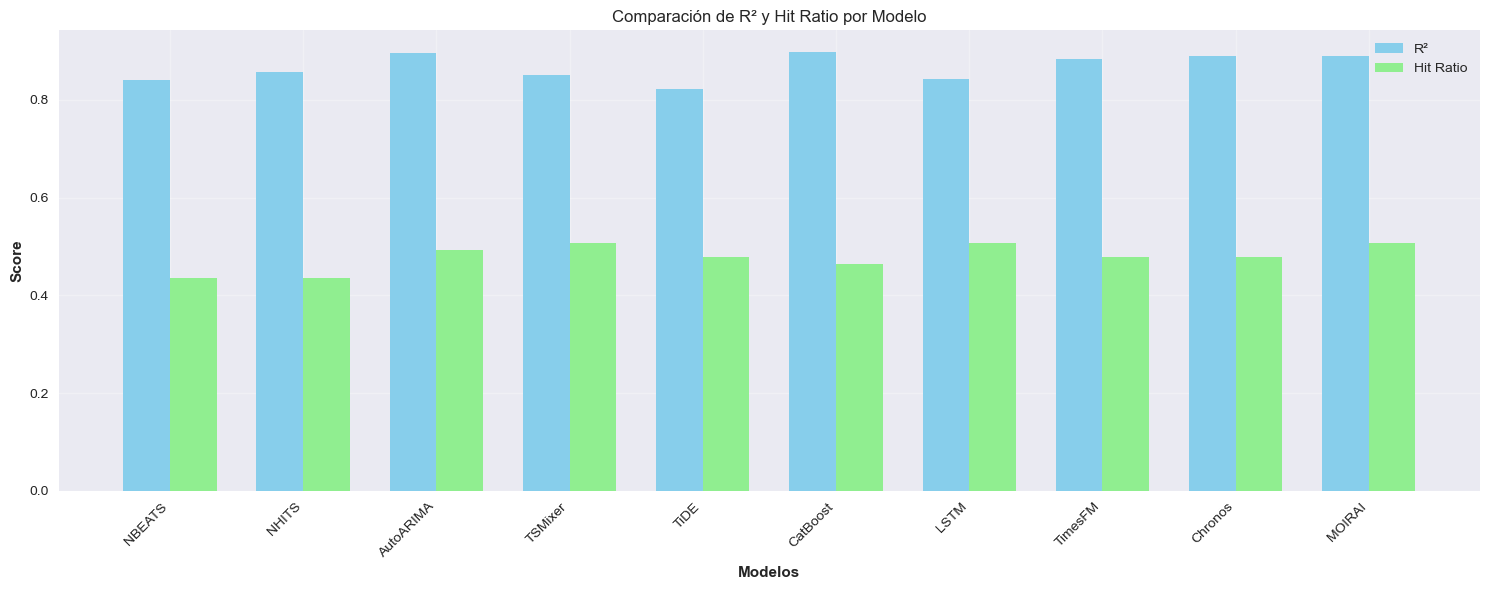

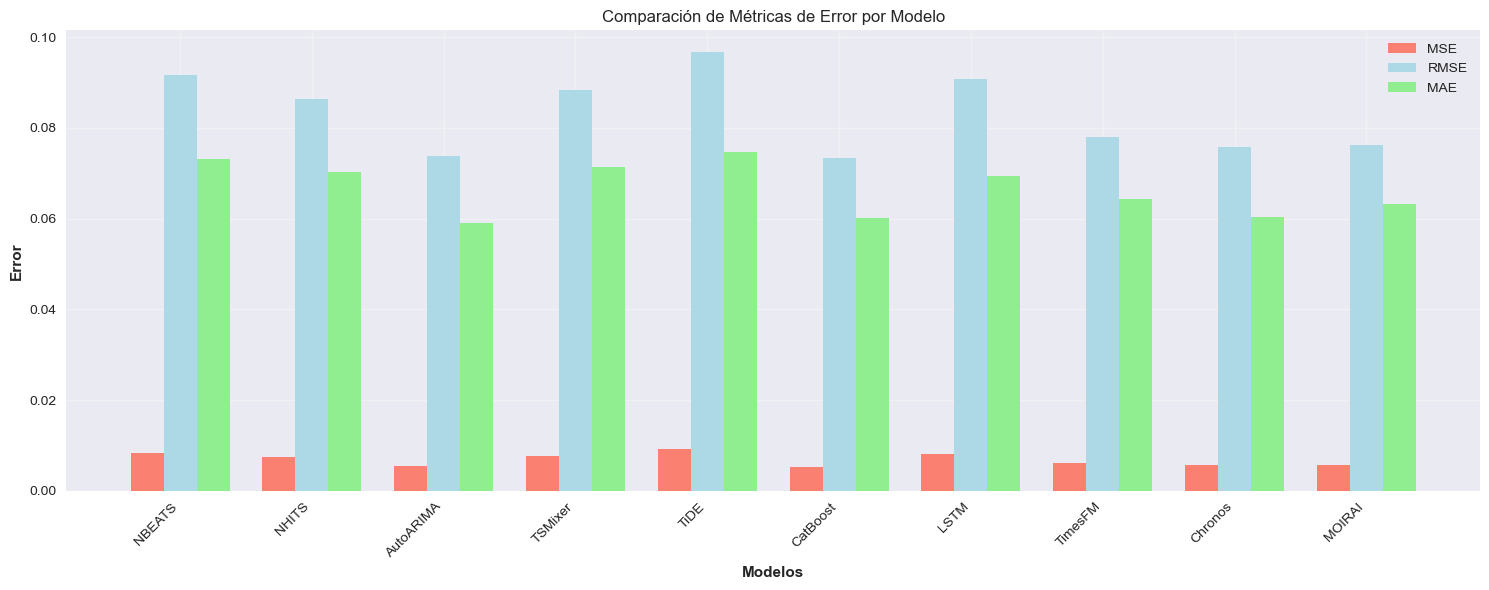


Resumen de Resultados:
    Model  Retrain    MSE   RMSE    MAE     R2 Hit Ratio
   NBEATS     True 0.0084 0.0916 0.0732 0.8404    43.66%
    NHITS     True 0.0075 0.0864 0.0702 0.8581    43.66%
AutoARIMA     True 0.0055 0.0739 0.0591 0.8960    49.30%
  TSMixer     True 0.0078 0.0883 0.0714 0.8517    50.70%
     TiDE     True 0.0093 0.0967 0.0748 0.8222    47.89%
 CatBoost     True 0.0054 0.0734 0.0601 0.8974    46.48%
     LSTM     True 0.0082 0.0907 0.0695 0.8433    50.70%
  TimesFM     True 0.0061 0.0780 0.0643 0.8842    47.89%
  Chronos     True 0.0057 0.0758 0.0604 0.8908    47.89%
   MOIRAI     True 0.0058 0.0763 0.0632 0.8891    50.70%

Mejores Modelos:
Mejor R²: CatBoost (R² = 0.8974)
Mejor Hit Ratio: TSMixer (Hit Ratio = 50.70%)
Menor RMSE: CatBoost (RMSE = 0.0734)


In [226]:
visualize_model_comparison(metricas_forecast_retrain)

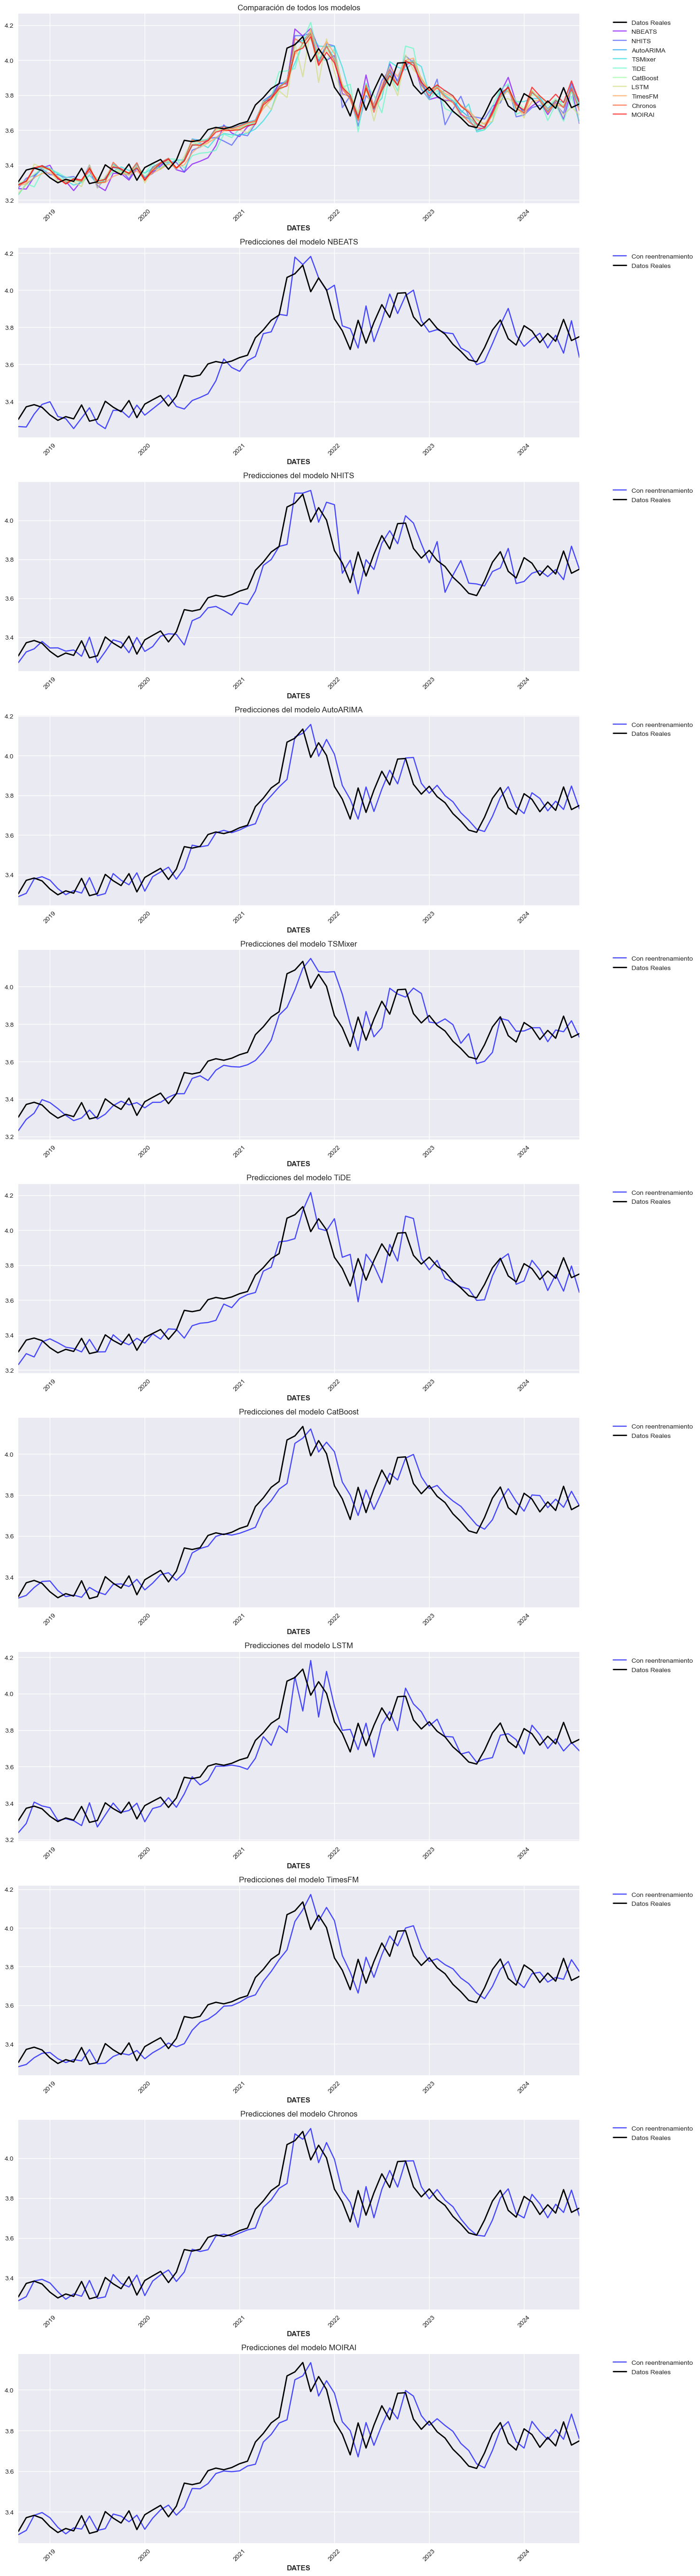

In [227]:
# Visualizar las predicciones
analyzer = ForecastAnalyzer()
real_data_series = test.pd_series()
analyzer.plot_forecasts(processed_models, real_data=real_data_series)

In [228]:
# Inicializar contenedores para resultados
all_metrics = []
all_returns_no_retrain = {}
all_returns_with_retrain = {}
y_true = test.values().flatten()

# Procesar cada modelo usando processed_models en lugar de model_list
for model_name, (y_pred_no_retrain, y_pred_with_retrain) in processed_models.items():
    print(f"\nProcesando modelo: {model_name}")
    try:
        evaluate_and_store_results(
            model_name=model_name,
            y_true=y_true,
            y_pred_no_retrain=y_pred_no_retrain,
            y_pred_with_retrain=y_pred_with_retrain,
            all_metrics=all_metrics,
            all_returns_no_retrain=all_returns_no_retrain,
            all_returns_with_retrain=all_returns_with_retrain,
            evaluator=evaluator,
        )
    except Exception as e:
        print(f"Error evaluando {model_name}: {str(e)}")


Procesando modelo: NBEATS

Métricas calculadas:
MSE: 0.0090
RMSE: 0.0951
MAE: 0.0777
R2: 0.8281

Hit Ratio = 47.89%
Total points: 71
Correct directions: 34
Accuracy: 0.4789

Métricas calculadas:
MSE: 0.0084
RMSE: 0.0916
MAE: 0.0732
R2: 0.8404

Hit Ratio = 43.66%
Total points: 71
Correct directions: 31
Accuracy: 0.4366
✓ NBEATS: Evaluación completada exitosamente
  - Longitud de retornos sin reentrenamiento: 0
  - Longitud de retornos con reentrenamiento: 0

Procesando modelo: NHITS

Métricas calculadas:
MSE: 0.0130
RMSE: 0.1139
MAE: 0.0854
R2: 0.7532

Hit Ratio = 50.70%
Total points: 71
Correct directions: 36
Accuracy: 0.5070

Métricas calculadas:
MSE: 0.0075
RMSE: 0.0864
MAE: 0.0702
R2: 0.8581

Hit Ratio = 43.66%
Total points: 71
Correct directions: 31
Accuracy: 0.4366
✓ NHITS: Evaluación completada exitosamente
  - Longitud de retornos sin reentrenamiento: 0
  - Longitud de retornos con reentrenamiento: 0

Procesando modelo: AutoARIMA

Métricas calculadas:
MSE: 0.1892
RMSE: 0.4349
M

In [229]:
# Procesar las predicciones y calcular retornos
all_returns_with_retrain = process_model_predictions(processed_models, test)

Procesando predicciones de los modelos...

Procesando NBEATS:
Predicciones shape: (72,)
Retornos calculados: 71 valores
Rango de retornos: [-0.0544, 0.0816]

Procesando NHITS:
Predicciones shape: (72,)
Retornos calculados: 71 valores
Rango de retornos: [-0.0863, 0.0680]

Procesando AutoARIMA:
Predicciones shape: (72,)
Retornos calculados: 71 valores
Rango de retornos: [-0.0393, 0.0552]

Procesando TSMixer:
Predicciones shape: (72,)
Retornos calculados: 71 valores
Rango de retornos: [-0.0425, 0.0569]

Procesando TiDE:
Predicciones shape: (72,)
Retornos calculados: 71 valores
Rango de retornos: [-0.0703, 0.0759]

Procesando CatBoost:
Predicciones shape: (72,)
Retornos calculados: 71 valores
Rango de retornos: [-0.0370, 0.0508]

Procesando LSTM:
Predicciones shape: (72,)
Retornos calculados: 71 valores
Rango de retornos: [-0.0742, 0.0811]

Procesando TimesFM:
Predicciones shape: (72,)
Retornos calculados: 71 valores
Rango de retornos: [-0.0448, 0.0508]

Procesando Chronos:
Predicciones sh

Procesando predicciones de los modelos...

Procesando NBEATS:
Predicciones shape: (72,)
Retornos calculados: 71 valores
Rango de retornos: [-0.0544, 0.0816]

Procesando NHITS:
Predicciones shape: (72,)
Retornos calculados: 71 valores
Rango de retornos: [-0.0863, 0.0680]

Procesando AutoARIMA:
Predicciones shape: (72,)
Retornos calculados: 71 valores
Rango de retornos: [-0.0393, 0.0552]

Procesando TSMixer:
Predicciones shape: (72,)
Retornos calculados: 71 valores
Rango de retornos: [-0.0425, 0.0569]

Procesando TiDE:
Predicciones shape: (72,)
Retornos calculados: 71 valores
Rango de retornos: [-0.0703, 0.0759]

Procesando CatBoost:
Predicciones shape: (72,)
Retornos calculados: 71 valores
Rango de retornos: [-0.0370, 0.0508]

Procesando LSTM:
Predicciones shape: (72,)
Retornos calculados: 71 valores
Rango de retornos: [-0.0742, 0.0811]

Procesando TimesFM:
Predicciones shape: (72,)
Retornos calculados: 71 valores
Rango de retornos: [-0.0448, 0.0508]

Procesando Chronos:
Predicciones sh

C:\Users\Carlos Palma\AppData\Local\Temp\ipykernel_60836\393343042.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


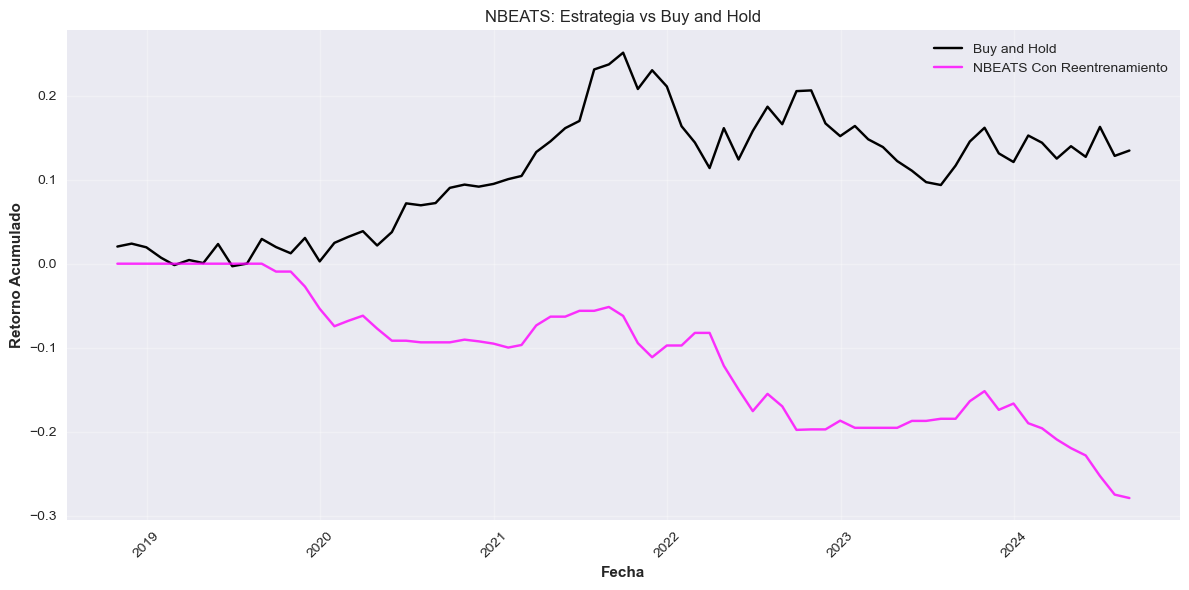


Métricas para NBEATS con reentrenamiento:
Total Return: -0.2792
Annualized Return: -0.0538
Sharpe Ratio: -1.0575
Information Ratio: -0.2632
Max Drawdown: -0.2792


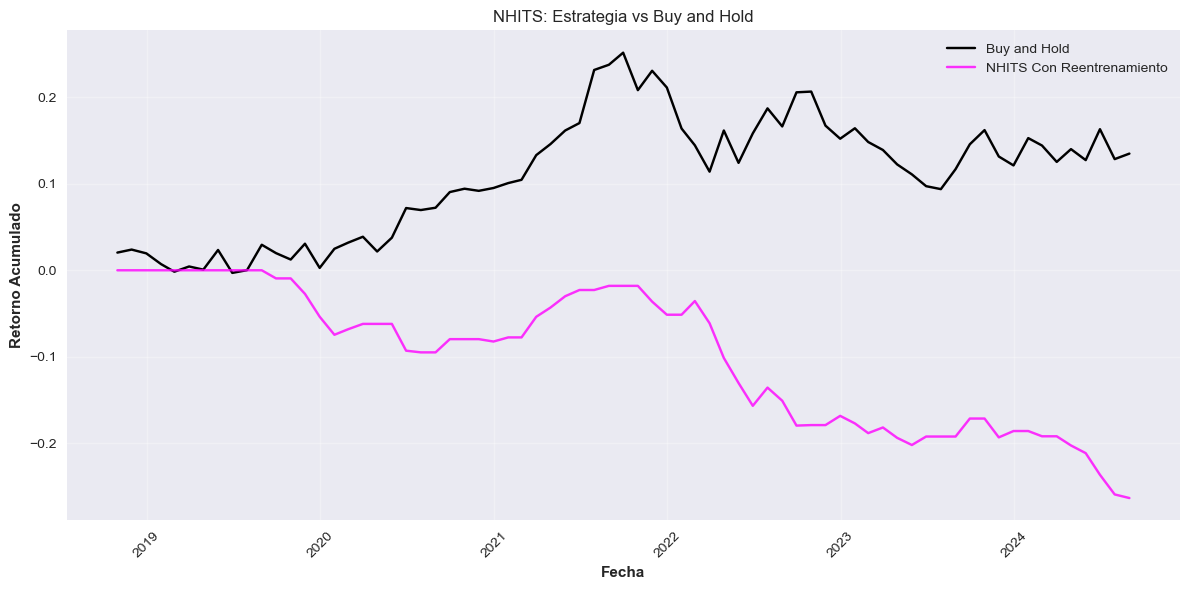


Métricas para NHITS con reentrenamiento:
Total Return: -0.2631
Annualized Return: -0.0503
Sharpe Ratio: -0.9874
Information Ratio: -0.2520
Max Drawdown: -0.2631


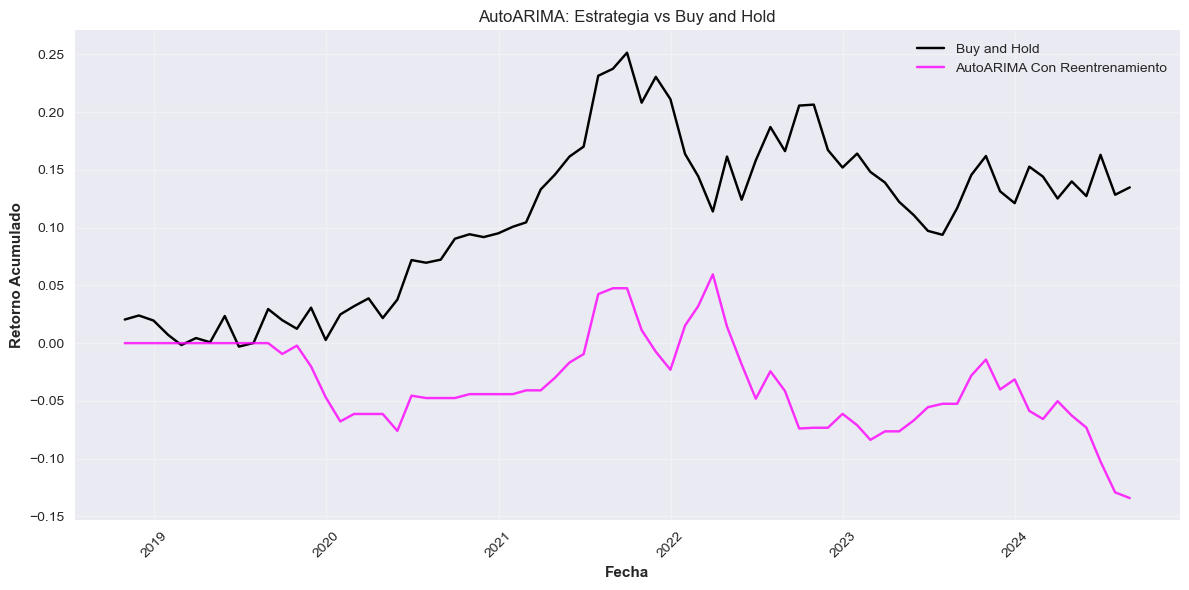


Métricas para AutoARIMA con reentrenamiento:
Total Return: -0.1341
Annualized Return: -0.0240
Sharpe Ratio: -0.3664
Information Ratio: -0.1468
Max Drawdown: -0.1827


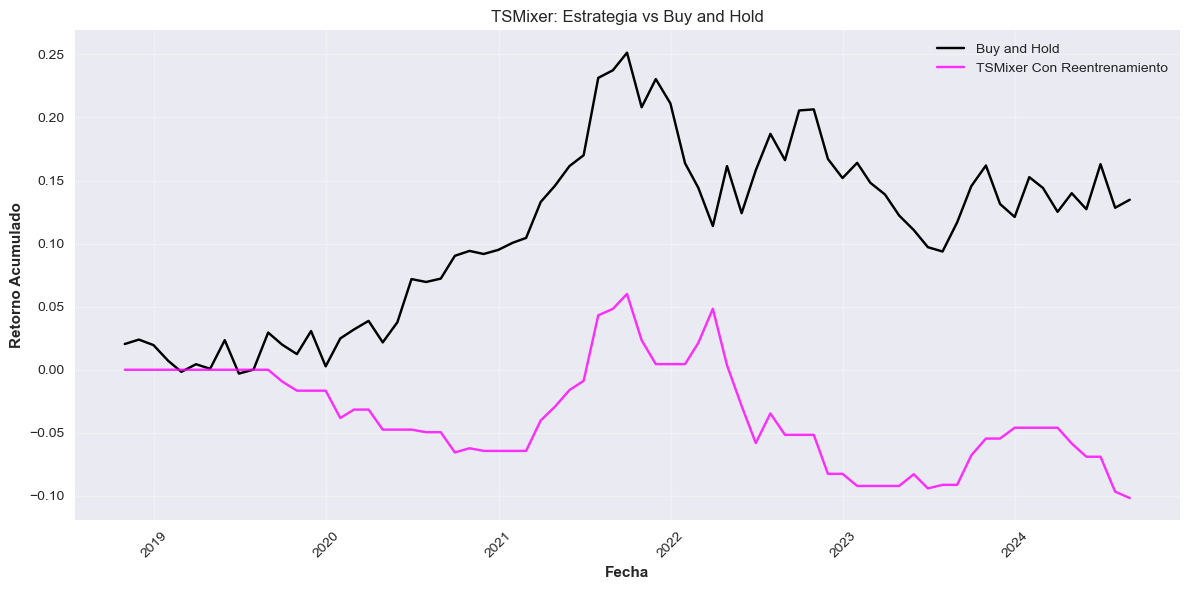


Métricas para TSMixer con reentrenamiento:
Total Return: -0.1017
Annualized Return: -0.0180
Sharpe Ratio: -0.3215
Information Ratio: -0.1562
Max Drawdown: -0.1526


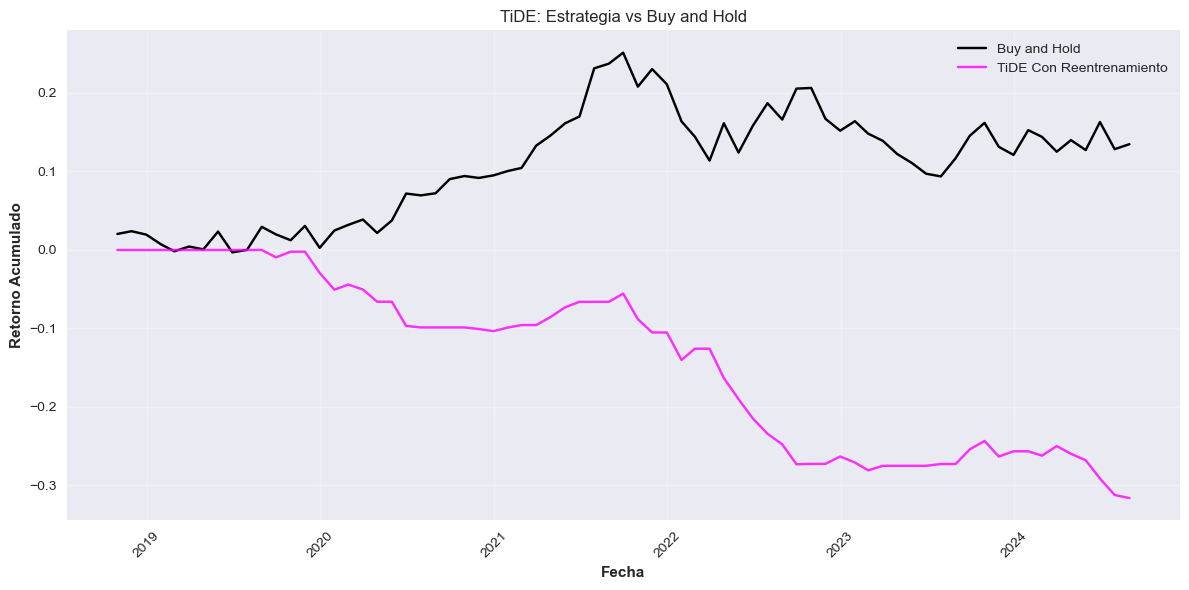


Métricas para TiDE con reentrenamiento:
Total Return: -0.3161
Annualized Return: -0.0622
Sharpe Ratio: -1.2231
Information Ratio: -0.2941
Max Drawdown: -0.3161


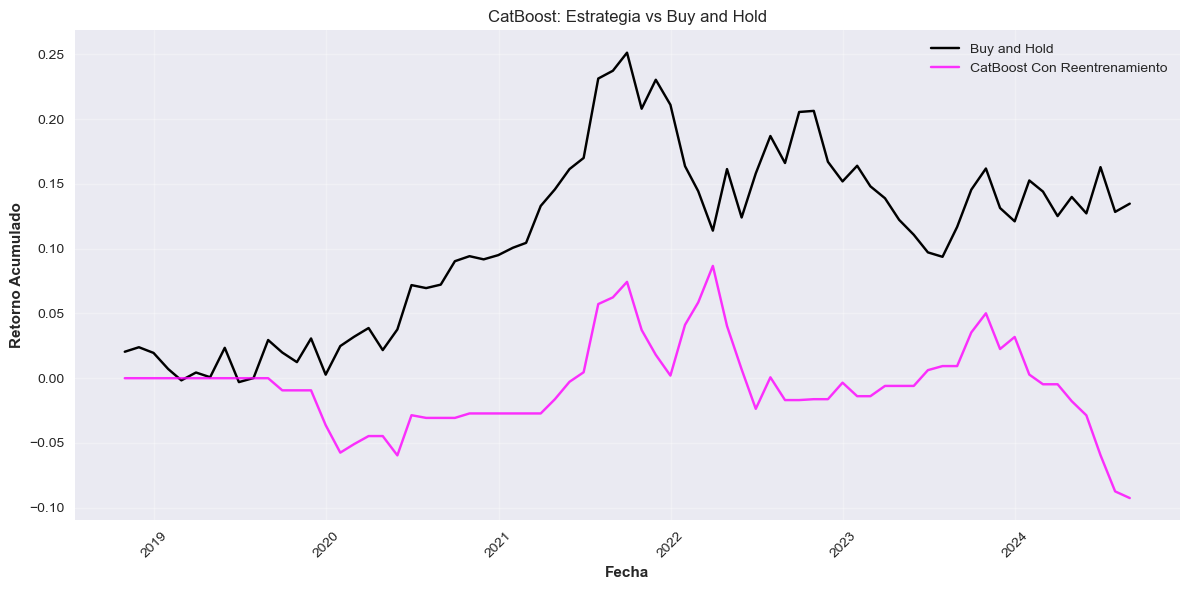


Métricas para CatBoost con reentrenamiento:
Total Return: -0.0926
Annualized Return: -0.0163
Sharpe Ratio: -0.2503
Information Ratio: -0.1296
Max Drawdown: -0.1650


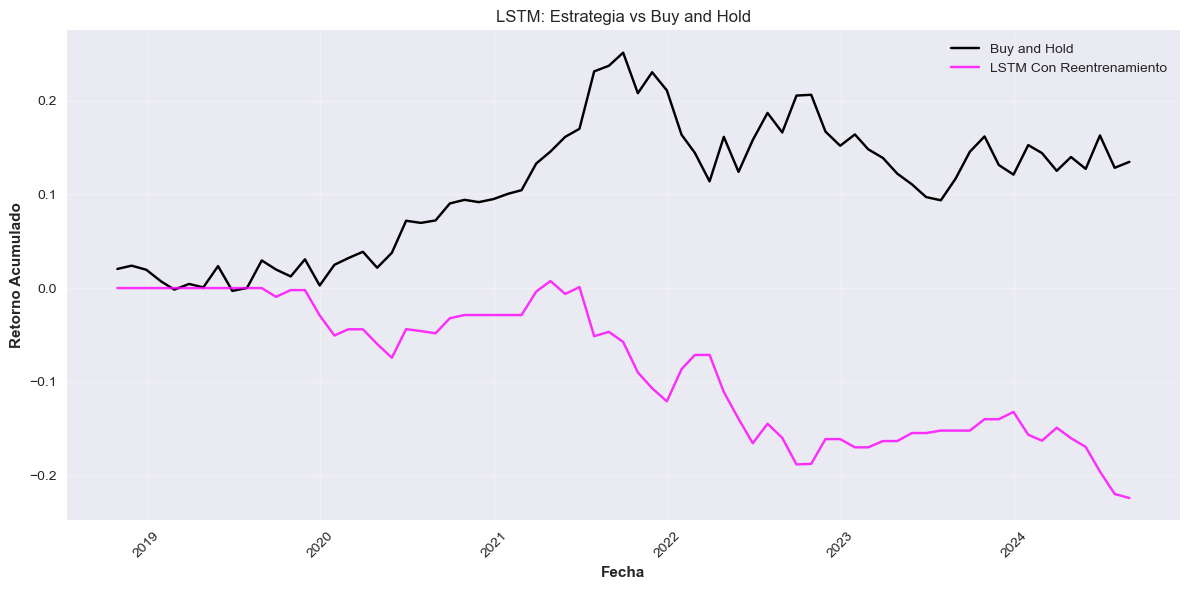


Métricas para LSTM con reentrenamiento:
Total Return: -0.2242
Annualized Return: -0.0420
Sharpe Ratio: -0.6871
Information Ratio: -0.1865
Max Drawdown: -0.2300


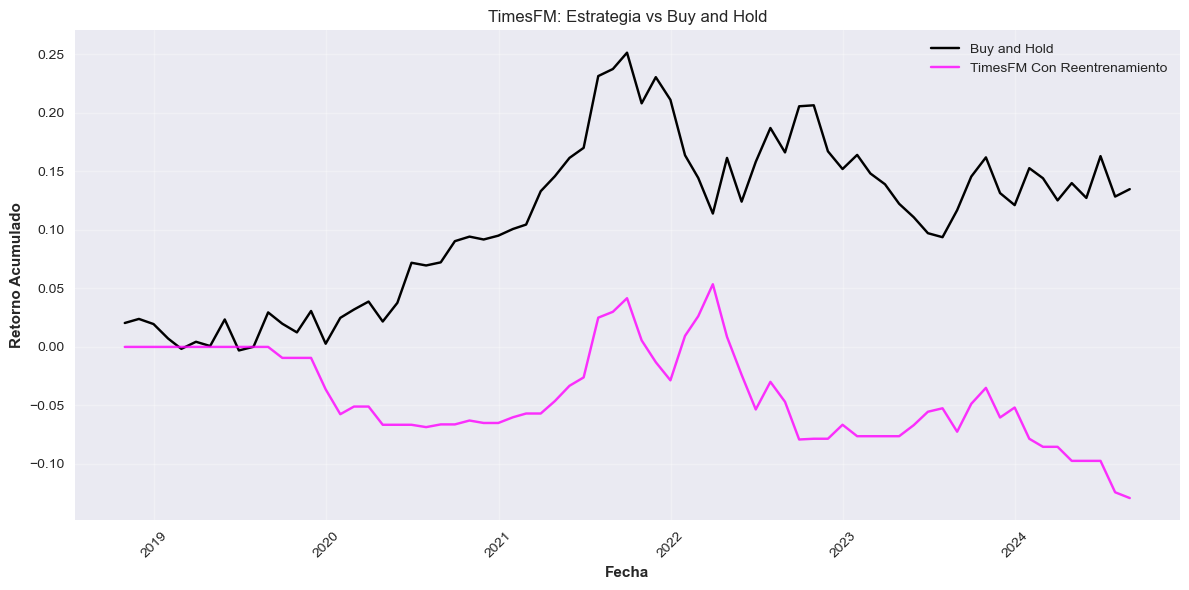


Métricas para TimesFM con reentrenamiento:
Total Return: -0.1291
Annualized Return: -0.0231
Sharpe Ratio: -0.3759
Information Ratio: -0.1500
Max Drawdown: -0.1734


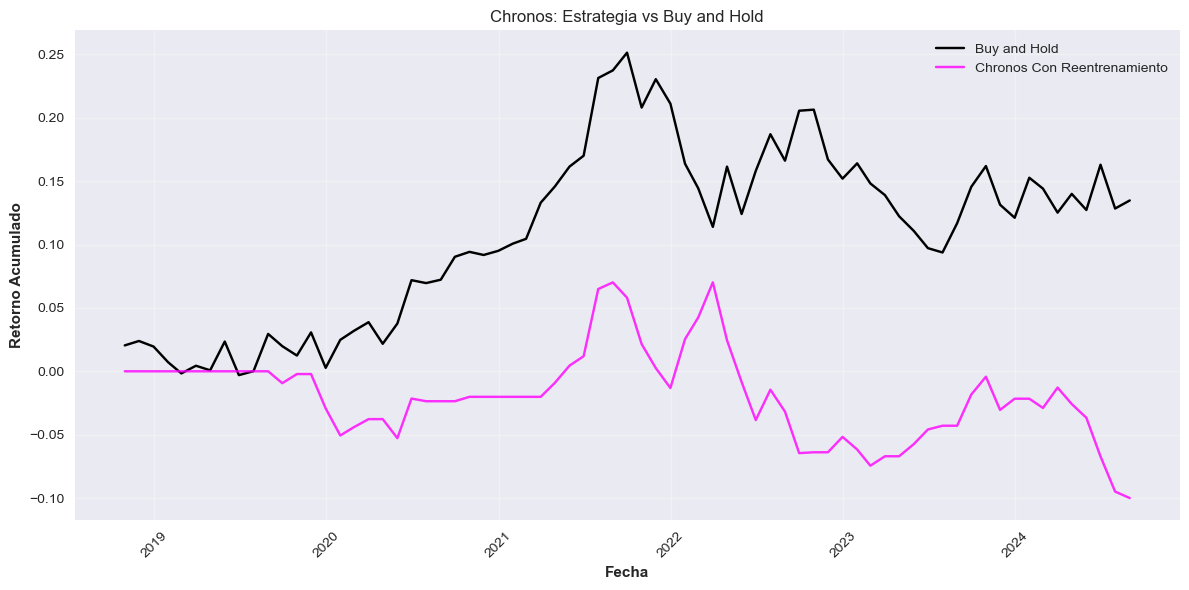


Métricas para Chronos con reentrenamiento:
Total Return: -0.1000
Annualized Return: -0.0177
Sharpe Ratio: -0.2665
Information Ratio: -0.1301
Max Drawdown: -0.1590


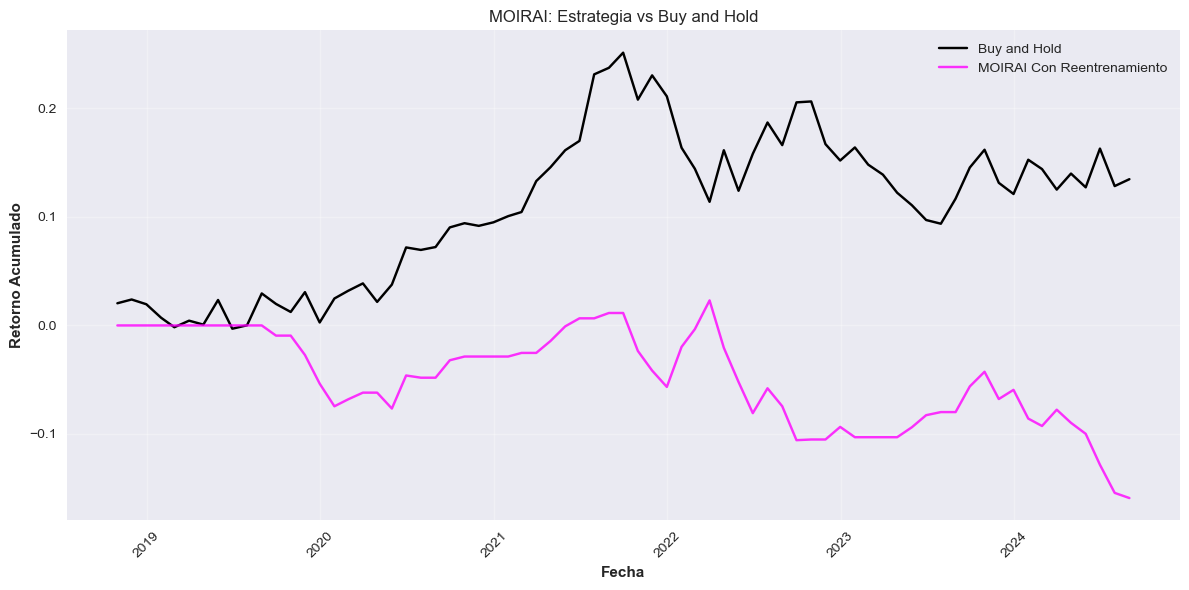


Métricas para MOIRAI con reentrenamiento:
Total Return: -0.1591
Annualized Return: -0.0289
Sharpe Ratio: -0.4834
Information Ratio: -0.1599
Max Drawdown: -0.1780


In [230]:
# 1. Crear instancia del visualizador
visualizer = StrategyVisualizer()
real_returns = TradingMetrics.calculate_returns(test)

all_returns_with_retrain = process_model_predictions(processed_models, test)

# 2. Personalizar el estilo (ahora solo necesitamos dos colores)
visualizer.set_style(
    colors={"buy_hold": "black", "with_retrain": "magenta"},
    line_styles={"buy_hold": "-", "with_retrain": "-"},
    alpha={"buy_hold": 1.0, "with_retrain": 0.8},
)

# 3. Visualizar estrategias para cada modelo
for model_name in all_returns_with_retrain.keys():
    # Obtener retornos de la estrategia con reentrenamiento
    # strategy_returns_with_retrain = TradingMetrics.implement_trading_strategy(real_returns,all_returns_with_retrain[model_name])
    strategy_returns_with_retrain = TradingMetrics.implement_trading_strategy_adaptive(
        real_returns, all_returns_with_retrain[model_name], lookback=12
    )
    # Visualizar estrategia
    visualizer.plot_strategy_comparison(
        real_returns=real_returns,
        strategy_returns_no_retrain=None,  # No usamos estrategia sin reentrenamiento
        strategy_returns_with_retrain=strategy_returns_with_retrain,
        model_name=model_name,
    )

C:\Users\Carlos Palma\AppData\Local\Temp\ipykernel_60836\393343042.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


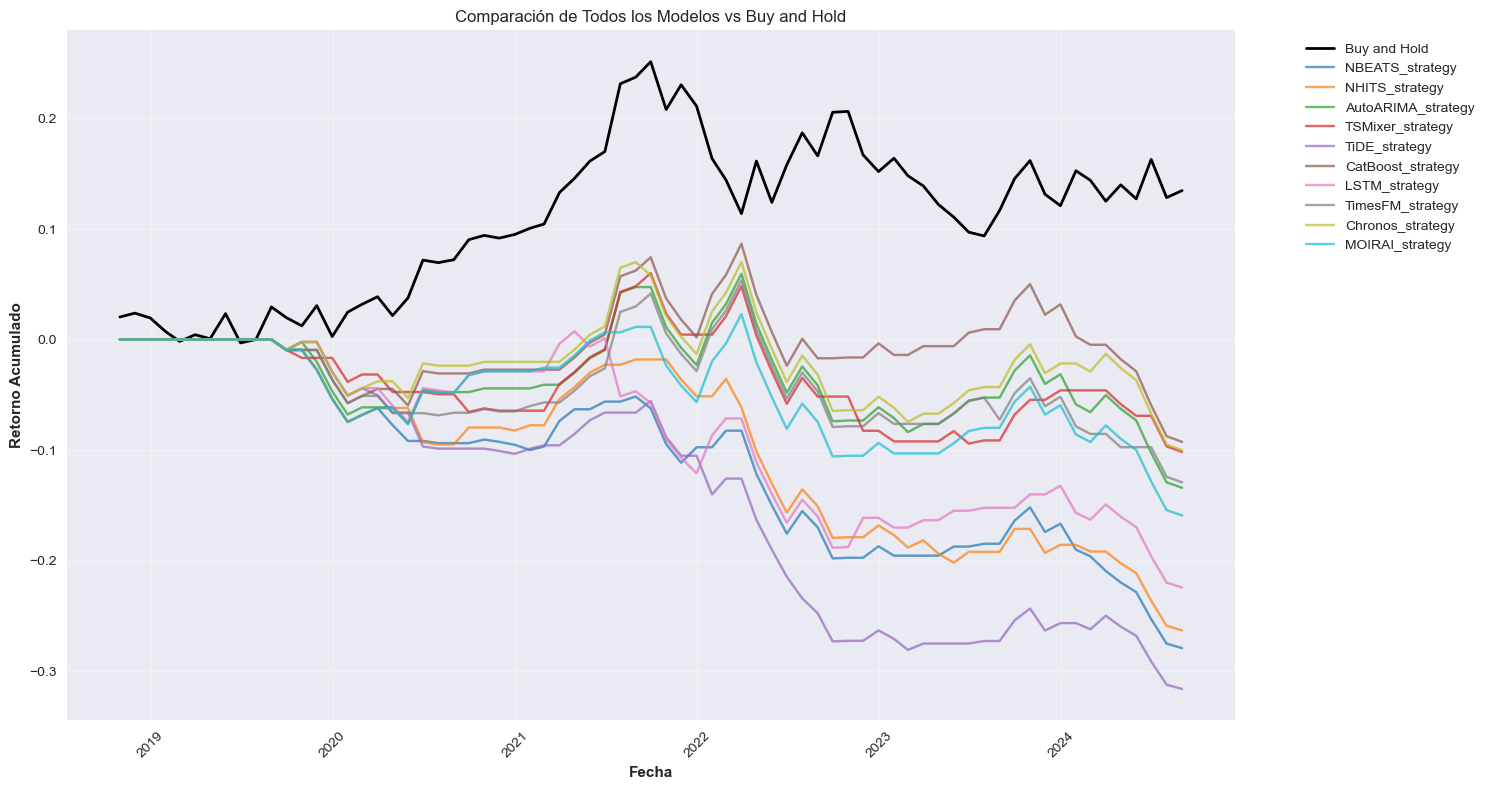


Métricas Comparativas:
----------------------------------------------------------------------------------------------------
Modelo          Total Return Sharpe Ratio Information Ratio Max Drawdown
----------------------------------------------------------------------------------------------------
NBEATS_strategy      -0.2792      -1.0575         -0.2632      -0.2792
NHITS_strategy       -0.2631      -0.9874         -0.2520      -0.2631
AutoARIMA_strategy      -0.1341      -0.3664         -0.1468      -0.1827
TSMixer_strategy      -0.1017      -0.3215         -0.1562      -0.1526
TiDE_strategy        -0.3161      -1.2231         -0.2941      -0.3161
CatBoost_strategy      -0.0926      -0.2503         -0.1296      -0.1650
LSTM_strategy        -0.2242      -0.6871         -0.1865      -0.2300
TimesFM_strategy      -0.1291      -0.3759         -0.1500      -0.1734
Chronos_strategy      -0.1000      -0.2665         -0.1301      -0.1590
MOIRAI_strategy      -0.1591      -0.4834         -0.1

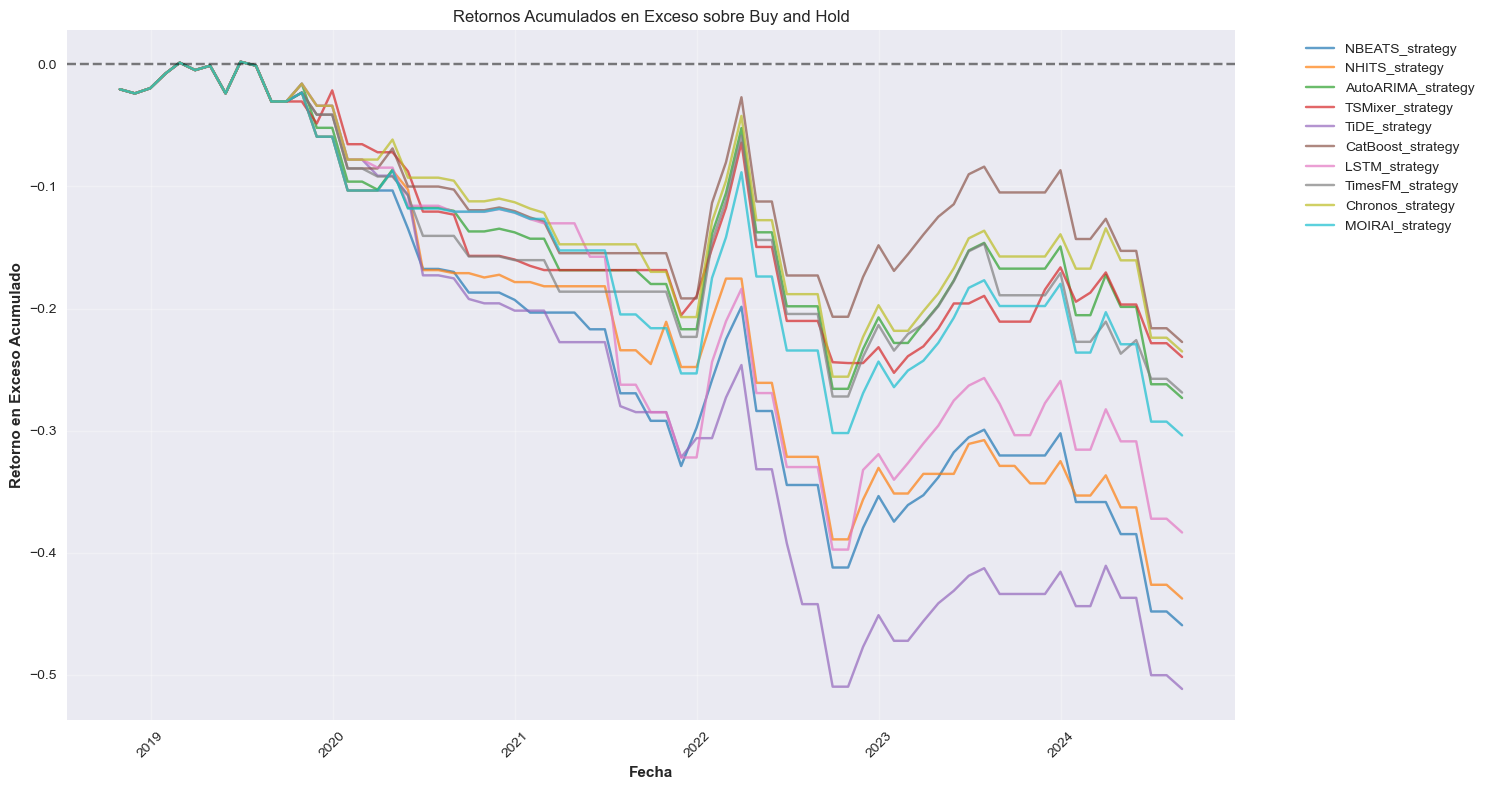

In [231]:
# 1. Crear instancia del visualizador
visualizer = StrategyVisualizer()
# 1. Generar panel de estrategias
strategies_panel = generate_strategies_panel(
    all_returns_with_retrain=all_returns_with_retrain,
    real_returns=real_returns,
    model_list=model_list,
)
real_returns = TradingMetrics.calculate_returns(test)

# 2. Visualizar todos los modelos juntos
visualizer.plot_all_models_comparison(
    real_returns=real_returns, all_returns_with_retrain=strategies_panel
)

# 3. Visualizar retornos en exceso
visualizer.plot_strategy_returns_comparison(
    real_returns=real_returns, all_returns_with_retrain=strategies_panel
)

C:\Users\Carlos Palma\AppData\Local\Temp\ipykernel_60836\1695036989.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data[column] = (1 + period_data[column]) / (1 + first_value) - 1


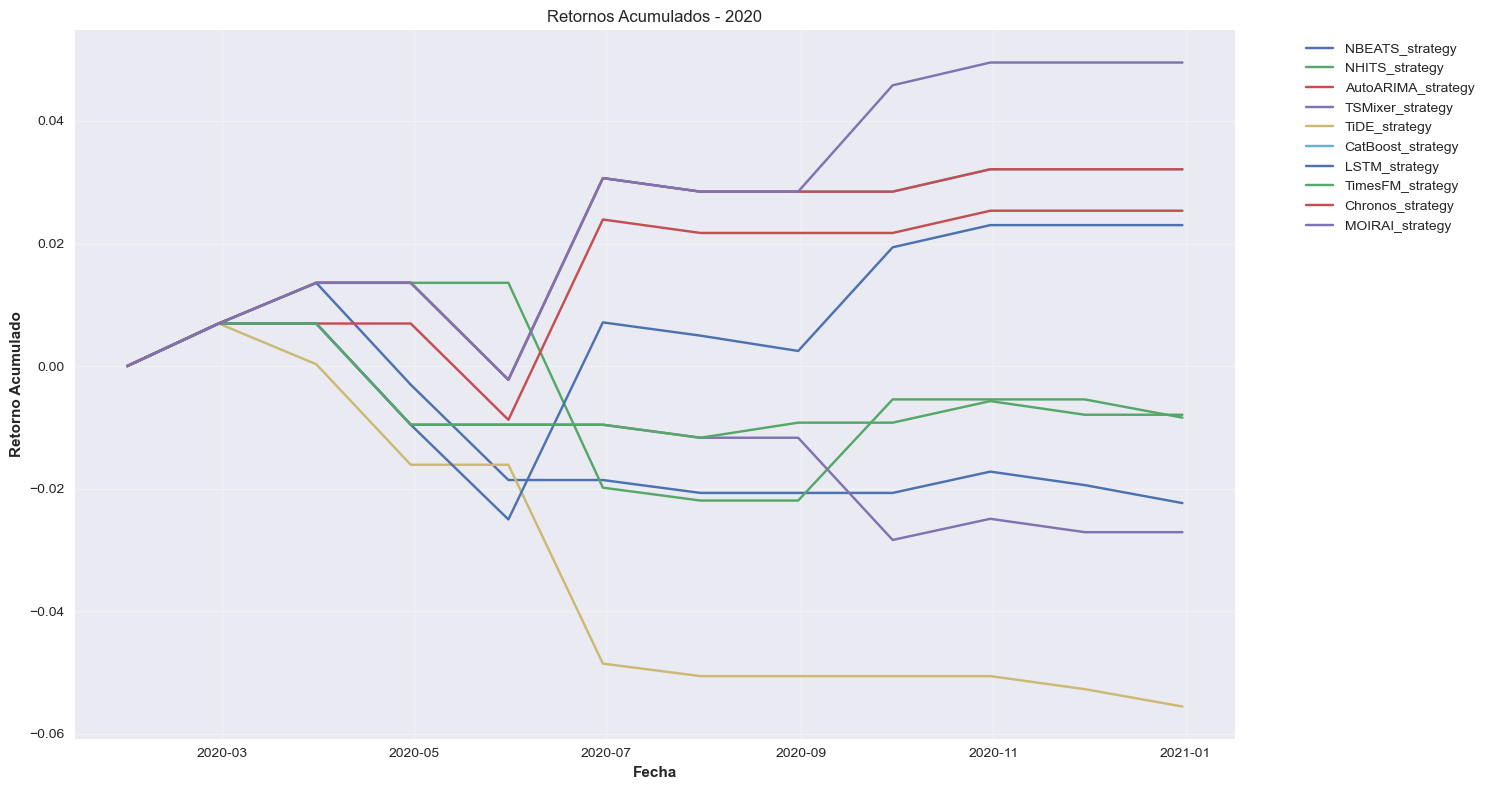

C:\Users\Carlos Palma\AppData\Local\Temp\ipykernel_60836\1695036989.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data[column] = (1 + period_data[column]) / (1 + first_value) - 1


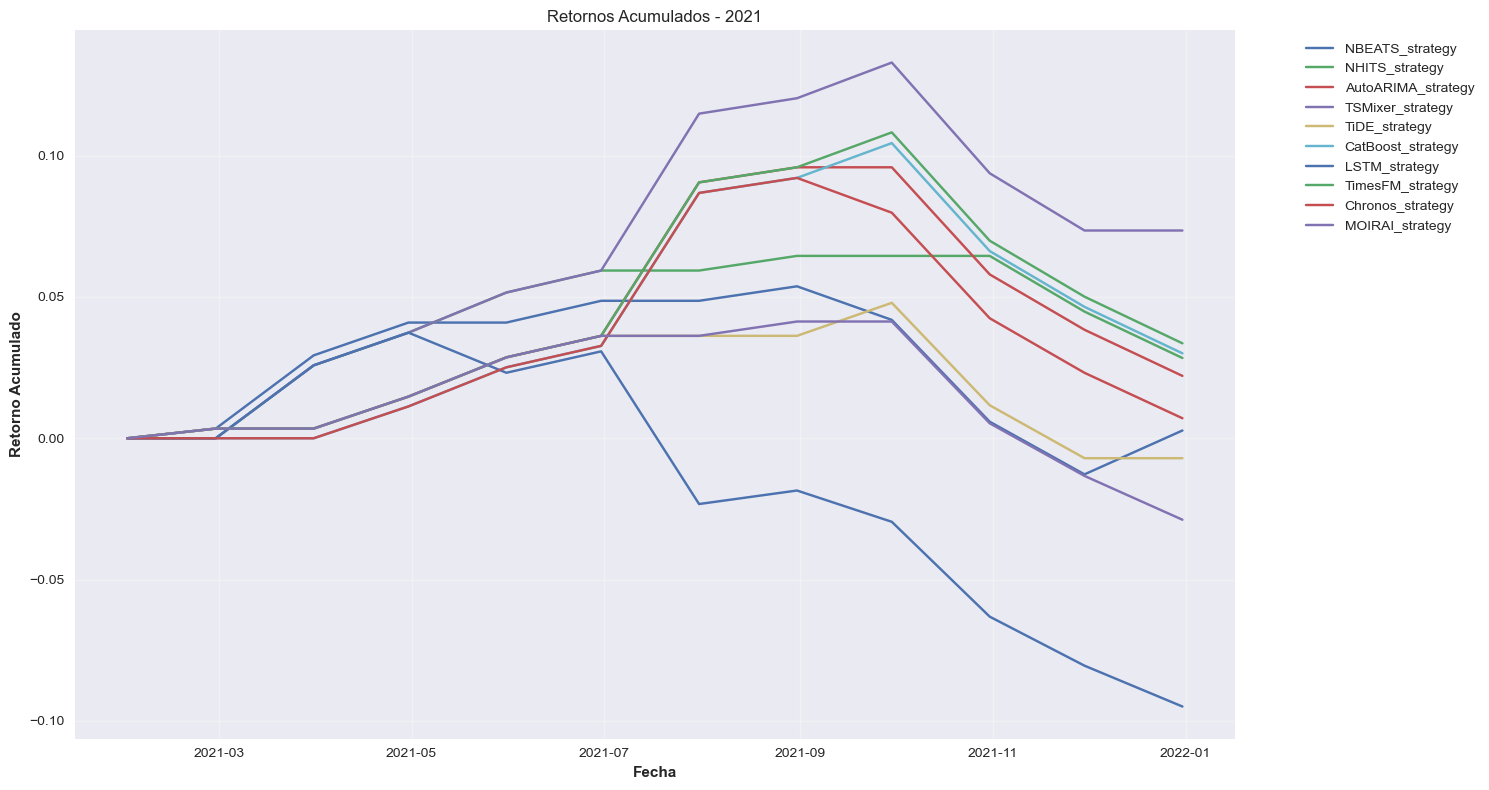

C:\Users\Carlos Palma\AppData\Local\Temp\ipykernel_60836\1695036989.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data[column] = (1 + period_data[column]) / (1 + first_value) - 1


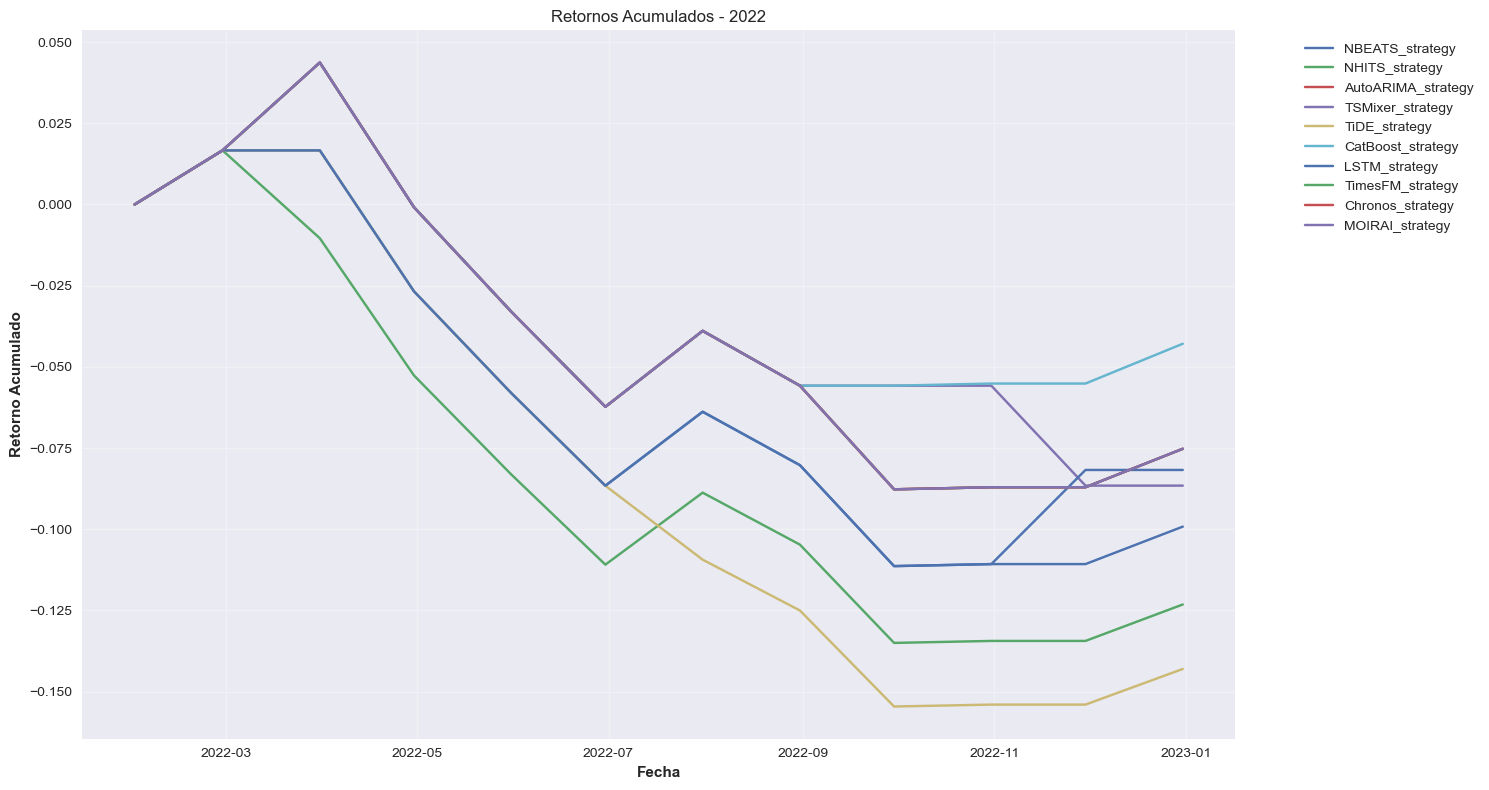

C:\Users\Carlos Palma\AppData\Local\Temp\ipykernel_60836\1695036989.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data[column] = (1 + period_data[column]) / (1 + first_value) - 1


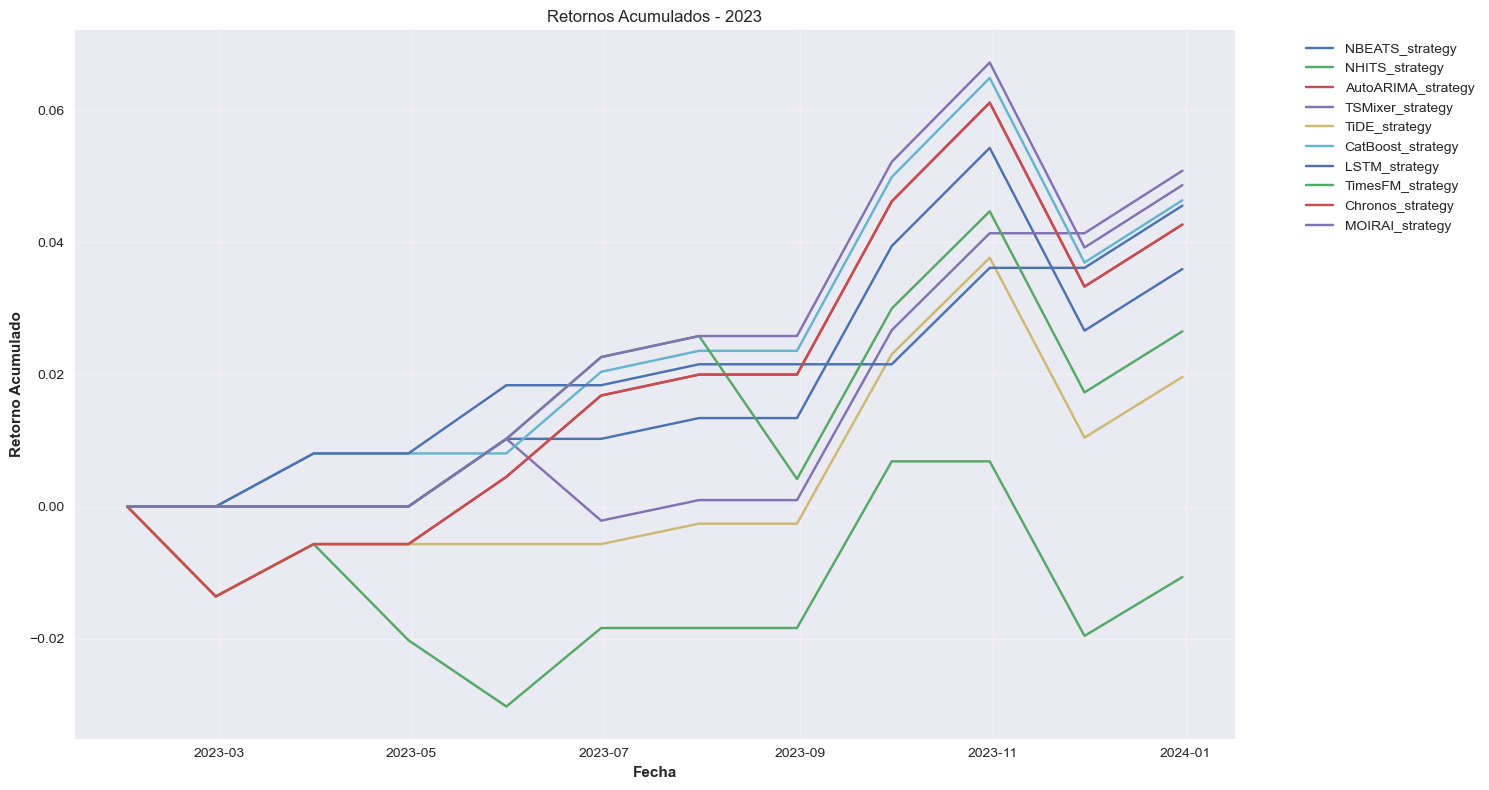

C:\Users\Carlos Palma\AppData\Local\Temp\ipykernel_60836\1695036989.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data[column] = (1 + period_data[column]) / (1 + first_value) - 1


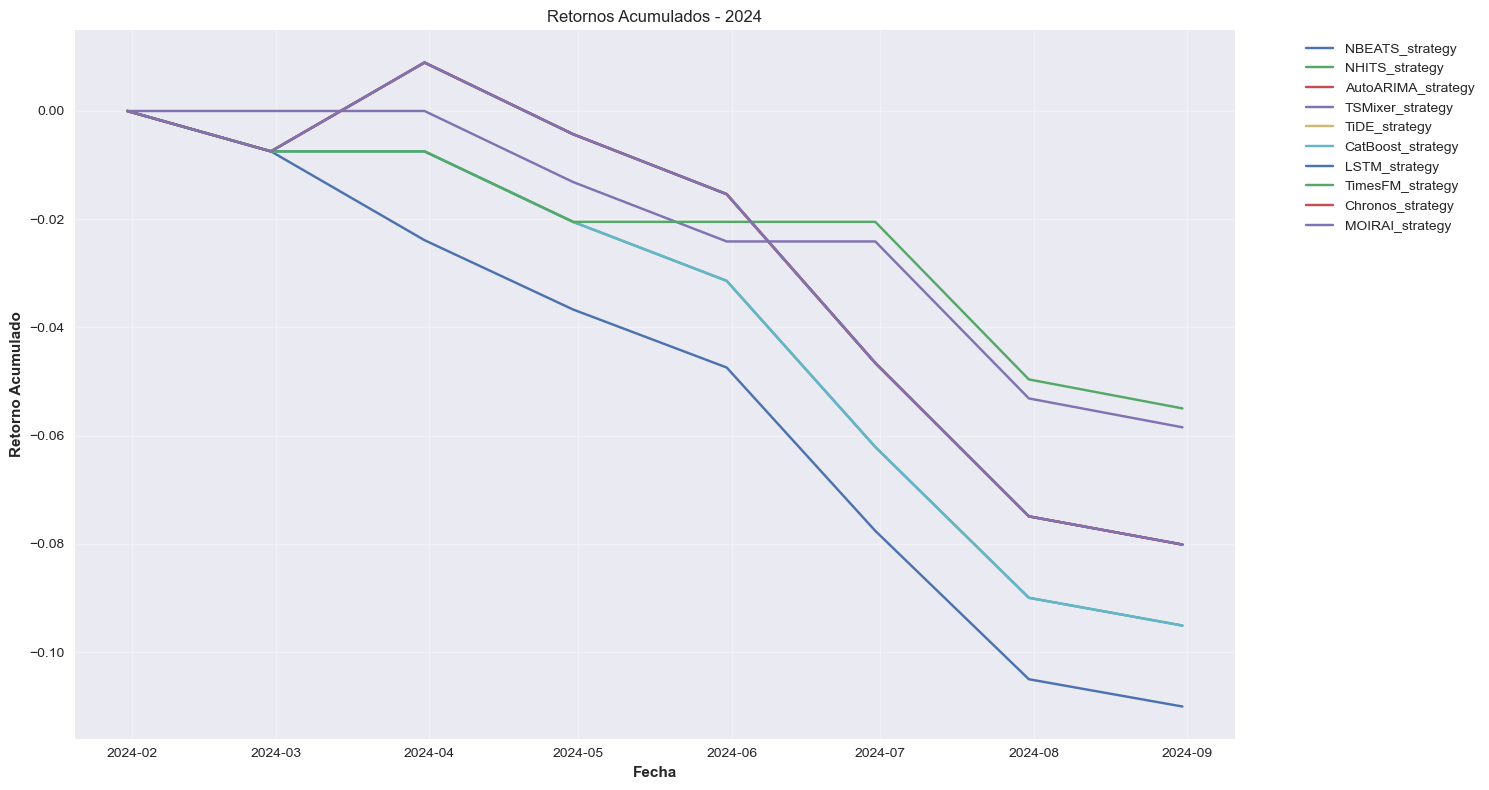

In [232]:
# 2. Generar panel de retornos acumulados
cumulative_panel = generate_cumulative_returns_panel(strategies_panel)

# 3. Visualizar diferentes períodos
for year in ["2020", "2021", "2022", "2023", "2024"]:
    plot_cumulative_returns_by_period(cumulative_panel, year)

In [233]:
# Primero, asegurémonos de que el strategies_panel se genera correctamente
strategies_panel = generate_strategies_panel(
    all_returns_with_retrain=all_returns_with_retrain,
    real_returns=real_returns,
    model_list=model_list,
)

print("\nVerificación del strategies_panel:")
print(f"Columnas disponibles: {strategies_panel.columns}")
print(f"Rango de fechas: {strategies_panel.index[0]} a {strategies_panel.index[-1]}")


Verificación del strategies_panel:
Columnas disponibles: Index(['NBEATS_strategy', 'NHITS_strategy', 'AutoARIMA_strategy',
       'TSMixer_strategy', 'TiDE_strategy', 'CatBoost_strategy',
       'LSTM_strategy', 'TimesFM_strategy', 'Chronos_strategy',
       'MOIRAI_strategy'],
      dtype='object')
Rango de fechas: 2018-10-31 00:00:00 a 2024-08-31 00:00:00



Procesando modelo: NBEATS
Longitud predicted_returns: 71
Longitud strategy_returns: 71
Longitud real_returns: 71


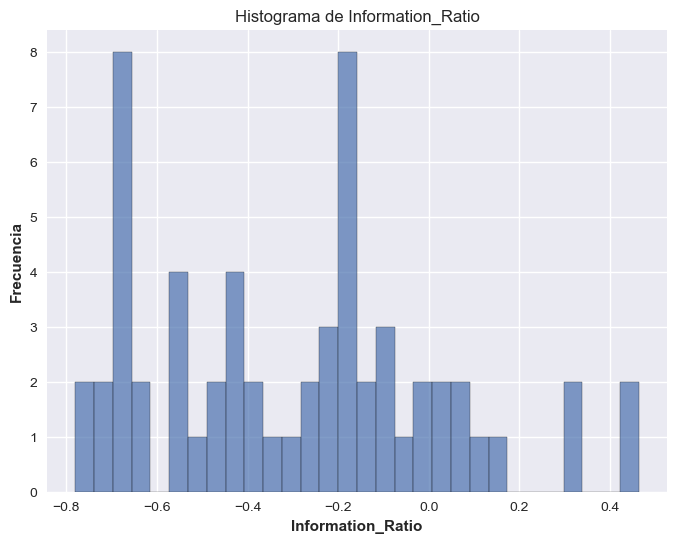

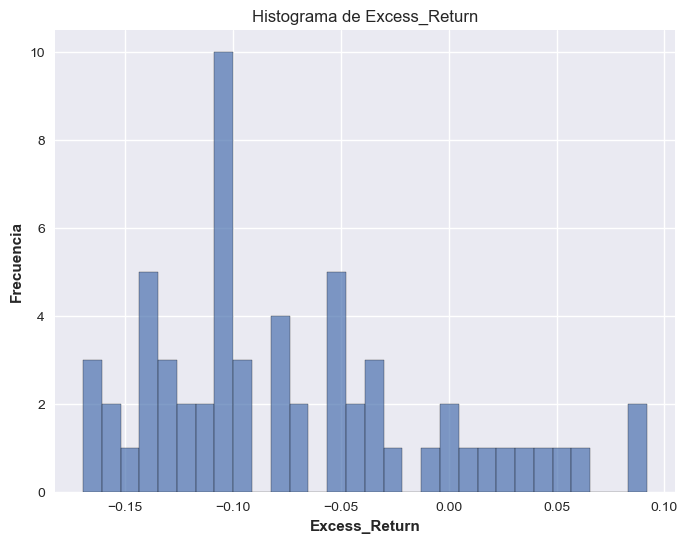

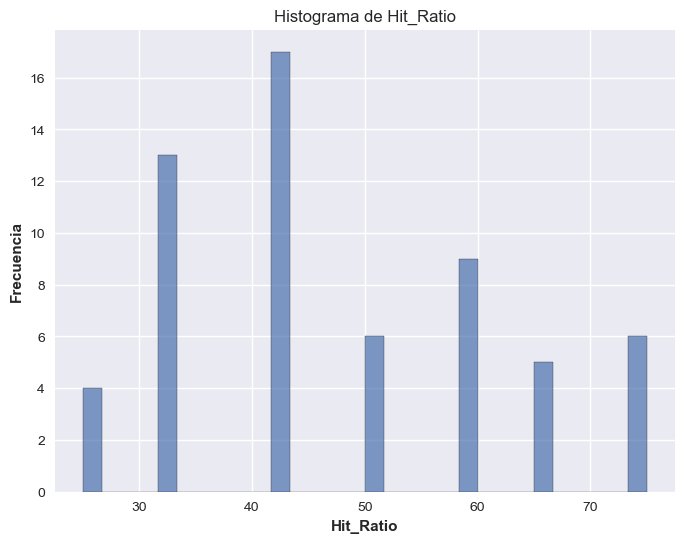

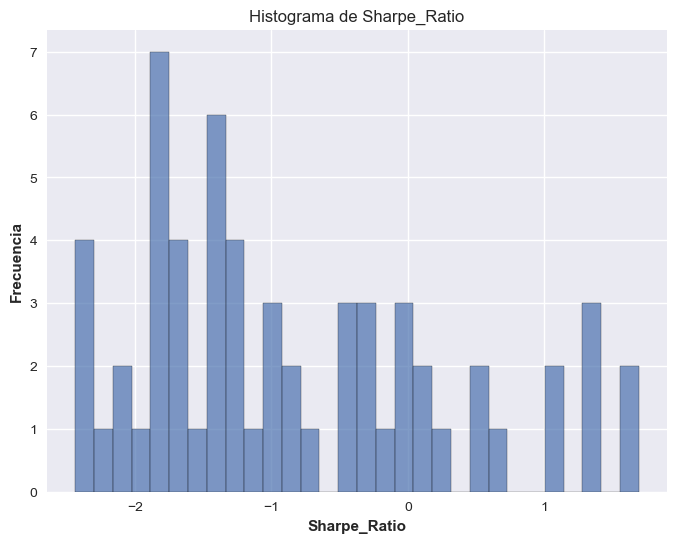

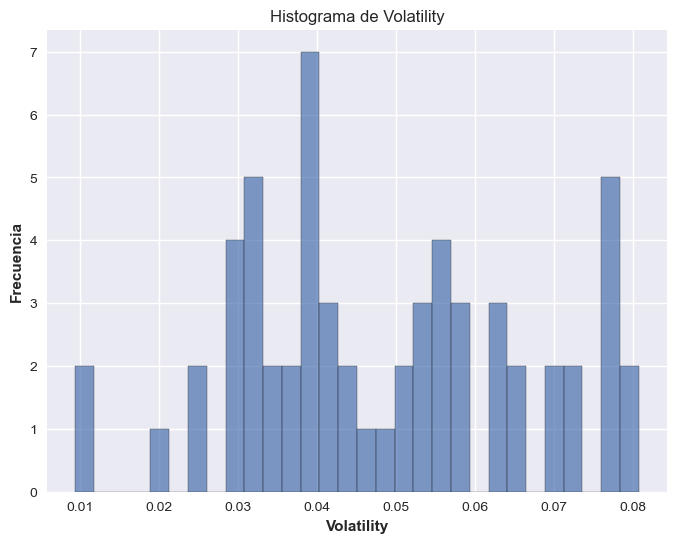

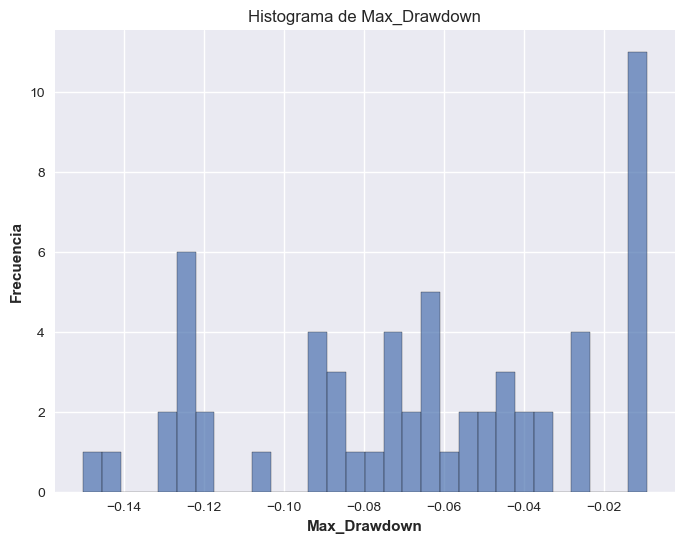

Modelo NBEATS: Métricas calculadas exitosamente.

Procesando modelo: NHITS
Longitud predicted_returns: 71
Longitud strategy_returns: 71
Longitud real_returns: 71


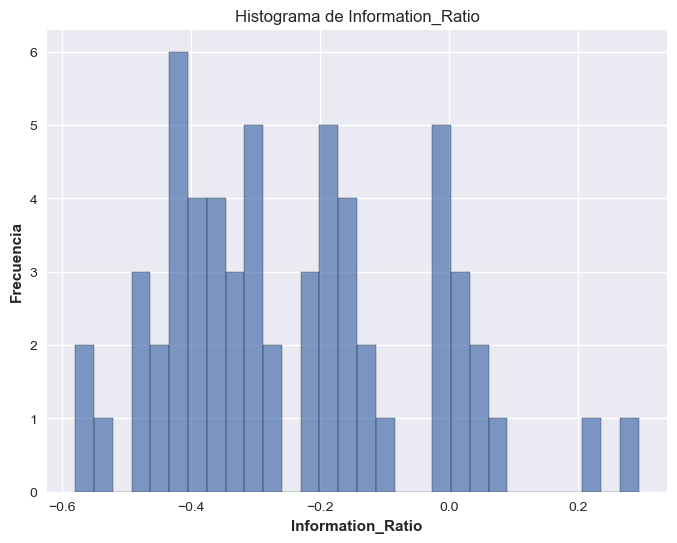

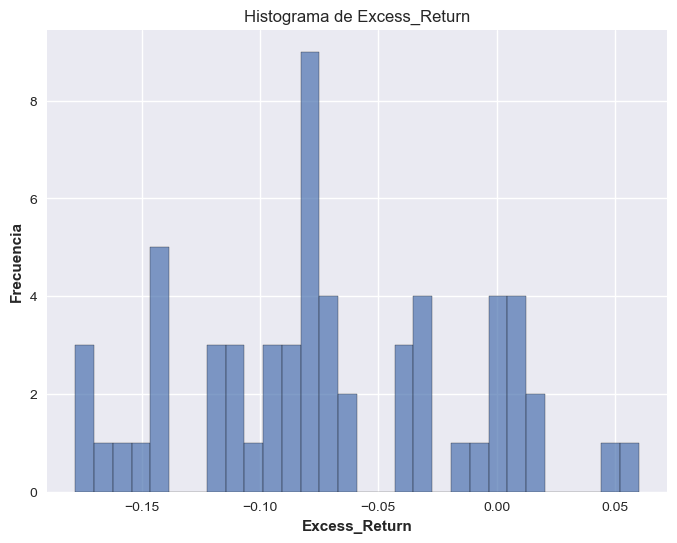

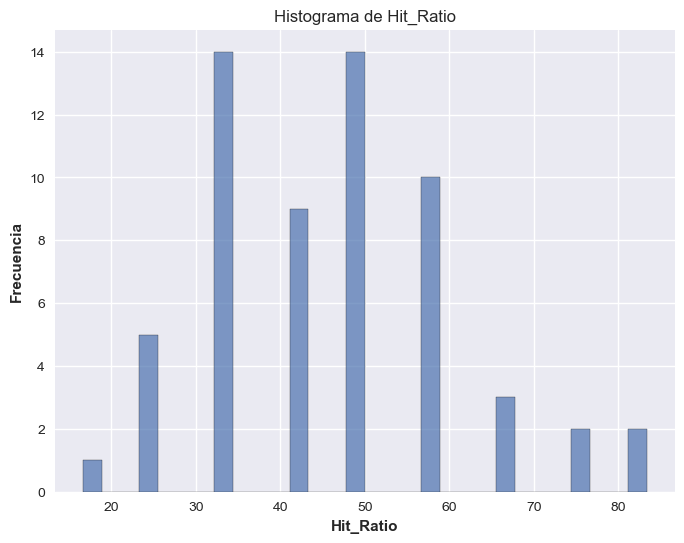

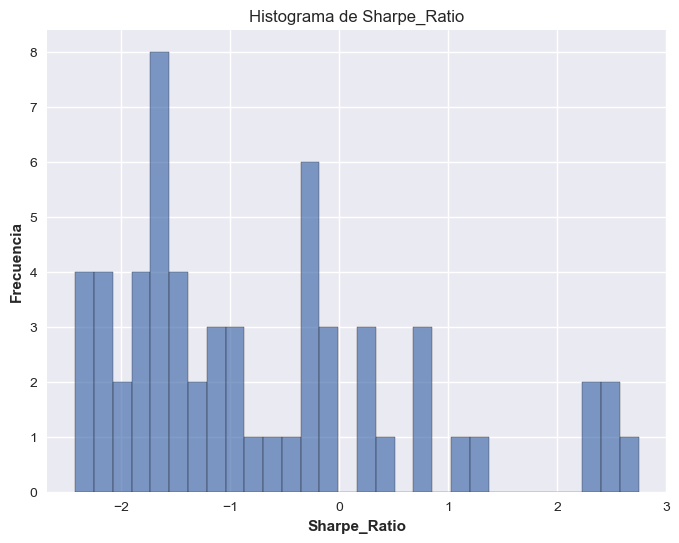

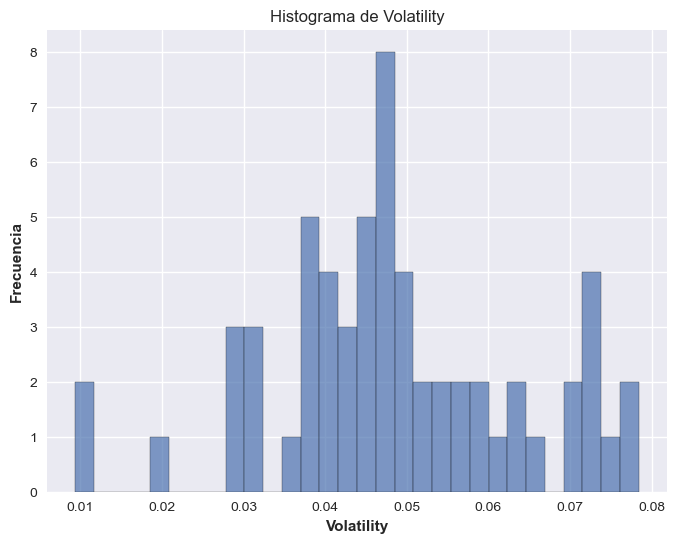

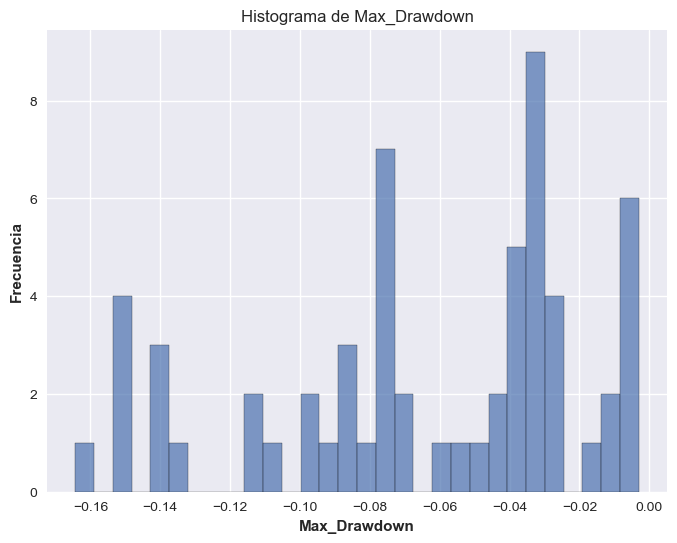

Modelo NHITS: Métricas calculadas exitosamente.

Procesando modelo: AutoARIMA
Longitud predicted_returns: 71
Longitud strategy_returns: 71
Longitud real_returns: 71


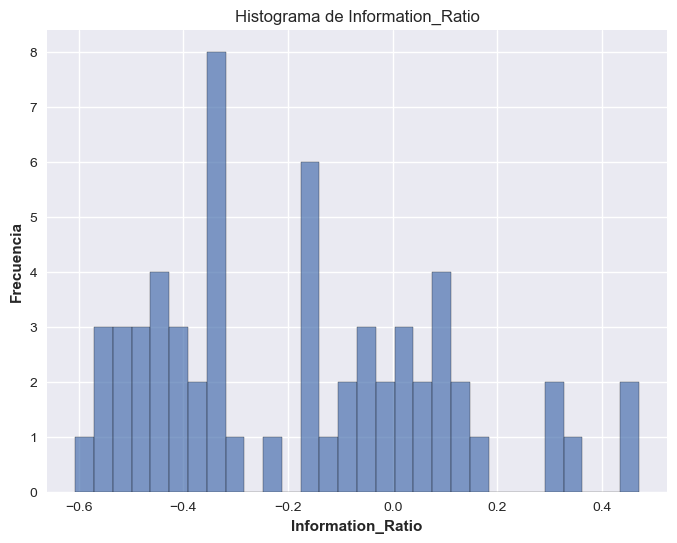

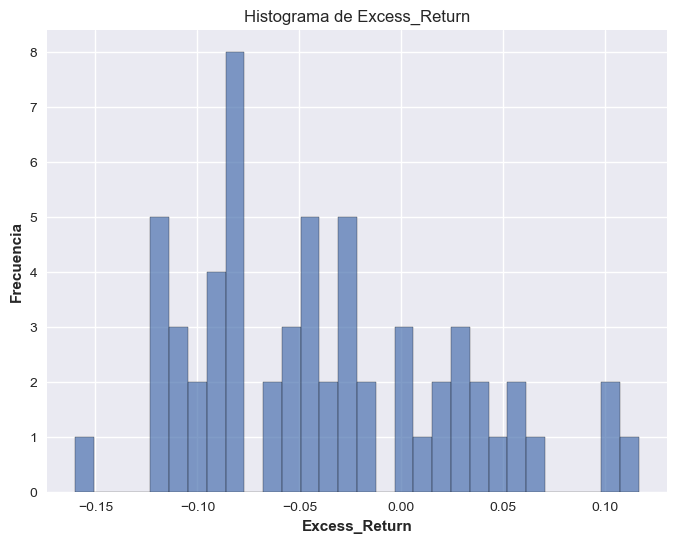

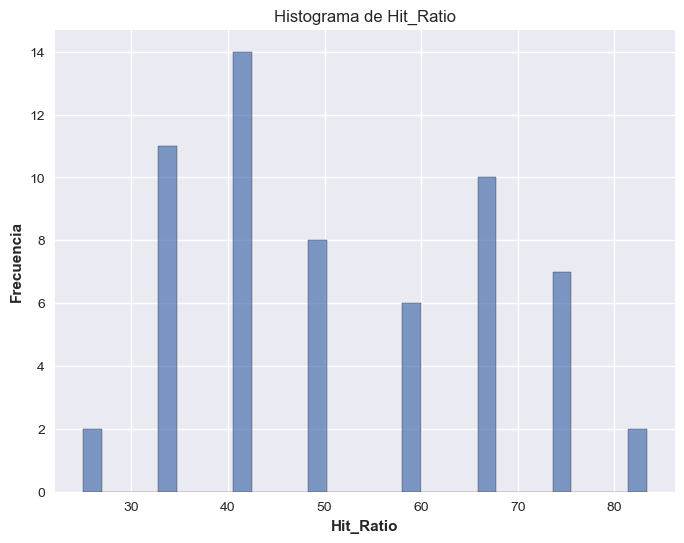

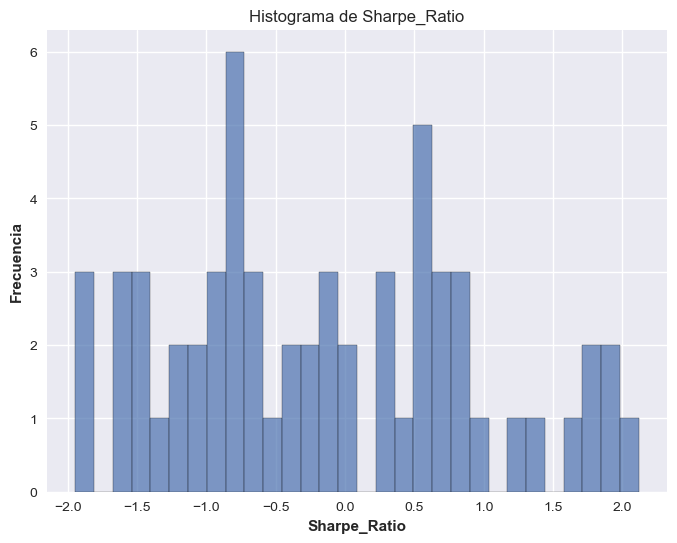

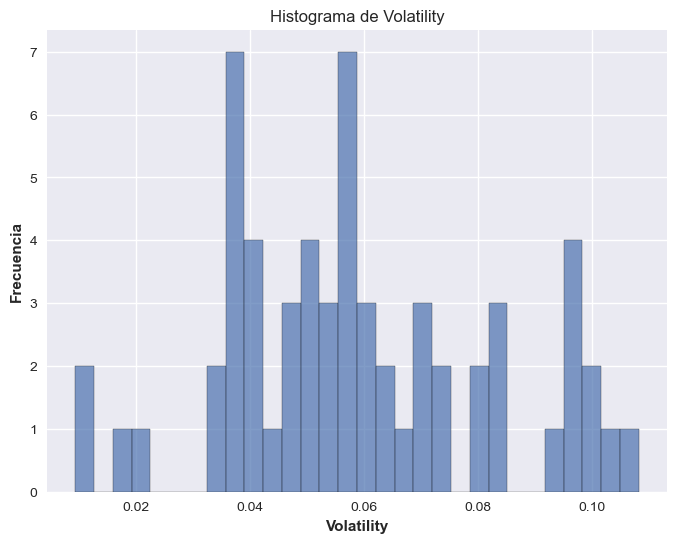

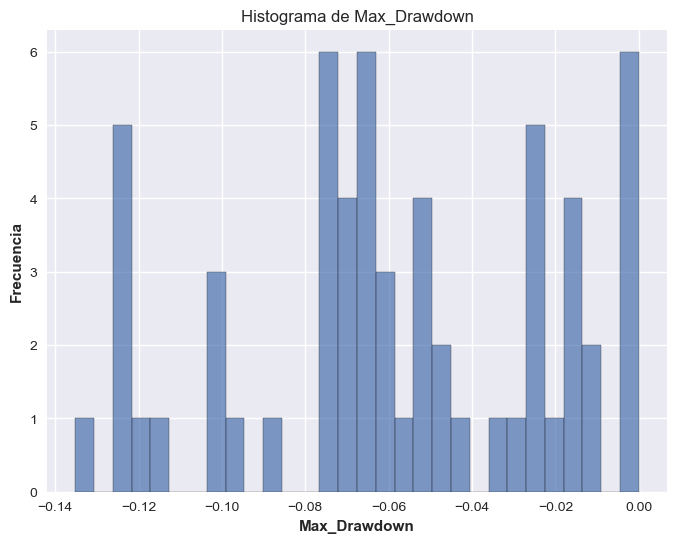

Modelo AutoARIMA: Métricas calculadas exitosamente.

Procesando modelo: TSMixer
Longitud predicted_returns: 71
Longitud strategy_returns: 71
Longitud real_returns: 71


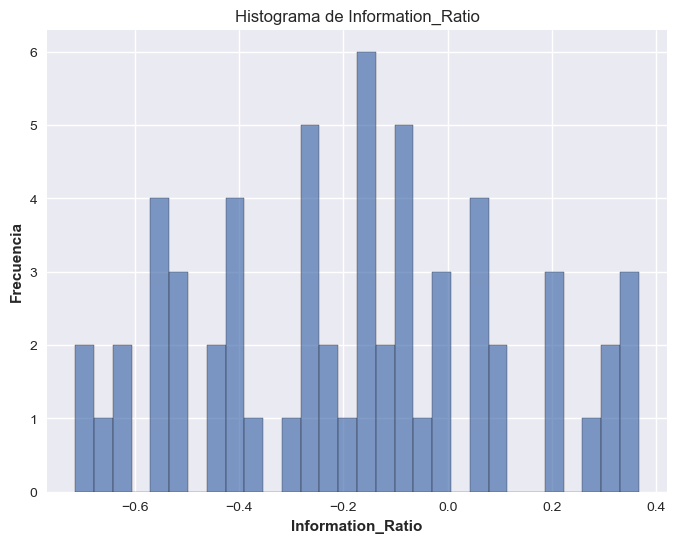

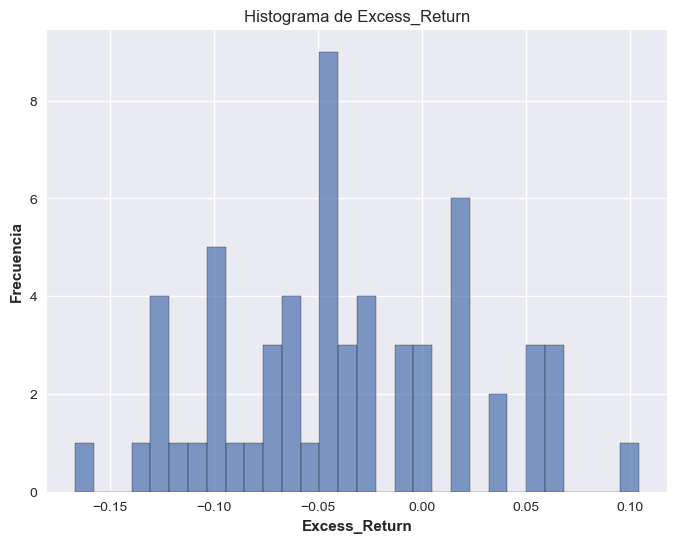

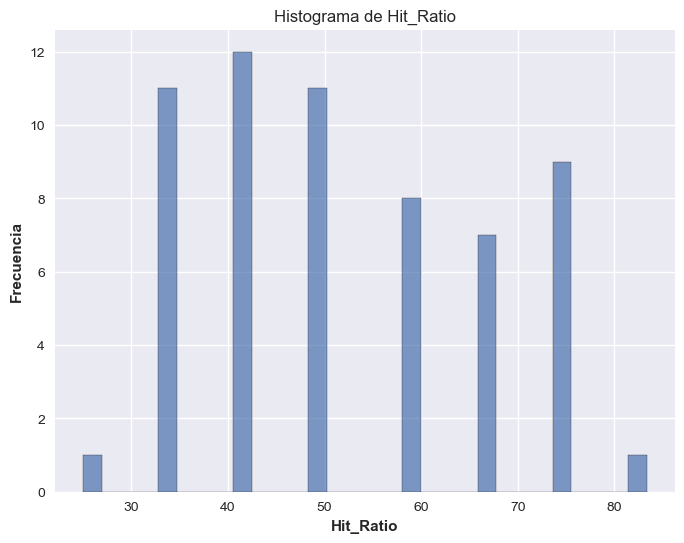

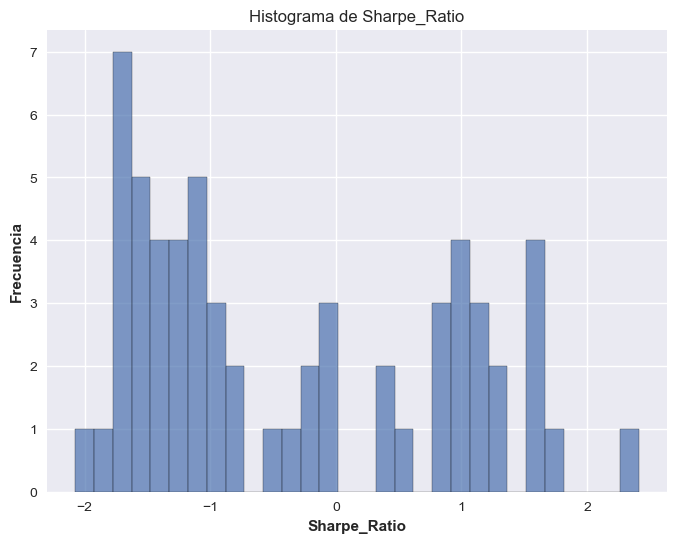

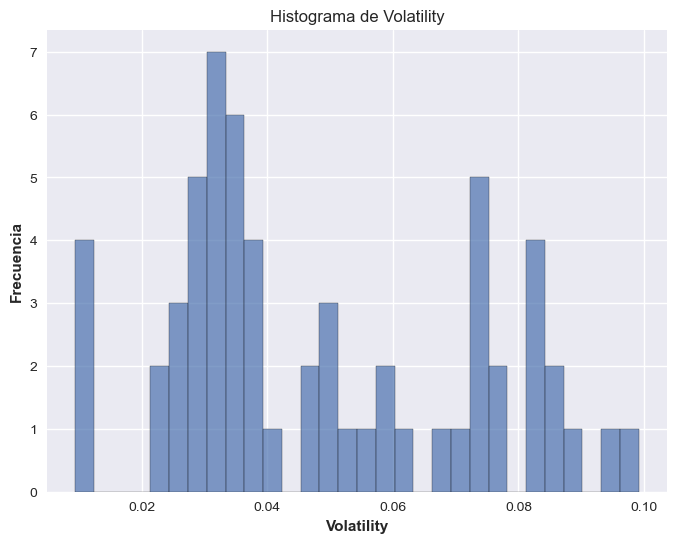

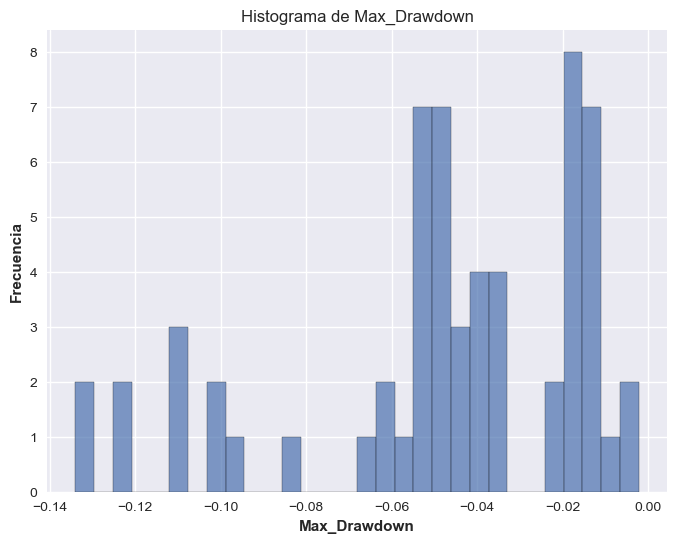

Modelo TSMixer: Métricas calculadas exitosamente.

Procesando modelo: TiDE
Longitud predicted_returns: 71
Longitud strategy_returns: 71
Longitud real_returns: 71


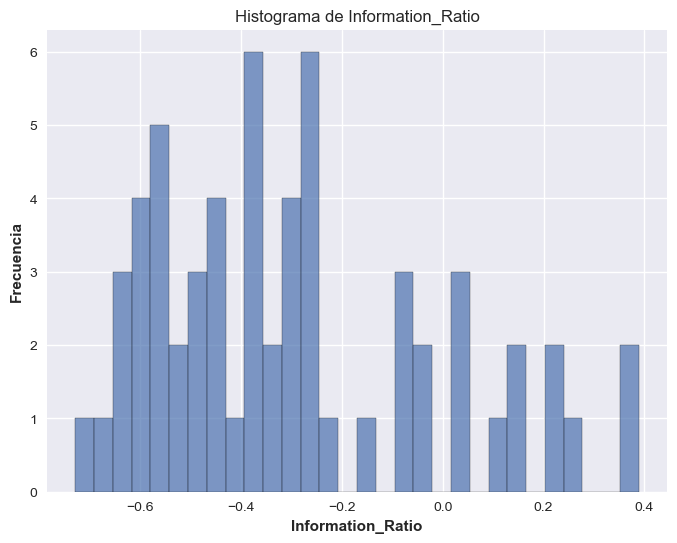

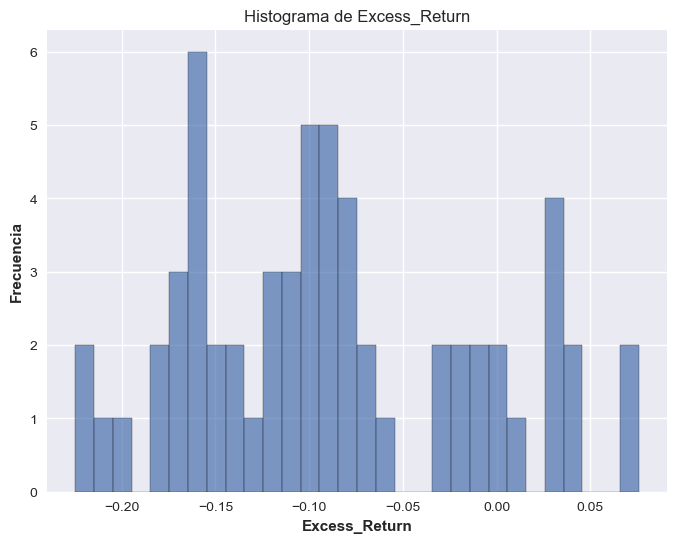

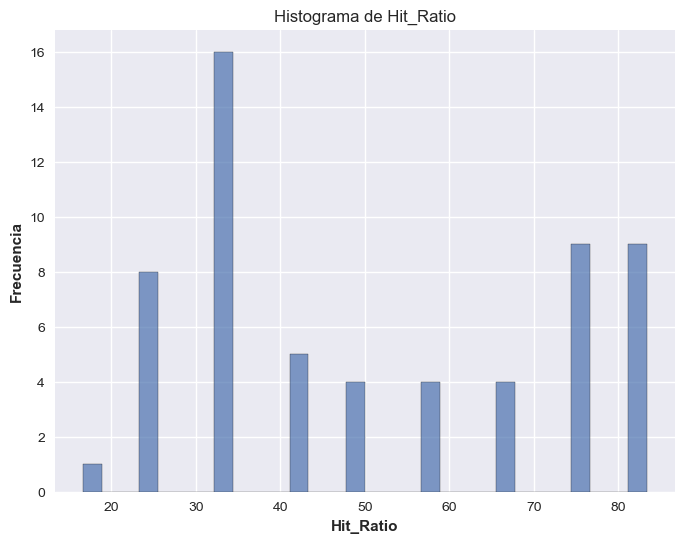

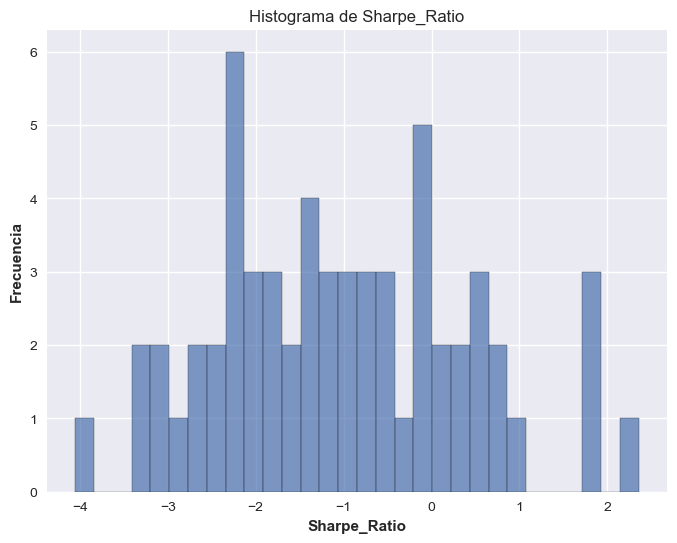

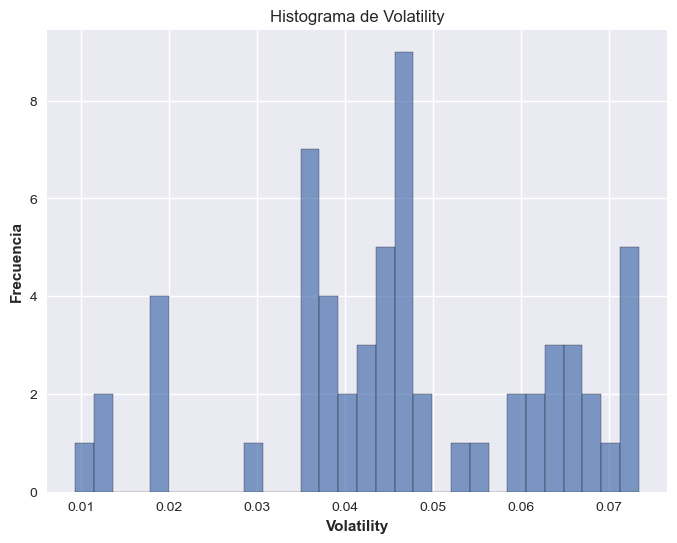

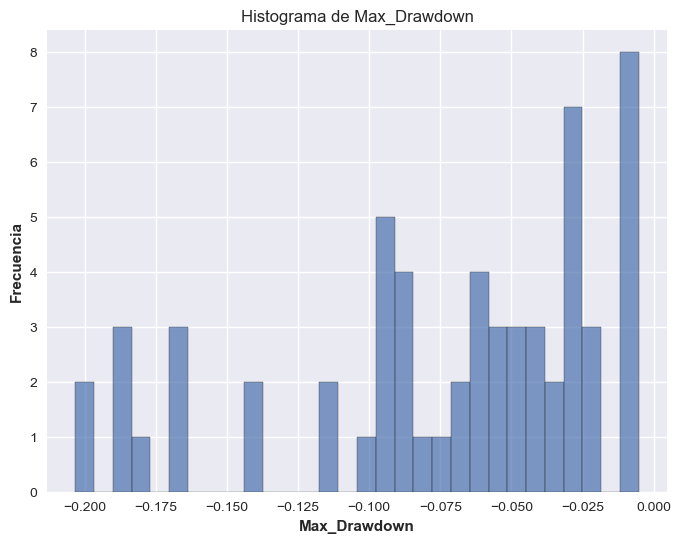

Modelo TiDE: Métricas calculadas exitosamente.

Procesando modelo: CatBoost
Longitud predicted_returns: 71
Longitud strategy_returns: 71
Longitud real_returns: 71


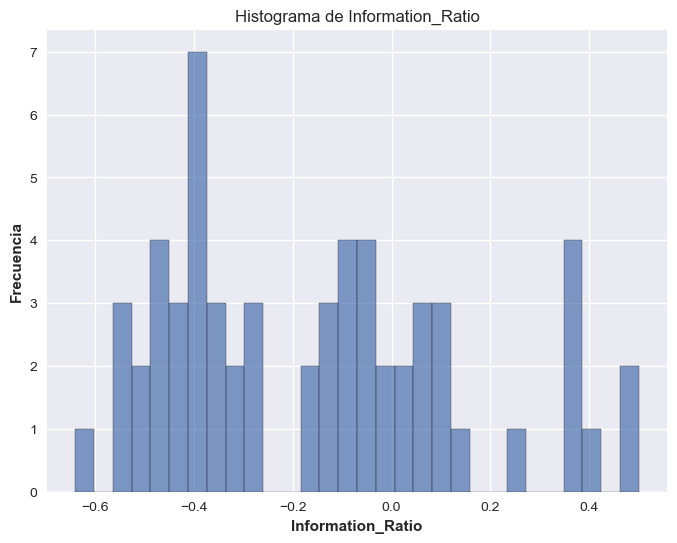

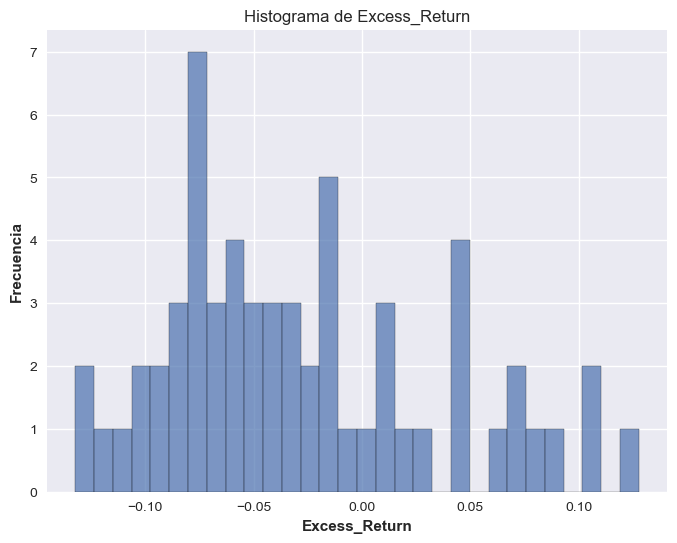

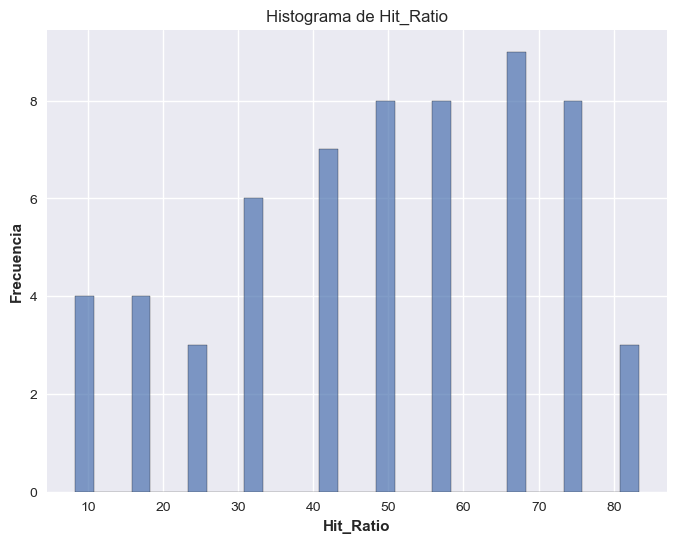

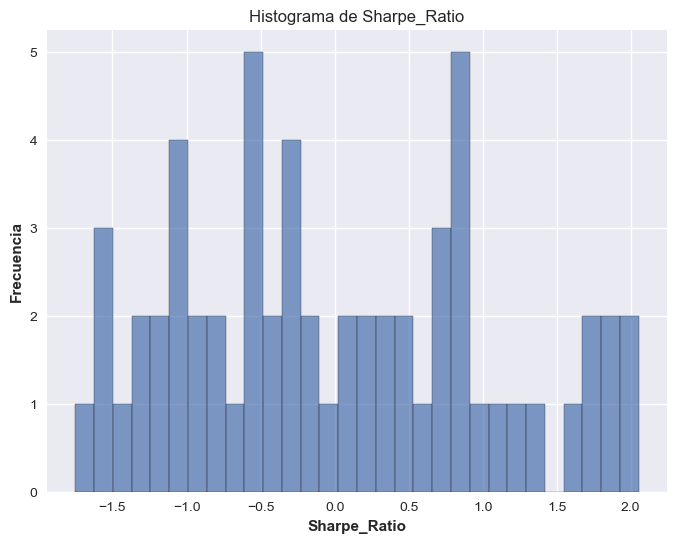

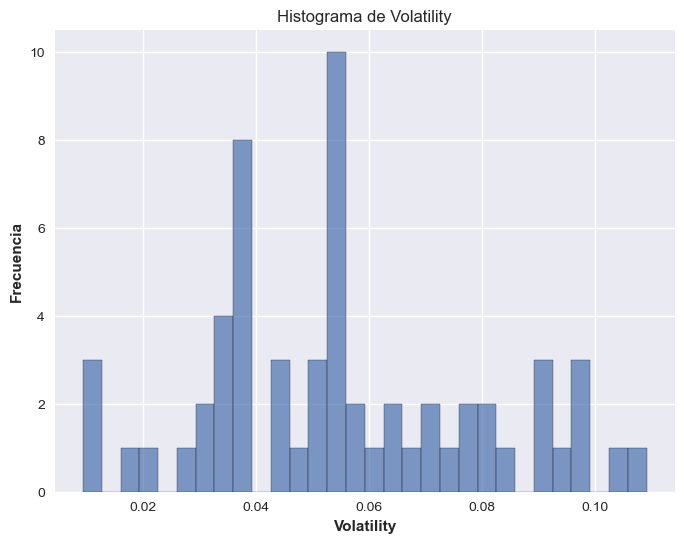

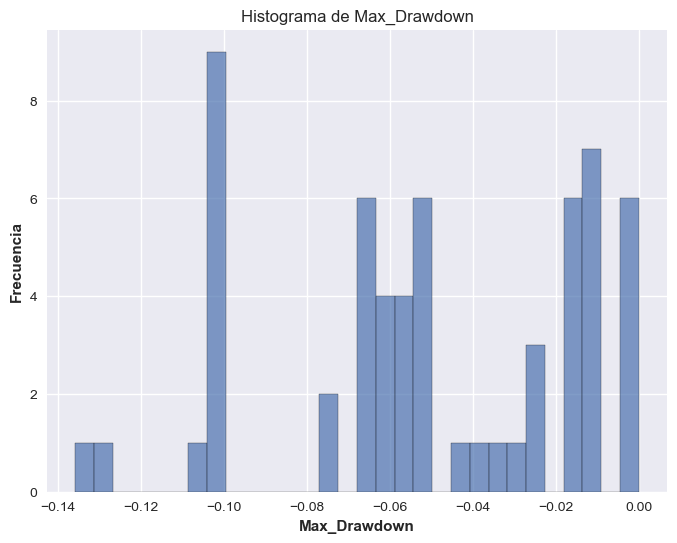

Modelo CatBoost: Métricas calculadas exitosamente.

Procesando modelo: LSTM
Longitud predicted_returns: 71
Longitud strategy_returns: 71
Longitud real_returns: 71


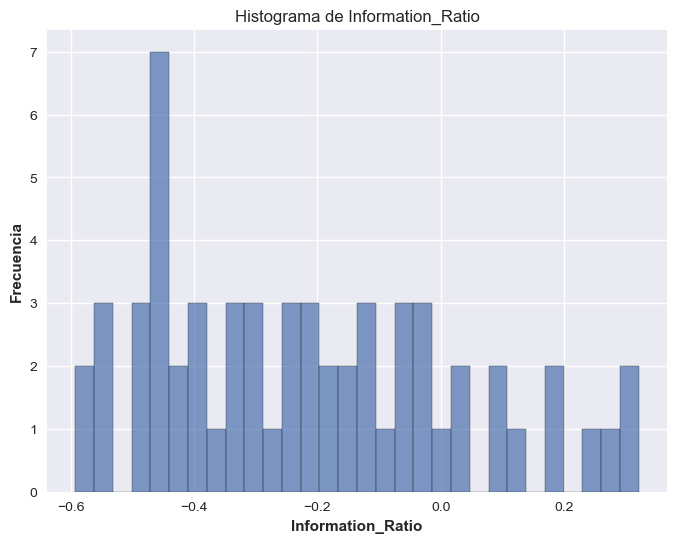

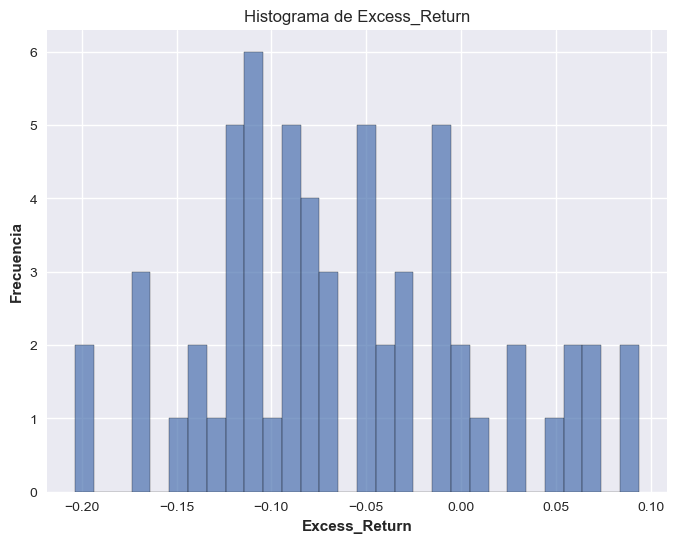

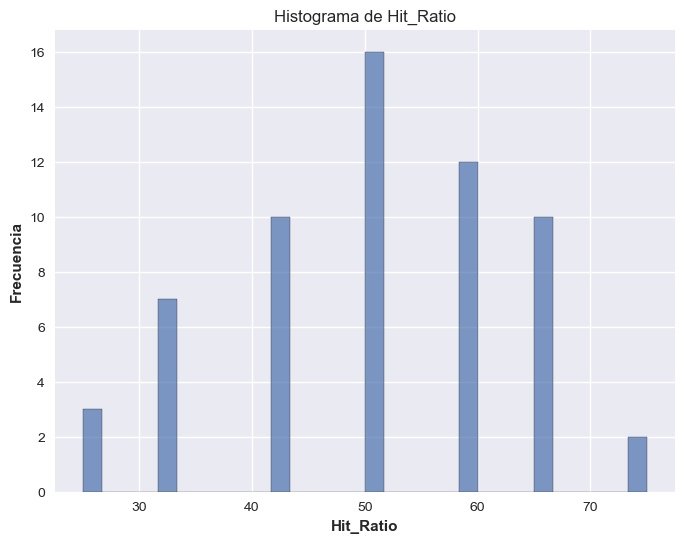

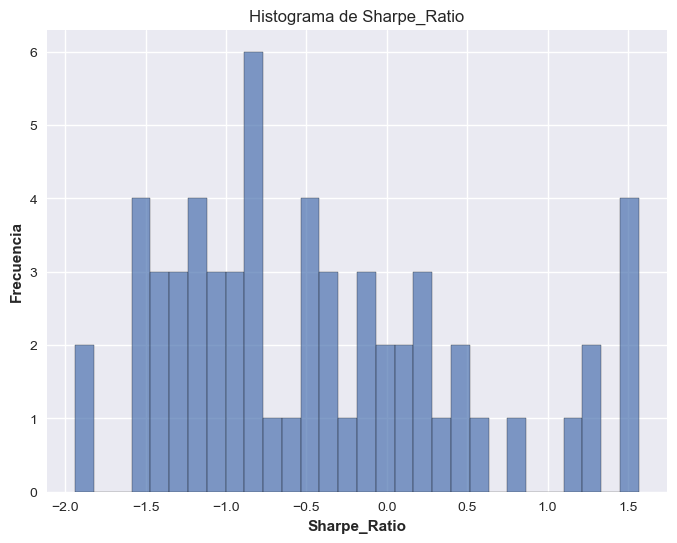

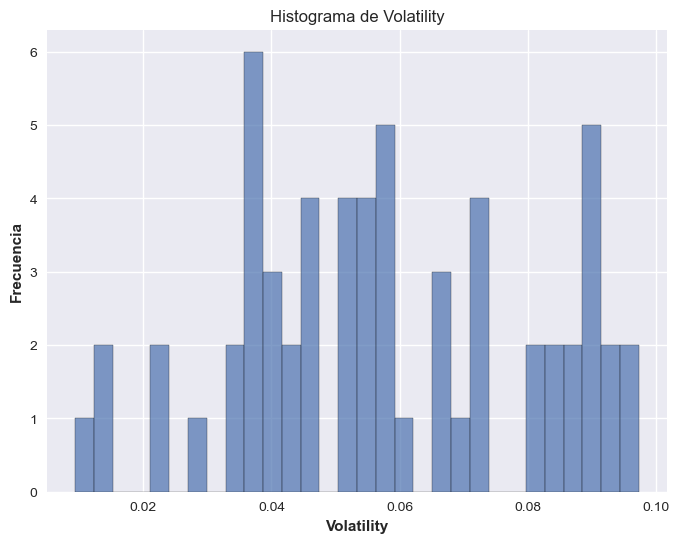

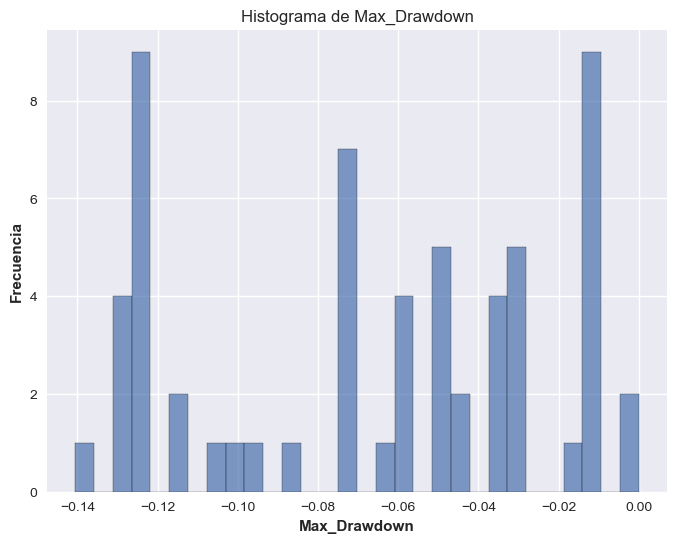

Modelo LSTM: Métricas calculadas exitosamente.

Procesando modelo: TimesFM
Longitud predicted_returns: 71
Longitud strategy_returns: 71
Longitud real_returns: 71


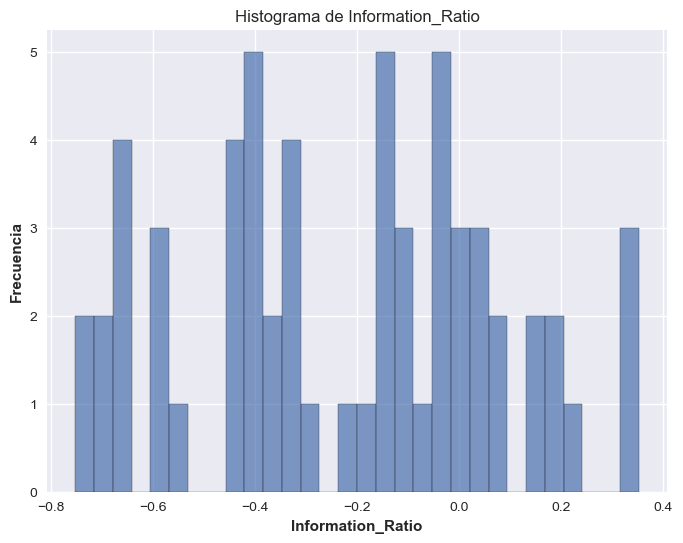

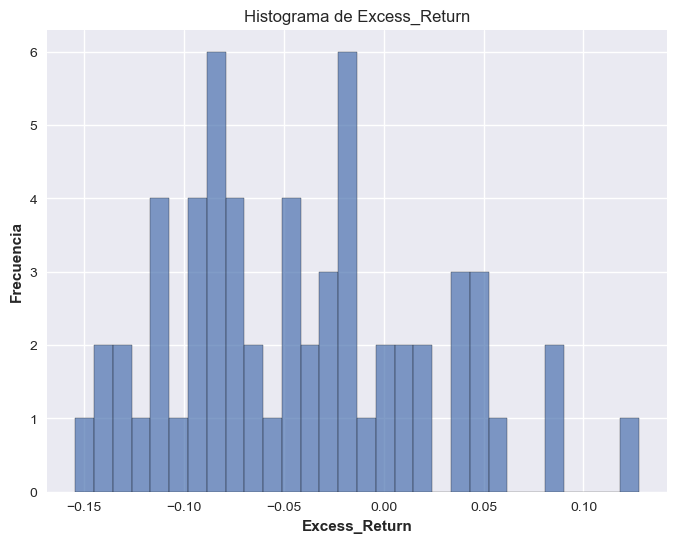

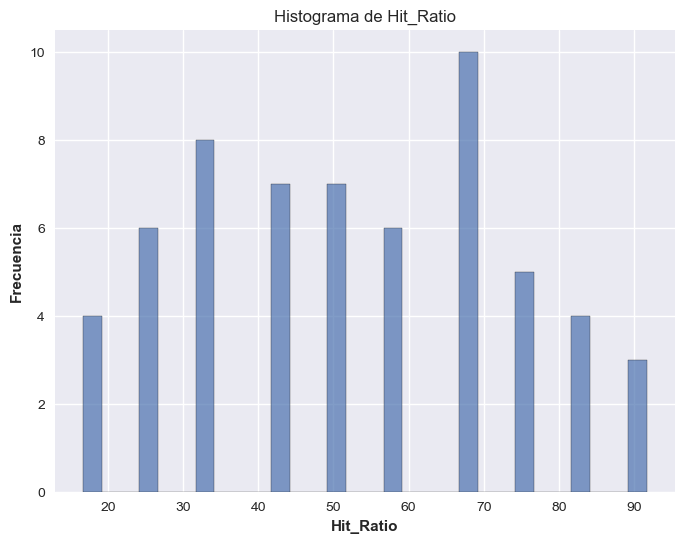

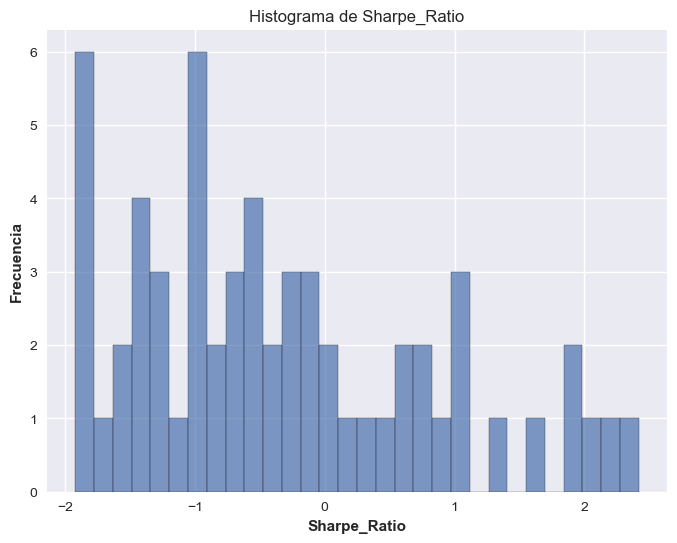

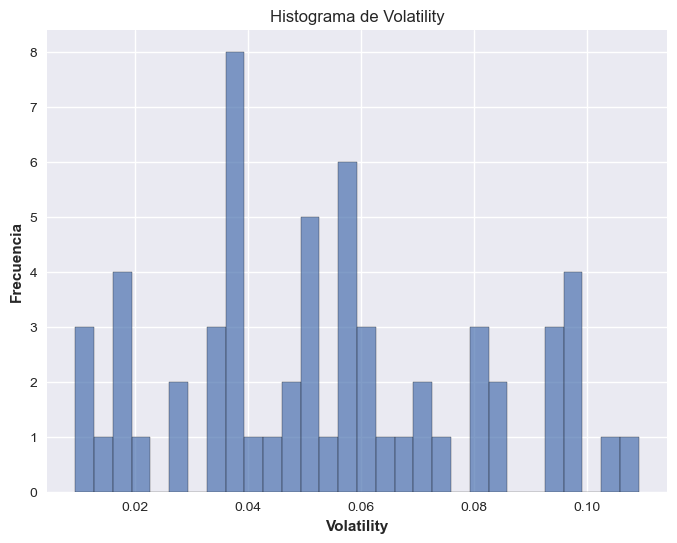

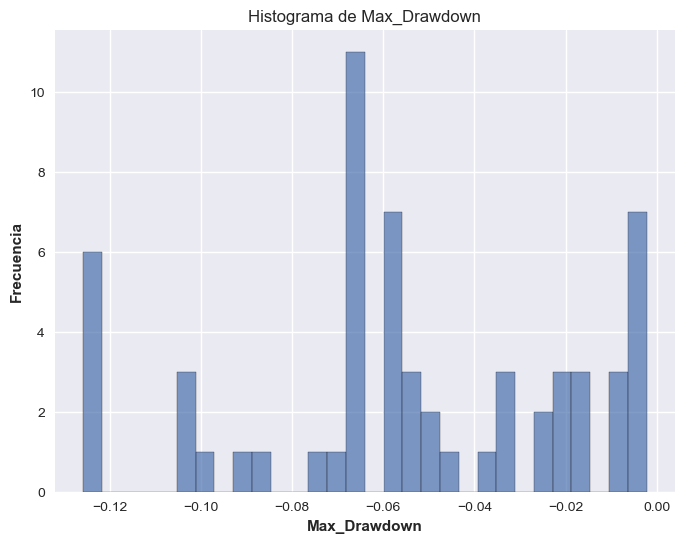

Modelo TimesFM: Métricas calculadas exitosamente.

Procesando modelo: Chronos
Longitud predicted_returns: 71
Longitud strategy_returns: 71
Longitud real_returns: 71


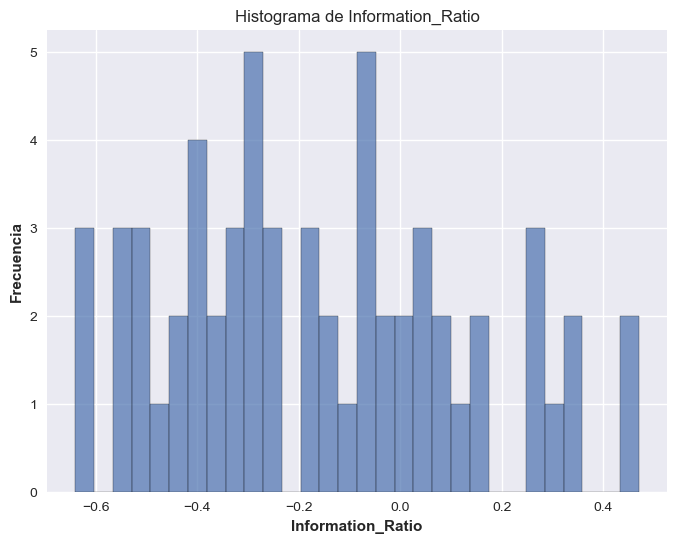

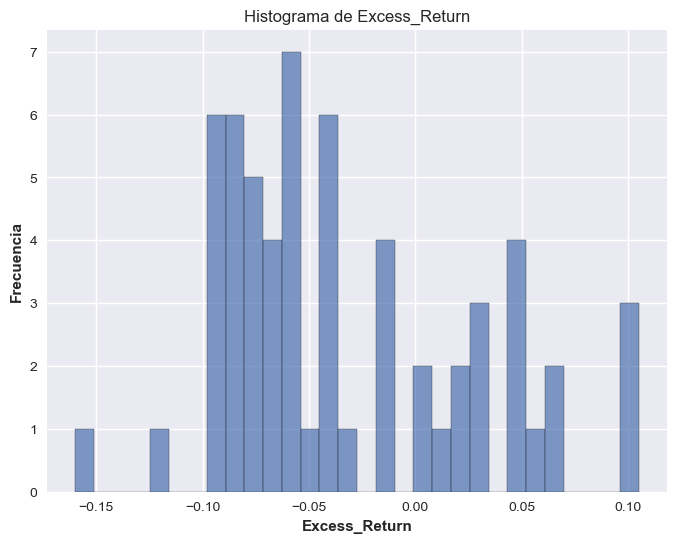

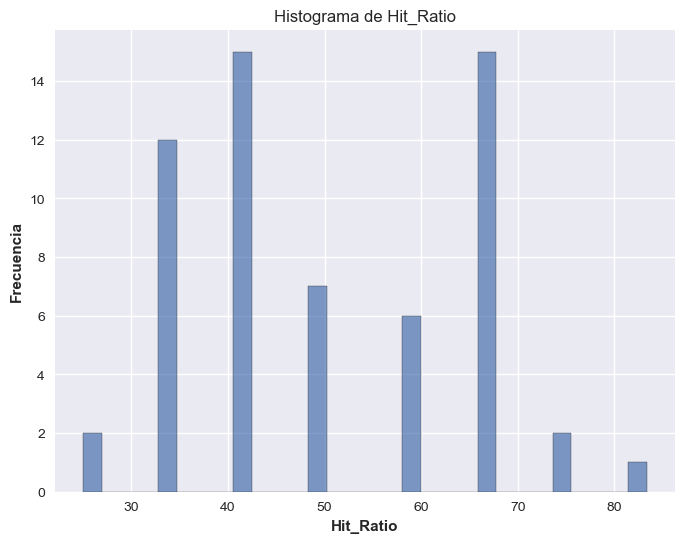

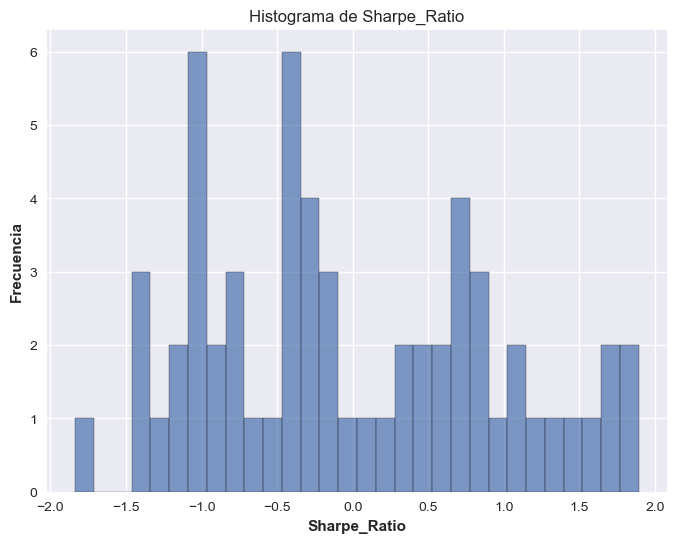

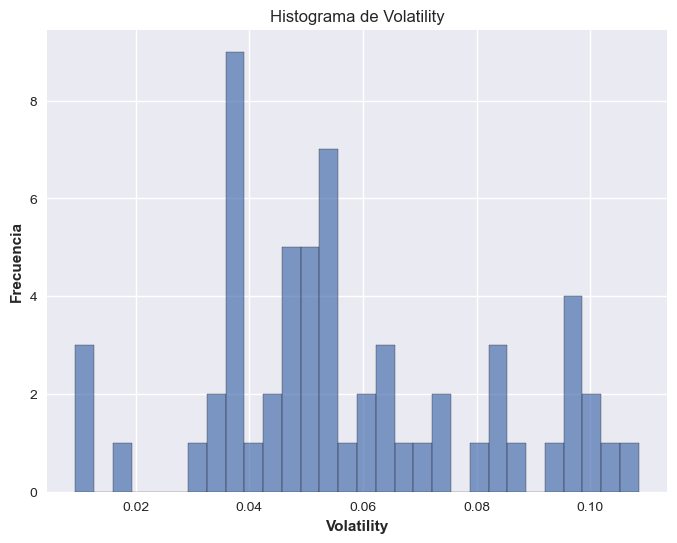

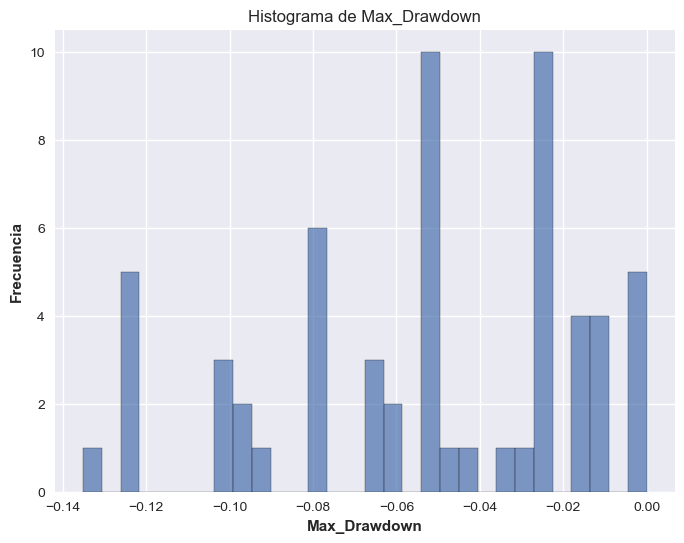

Modelo Chronos: Métricas calculadas exitosamente.

Procesando modelo: MOIRAI
Longitud predicted_returns: 71
Longitud strategy_returns: 71
Longitud real_returns: 71


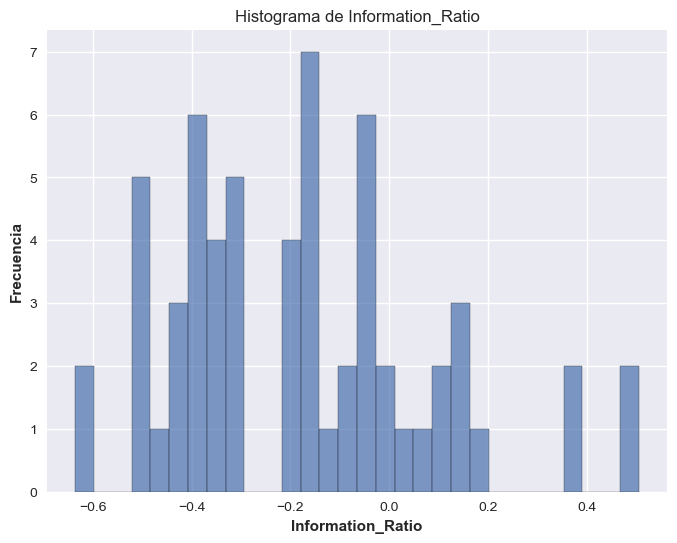

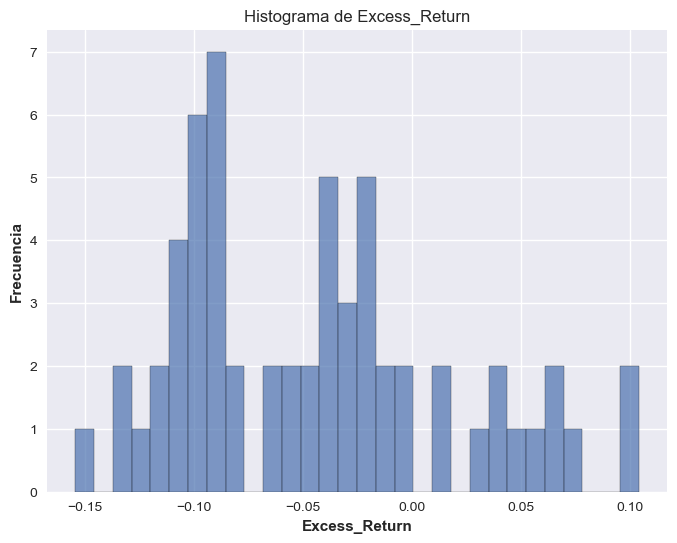

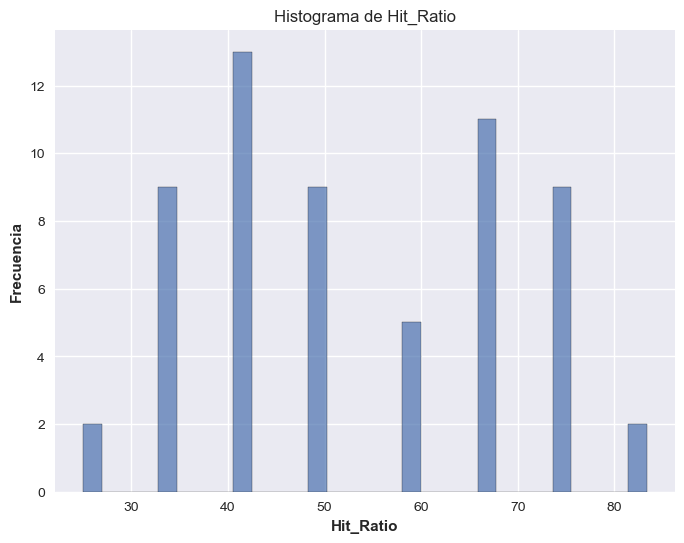

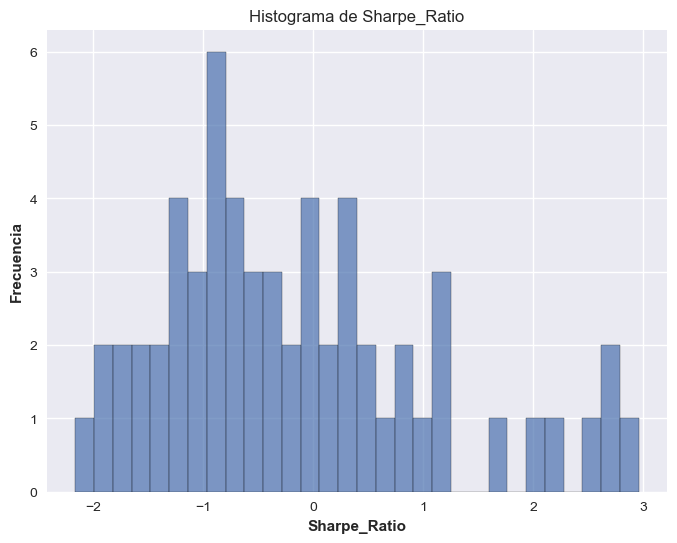

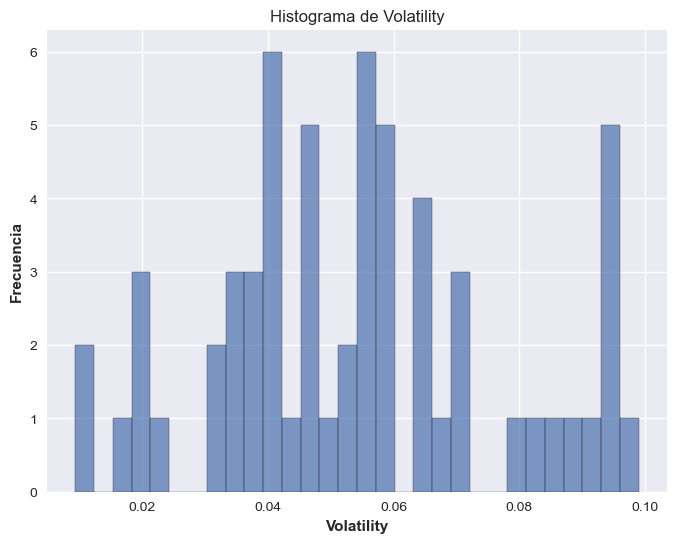

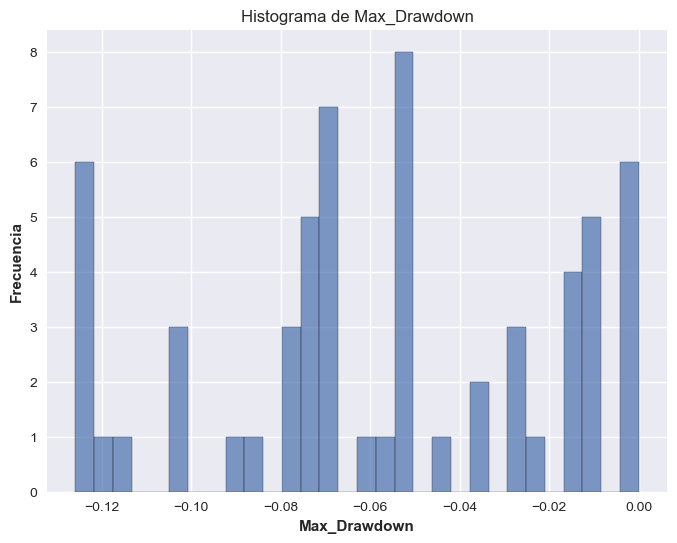

Modelo MOIRAI: Métricas calculadas exitosamente.

Resumen estadístico para el modelo NBEATS:



count       mean        std        min        25%  \
Information_Ratio   60.0  -0.296467   0.317591  -0.780191  -0.562158   
Excess_Return       60.0  -0.072241   0.066337  -0.169636  -0.120122   
Hit_Ratio           60.0  47.500000  14.660309  25.000000  33.333333   
Sharpe_Ratio        60.0  -0.828309   1.136118  -2.438557  -1.748550   
Volatility          60.0   0.048318   0.017962   0.009378   0.035132   
Max_Drawdown        60.0  -0.065873   0.041408  -0.150143  -0.091731   

                         50%        75%        max     median   CI_lower  \
Information_Ratio  -0.268065  -0.105644   0.463504  -0.268065  -0.376827   
Excess_Return      -0.097288  -0.035028   0.091740  -0.097288  -0.089026   
Hit_Ratio          41.666667  58.333333  75.000000  41.666667  43.790498   
Sharpe_Ratio       -1.169896  -0.057377   1.692557  -1.169896  -1.115781   
Volatility          0.044814   0.062257   0.080749   0.044814   0.043773   
Max_Drawdown       -0.063145  -0.032160  -0.009378  -0.063145  -0.076350   

                    CI_upper  
Information_Ratio  -0.216107  
Excess_Return      -0.055455  
Hit_Ratio          51.209502  
Sharpe_Ratio       -0.540837  
Volatility          0.052864  
Max_Drawdown       -0.055395

Resumen para NBEATS guardado en NBEATS_summary.csv

Resumen estadístico para el modelo NHITS:



count       mean        std        min        25%  \
Information_Ratio   60.0  -0.240836   0.194709  -0.579934  -0.397603   
Excess_Return       60.0  -0.071159   0.058684  -0.178165  -0.109721   
Hit_Ratio           60.0  46.388889  14.825306  16.666667  33.333333   
Sharpe_Ratio        60.0  -0.707058   1.349157  -2.417292  -1.666468   
Volatility          60.0   0.048297   0.015430   0.009378   0.039584   
Max_Drawdown        60.0  -0.064272   0.045478  -0.164361  -0.087917   

                         50%        75%        max     median   CI_lower  \
Information_Ratio  -0.290177  -0.132392   0.294494  -0.290177  -0.290103   
Excess_Return      -0.078413  -0.027454   0.060162  -0.078413  -0.086008   
Hit_Ratio          50.000000  58.333333  83.333333  50.000000  42.637638   
Sharpe_Ratio       -1.042211  -0.071221   2.749925  -1.042211  -1.048436   
Volatility          0.046939   0.057576   0.078427   0.046939   0.044393   
Max_Drawdown       -0.050948  -0.033941  -0.002994  -0.050948  -0.075780   

                    CI_upper  
Information_Ratio  -0.191568  
Excess_Return      -0.056310  
Hit_Ratio          50.140140  
Sharpe_Ratio       -0.365681  
Volatility          0.052201  
Max_Drawdown       -0.052765

Resumen para NHITS guardado en NHITS_summary.csv

Resumen estadístico para el modelo AutoARIMA:



count       mean        std        min        25%  \
Information_Ratio   60.0  -0.180874   0.278296  -0.606586  -0.420034   
Excess_Return       60.0  -0.038333   0.063379  -0.159901  -0.086553   
Hit_Ratio           60.0  51.805556  15.877627  25.000000  41.666667   
Sharpe_Ratio        60.0  -0.146305   1.074965  -1.945582  -0.891473   
Volatility          60.0   0.058883   0.023513   0.009378   0.039253   
Max_Drawdown        60.0  -0.058268   0.038564  -0.135185  -0.075967   

                         50%        75%        max     median   CI_lower  \
Information_Ratio  -0.166323   0.018365   0.470238  -0.166323  -0.251291   
Excess_Return      -0.046738   0.005831   0.116420  -0.046738  -0.054369   
Hit_Ratio          50.000000  66.666667  83.333333  50.000000  47.788036   
Sharpe_Ratio       -0.273675   0.605526   2.117992  -0.273675  -0.418304   
Volatility          0.056025   0.072980   0.108284   0.056025   0.052934   
Max_Drawdown       -0.060842  -0.023965   0.000000  -0.060842  -0.068026   

                    CI_upper  
Information_Ratio  -0.110456  
Excess_Return      -0.022296  
Hit_Ratio          55.823076  
Sharpe_Ratio        0.125693  
Volatility          0.064833  
Max_Drawdown       -0.048510

Resumen para AutoARIMA guardado en AutoARIMA_summary.csv

Resumen estadístico para el modelo TSMixer:



count       mean        std        min        25%  \
Information_Ratio   60.0  -0.182732   0.293854  -0.714143  -0.419126   
Excess_Return       60.0  -0.038081   0.059820  -0.166783  -0.077325   
Hit_Ratio           60.0  52.222222  15.100625  25.000000  41.666667   
Sharpe_Ratio        60.0  -0.363331   1.229520  -2.075223  -1.470751   
Volatility          60.0   0.048576   0.023964   0.009378   0.031294   
Max_Drawdown        60.0  -0.048475   0.035164  -0.133994  -0.054565   

                         50%        75%        max     median   CI_lower  \
Information_Ratio  -0.162638   0.008801   0.366673  -0.162638  -0.257086   
Excess_Return      -0.041650   0.003148   0.104303  -0.041650  -0.053218   
Hit_Ratio          50.000000  66.666667  83.333333  50.000000  48.401307   
Sharpe_Ratio       -0.902807   0.934928   2.411881  -0.902807  -0.674437   
Volatility          0.038187   0.074003   0.099181   0.038187   0.042513   
Max_Drawdown       -0.044778  -0.018462  -0.002240  -0.044778  -0.057373   

                    CI_upper  
Information_Ratio  -0.108378  
Excess_Return      -0.022945  
Hit_Ratio          56.043137  
Sharpe_Ratio       -0.052225  
Volatility          0.054640  
Max_Drawdown       -0.039578

Resumen para TSMixer guardado en TSMixer_summary.csv

Resumen estadístico para el modelo TiDE:



count       mean        std        min        25%  \
Information_Ratio   60.0  -0.293373   0.283328  -0.729071  -0.523494   
Excess_Return       60.0  -0.087860   0.077432  -0.224813  -0.147534   
Hit_Ratio           60.0  51.388889  21.707191  16.666667  33.333333   
Sharpe_Ratio        60.0  -1.027185   1.439145  -4.051849  -2.178656   
Volatility          60.0   0.046718   0.016459   0.009378   0.037139   
Max_Drawdown        60.0  -0.074335   0.057541  -0.203351  -0.096732   

                         50%        75%        max     median   CI_lower  \
Information_Ratio  -0.350572  -0.074405   0.389116  -0.350572  -0.365063   
Excess_Return      -0.101793  -0.024672   0.075908  -0.101793  -0.107453   
Hit_Ratio          45.833333  75.000000  83.333333  45.833333  45.896313   
Sharpe_Ratio       -1.161440  -0.064662   2.357934  -1.161440  -1.391332   
Volatility          0.046018   0.061301   0.073401   0.046018   0.042553   
Max_Drawdown       -0.061464  -0.026257  -0.005228  -0.061464  -0.088895   

                    CI_upper  
Information_Ratio  -0.221683  
Excess_Return      -0.068267  
Hit_Ratio          56.881465  
Sharpe_Ratio       -0.663038  
Volatility          0.050882  
Max_Drawdown       -0.059776

Resumen para TiDE guardado en TiDE_summary.csv

Resumen estadístico para el modelo CatBoost:



count       mean        std       min        25%  \
Information_Ratio   60.0  -0.154583   0.296834 -0.640219  -0.395662   
Excess_Return       60.0  -0.027508   0.063100 -0.132322  -0.075517   
Hit_Ratio           60.0  49.722222  21.313211  8.333333  33.333333   
Sharpe_Ratio        60.0   0.007833   1.036581 -1.751636  -0.788925   
Volatility          60.0   0.055668   0.024654  0.009378   0.038150   
Max_Drawdown        60.0  -0.050154   0.036729 -0.135855  -0.067354   

                         50%        75%        max     median   CI_lower  \
Information_Ratio  -0.151937   0.039432   0.500462  -0.151937  -0.229691   
Excess_Return      -0.039169   0.012603   0.127695  -0.039169  -0.043474   
Hit_Ratio          50.000000  66.666667  83.333333  50.000000  44.329335   
Sharpe_Ratio       -0.200451   0.796304   2.055058  -0.200451  -0.254453   
Volatility          0.053656   0.071618   0.109192   0.053656   0.049430   
Max_Drawdown       -0.052189  -0.015612   0.000000  -0.052189  -0.059447   

                    CI_upper  
Information_Ratio  -0.079475  
Excess_Return      -0.011541  
Hit_Ratio          55.115110  
Sharpe_Ratio        0.270119  
Volatility          0.061906  
Max_Drawdown       -0.040860

Resumen para CatBoost guardado en CatBoost_summary.csv

Resumen estadístico para el modelo LSTM:



count       mean        std        min        25%  \
Information_Ratio   60.0  -0.214548   0.246772  -0.592733  -0.429173   
Excess_Return       60.0  -0.061232   0.071606  -0.203388  -0.112448   
Hit_Ratio           60.0  50.694444  12.586019  25.000000  41.666667   
Sharpe_Ratio        60.0  -0.431877   0.932329  -1.937122  -1.202069   
Volatility          60.0   0.057767   0.023190   0.009378   0.039376   
Max_Drawdown        60.0  -0.066030   0.043584  -0.140567  -0.113899   

                         50%        75%        max     median   CI_lower  \
Information_Ratio  -0.234940  -0.049228   0.321174  -0.234940  -0.276989   
Excess_Return      -0.074992  -0.012230   0.093685  -0.074992  -0.079350   
Hit_Ratio          50.000000  58.333333  75.000000  50.000000  47.509801   
Sharpe_Ratio       -0.528008   0.129376   1.567977  -0.528008  -0.667785   
Volatility          0.055754   0.075572   0.097314   0.055754   0.051900   
Max_Drawdown       -0.058456  -0.031760   0.000000  -0.058456  -0.077058   

                    CI_upper  
Information_Ratio  -0.152107  
Excess_Return      -0.043113  
Hit_Ratio          53.879088  
Sharpe_Ratio       -0.195969  
Volatility          0.063635  
Max_Drawdown       -0.055002

Resumen para LSTM guardado en LSTM_summary.csv

Resumen estadístico para el modelo TimesFM:



count       mean        std        min        25%  \
Information_Ratio   60.0  -0.226060   0.299401  -0.752818  -0.445019   
Excess_Return       60.0  -0.042021   0.063963  -0.154316  -0.087736   
Hit_Ratio           60.0  52.083333  21.238989  16.666667  33.333333   
Sharpe_Ratio        60.0  -0.321255   1.170557  -1.921949  -1.246970   
Volatility          60.0   0.054395   0.027074   0.009378   0.036727   
Max_Drawdown        60.0  -0.054570   0.036730  -0.125907  -0.067354   

                         50%        75%        max     median   CI_lower  \
Information_Ratio  -0.166323  -0.009797   0.351691  -0.166323  -0.301817   
Excess_Return      -0.045687  -0.001530   0.127695  -0.045687  -0.058205   
Hit_Ratio          50.000000  66.666667  91.666667  50.000000  46.709226   
Sharpe_Ratio       -0.528662   0.436099   2.419575  -0.528662  -0.617441   
Volatility          0.051924   0.072377   0.109192   0.051924   0.047544   
Max_Drawdown       -0.057493  -0.021114  -0.002240  -0.057493  -0.063864   

                    CI_upper  
Information_Ratio  -0.150302  
Excess_Return      -0.025837  
Hit_Ratio          57.457440  
Sharpe_Ratio       -0.025069  
Volatility          0.061245  
Max_Drawdown       -0.045276

Resumen para TimesFM guardado en TimesFM_summary.csv

Resumen estadístico para el modelo Chronos:



count       mean        std        min        25%  \
Information_Ratio   60.0  -0.161150   0.288361  -0.640219  -0.383750   
Excess_Return       60.0  -0.032590   0.060328  -0.159901  -0.079096   
Hit_Ratio           60.0  50.138889  14.595267  25.000000  41.666667   
Sharpe_Ratio        60.0  -0.012090   0.969036  -1.836312  -0.833379   
Volatility          60.0   0.057705   0.024267   0.009378   0.038929   
Max_Drawdown        60.0  -0.052649   0.038018  -0.135185  -0.077871   

                         50%        75%        max     median   CI_lower  \
Information_Ratio  -0.166323   0.031166   0.470238  -0.166323  -0.234114   
Excess_Return      -0.053325   0.012225   0.105144  -0.053325  -0.047855   
Hit_Ratio          50.000000  66.666667  83.333333  50.000000  46.445845   
Sharpe_Ratio       -0.200336   0.742800   1.894010  -0.200336  -0.257285   
Volatility          0.053656   0.073270   0.108546   0.053656   0.051565   
Max_Drawdown       -0.050640  -0.023965   0.000000  -0.050640  -0.062269   

                    CI_upper  
Information_Ratio  -0.088186  
Excess_Return      -0.017325  
Hit_Ratio          53.831933  
Sharpe_Ratio        0.233106  
Volatility          0.063846  
Max_Drawdown       -0.043030

Resumen para Chronos guardado en Chronos_summary.csv

Resumen estadístico para el modelo MOIRAI:



count       mean        std        min        25%  \
Information_Ratio   60.0  -0.176101   0.263907  -0.635311  -0.382722   
Excess_Return       60.0  -0.044455   0.062136  -0.154316  -0.094636   
Hit_Ratio           60.0  53.472222  16.039886  25.000000  41.666667   
Sharpe_Ratio        60.0  -0.139276   1.249408  -2.165809  -1.000000   
Volatility          60.0   0.054183   0.023040   0.009378   0.039640   
Max_Drawdown        60.0  -0.056902   0.038990  -0.125907  -0.076583   

                         50%        75%        max     median   CI_lower  \
Information_Ratio  -0.176436  -0.035141   0.504712  -0.176436  -0.242878   
Excess_Return      -0.048688  -0.015921   0.104002  -0.048688  -0.060178   
Hit_Ratio          50.000000  66.666667  83.333333  50.000000  49.413646   
Sharpe_Ratio       -0.367373   0.528724   2.958966  -0.367373  -0.455414   
Volatility          0.054266   0.066346   0.099014   0.054266   0.048354   
Max_Drawdown       -0.055115  -0.022070   0.000000  -0.055115  -0.066767   

                    CI_upper  
Information_Ratio  -0.109325  
Excess_Return      -0.028733  
Hit_Ratio          57.530799  
Sharpe_Ratio        0.176862  
Volatility          0.060013  
Max_Drawdown       -0.047036

Resumen para MOIRAI guardado en MOIRAI_summary.csv


In [234]:
# Loop para calcular métricas rolling y su análisis estadístico
all_rolling_metrics = {}
all_summaries = {}

for model_name in model_list:
    print(f"\nProcesando modelo: {model_name}")
    try:
        # Obtener retornos predichos y estrategia del modelo
        predicted_returns = all_returns_with_retrain[model_name]
        strategy_returns = strategies_panel[f"{model_name}_strategy"]  # Corregido aquí

        if not isinstance(predicted_returns, pd.Series):
            predicted_returns = pd.Series(predicted_returns, index=real_returns.index)
        if not isinstance(strategy_returns, pd.Series):
            strategy_returns = pd.Series(strategy_returns, index=real_returns.index)

        # Verificar datos
        print(f"Longitud predicted_returns: {len(predicted_returns)}")
        print(f"Longitud strategy_returns: {len(strategy_returns)}")
        print(f"Longitud real_returns: {len(real_returns)}")

        # Alinear índices
        aligned_index = predicted_returns.index.intersection(real_returns.index)
        predicted_returns = predicted_returns[aligned_index]
        strategy_returns = strategy_returns[aligned_index]
        real_returns_aligned = real_returns[aligned_index]

        # Calcular métricas rolling
        rolling_metrics = RollingAnalyzer.calculate_strategy_consistency(
            real_returns=real_returns_aligned,
            predicted_returns=predicted_returns,
            strategy_returns=strategy_returns,
            window=12,
        )

        # Almacenar resultados
        all_rolling_metrics[model_name] = rolling_metrics

        # Analizar consistencia estadística
        summary = analyze_rolling_statistics(rolling_metrics)
        all_summaries[model_name] = summary

        print(f"Modelo {model_name}: Métricas calculadas exitosamente.")

    except Exception as e:
        print(f"Error procesando modelo {model_name}: {str(e)}")
        import traceback

        print(traceback.format_exc())

# Mostrar resúmenes para todos los modelos
for model_name, summary in all_summaries.items():
    print(f"\nResumen estadístico para el modelo {model_name}:\n")
    display(summary)  # Usa el método nativo de Jupyter o IPython para mostrar tablas

    # Si quieres guardar los resúmenes en archivos CSV
    summary.to_csv(f"{model_name}_summary.csv", index=False)
    print(f"Resumen para {model_name} guardado en {model_name}_summary.csv")

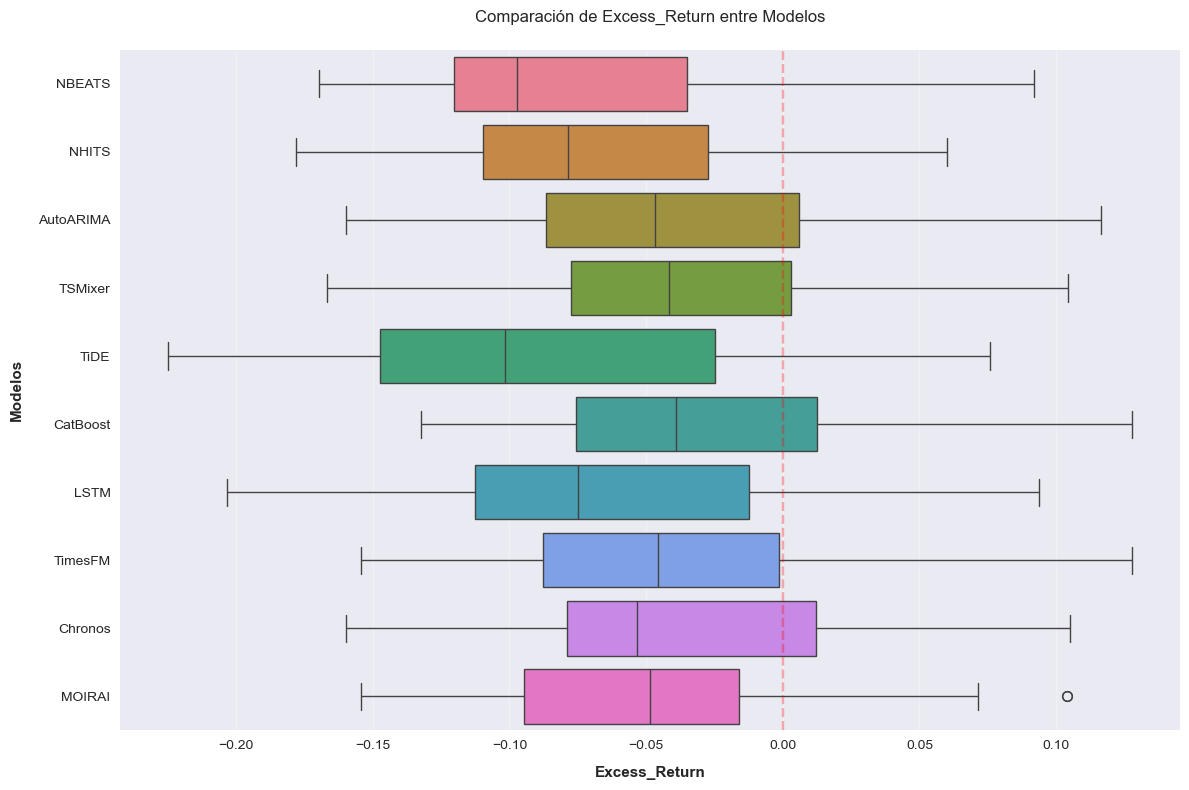


Estadísticas para Excess_Return:
        NBEATS    NHITS  AutoARIMA  TSMixer     TiDE  CatBoost     LSTM  \
count  60.0000  60.0000    60.0000  60.0000  60.0000   60.0000  60.0000   
mean   -0.0722  -0.0712    -0.0383  -0.0381  -0.0879   -0.0275  -0.0612   
std     0.0663   0.0587     0.0634   0.0598   0.0774    0.0631   0.0716   
min    -0.1696  -0.1782    -0.1599  -0.1668  -0.2248   -0.1323  -0.2034   
25%    -0.1201  -0.1097    -0.0866  -0.0773  -0.1475   -0.0755  -0.1124   
50%    -0.0973  -0.0784    -0.0467  -0.0416  -0.1018   -0.0392  -0.0750   
75%    -0.0350  -0.0275     0.0058   0.0031  -0.0247    0.0126  -0.0122   
max     0.0917   0.0602     0.1164   0.1043   0.0759    0.1277   0.0937   

       TimesFM  Chronos   MOIRAI  
count  60.0000  60.0000  60.0000  
mean   -0.0420  -0.0326  -0.0445  
std     0.0640   0.0603   0.0621  
min    -0.1543  -0.1599  -0.1543  
25%    -0.0877  -0.0791  -0.0946  
50%    -0.0457  -0.0533  -0.0487  
75%    -0.0015   0.0122  -0.0159  
max     0.

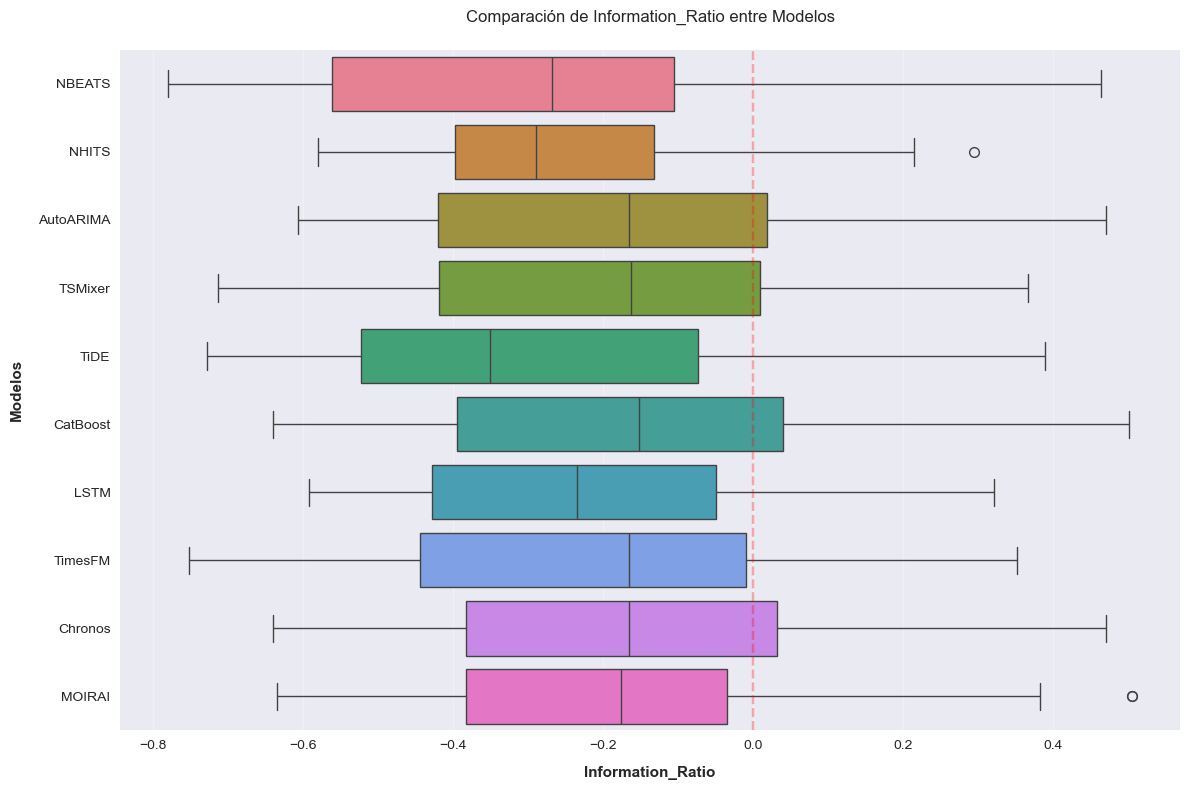


Estadísticas para Information_Ratio:
        NBEATS    NHITS  AutoARIMA  TSMixer     TiDE  CatBoost     LSTM  \
count  60.0000  60.0000    60.0000  60.0000  60.0000   60.0000  60.0000   
mean   -0.2965  -0.2408    -0.1809  -0.1827  -0.2934   -0.1546  -0.2145   
std     0.3176   0.1947     0.2783   0.2939   0.2833    0.2968   0.2468   
min    -0.7802  -0.5799    -0.6066  -0.7141  -0.7291   -0.6402  -0.5927   
25%    -0.5622  -0.3976    -0.4200  -0.4191  -0.5235   -0.3957  -0.4292   
50%    -0.2681  -0.2902    -0.1663  -0.1626  -0.3506   -0.1519  -0.2349   
75%    -0.1056  -0.1324     0.0184   0.0088  -0.0744    0.0394  -0.0492   
max     0.4635   0.2945     0.4702   0.3667   0.3891    0.5005   0.3212   

       TimesFM  Chronos   MOIRAI  
count  60.0000  60.0000  60.0000  
mean   -0.2261  -0.1612  -0.1761  
std     0.2994   0.2884   0.2639  
min    -0.7528  -0.6402  -0.6353  
25%    -0.4450  -0.3838  -0.3827  
50%    -0.1663  -0.1663  -0.1764  
75%    -0.0098   0.0312  -0.0351  
max   

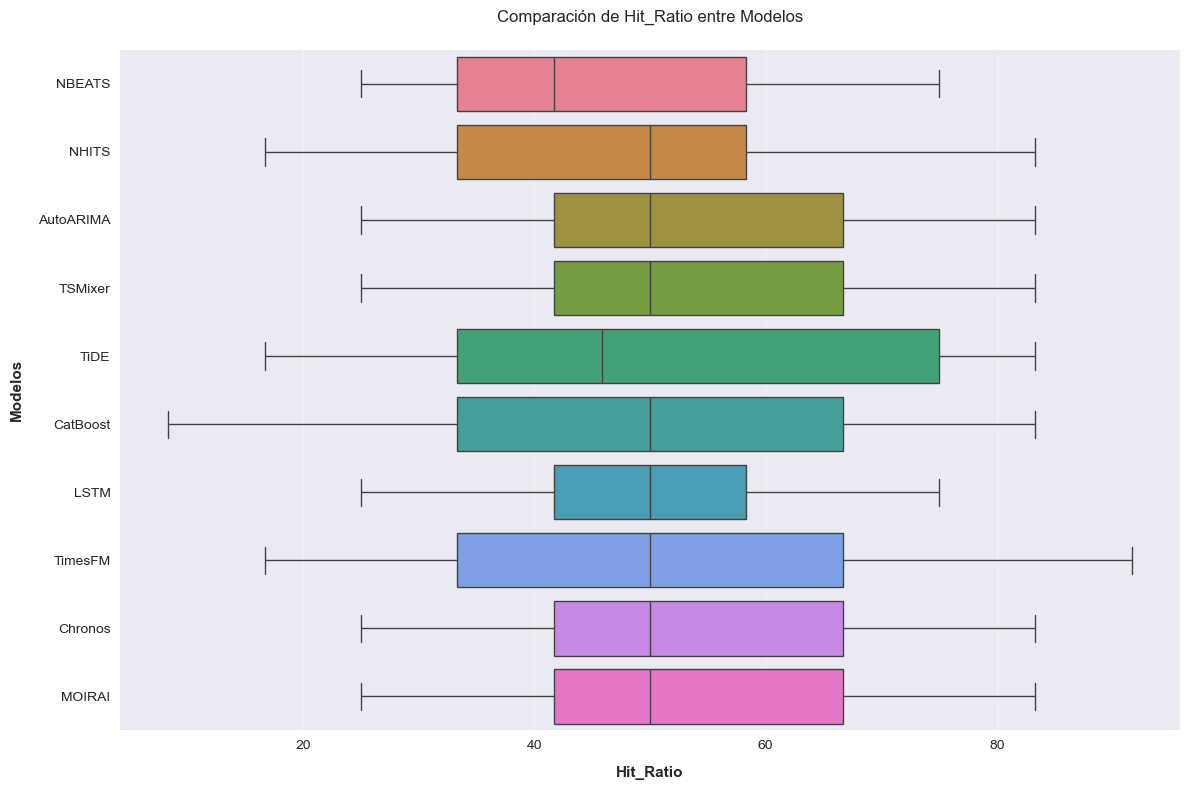


Estadísticas para Hit_Ratio:
        NBEATS    NHITS  AutoARIMA  TSMixer     TiDE  CatBoost     LSTM  \
count  60.0000  60.0000    60.0000  60.0000  60.0000   60.0000  60.0000   
mean   47.5000  46.3889    51.8056  52.2222  51.3889   49.7222  50.6944   
std    14.6603  14.8253    15.8776  15.1006  21.7072   21.3132  12.5860   
min    25.0000  16.6667    25.0000  25.0000  16.6667    8.3333  25.0000   
25%    33.3333  33.3333    41.6667  41.6667  33.3333   33.3333  41.6667   
50%    41.6667  50.0000    50.0000  50.0000  45.8333   50.0000  50.0000   
75%    58.3333  58.3333    66.6667  66.6667  75.0000   66.6667  58.3333   
max    75.0000  83.3333    83.3333  83.3333  83.3333   83.3333  75.0000   

       TimesFM  Chronos   MOIRAI  
count  60.0000  60.0000  60.0000  
mean   52.0833  50.1389  53.4722  
std    21.2390  14.5953  16.0399  
min    16.6667  25.0000  25.0000  
25%    33.3333  41.6667  41.6667  
50%    50.0000  50.0000  50.0000  
75%    66.6667  66.6667  66.6667  
max    91.6667

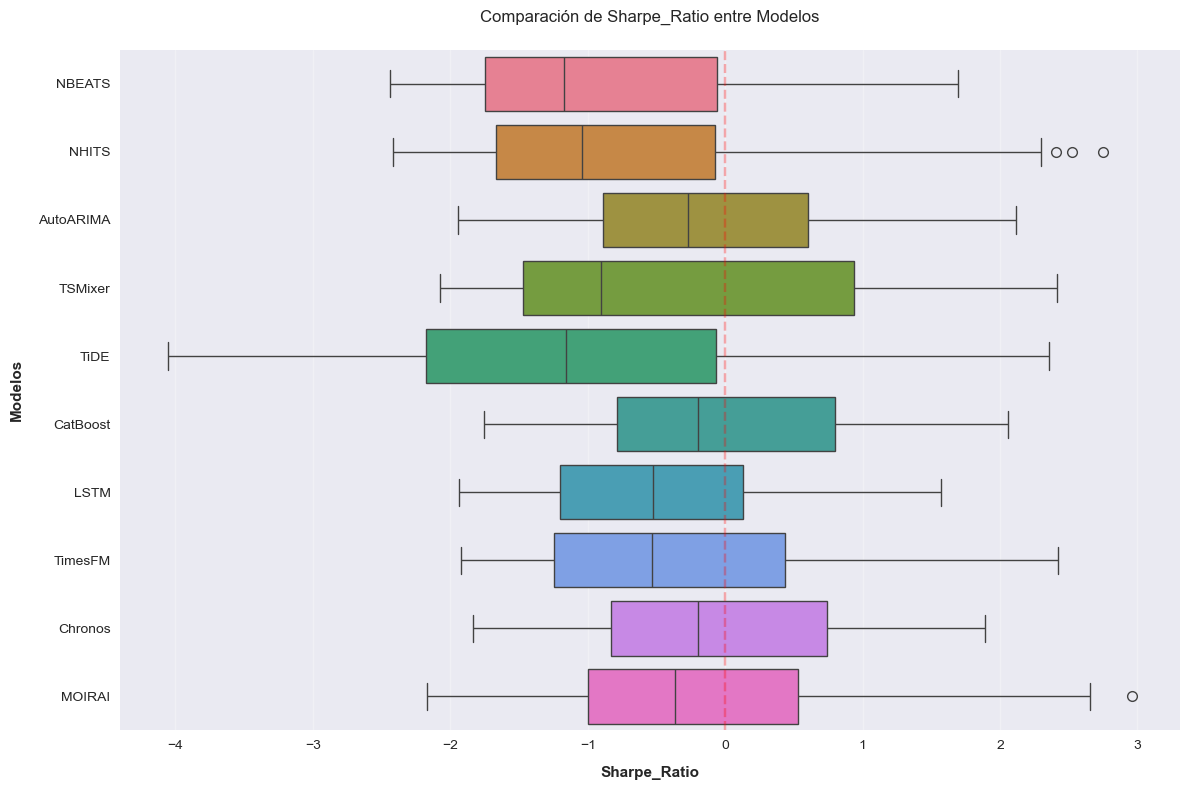


Estadísticas para Sharpe_Ratio:
        NBEATS    NHITS  AutoARIMA  TSMixer     TiDE  CatBoost     LSTM  \
count  60.0000  60.0000    60.0000  60.0000  60.0000   60.0000  60.0000   
mean   -0.8283  -0.7071    -0.1463  -0.3633  -1.0272    0.0078  -0.4319   
std     1.1361   1.3492     1.0750   1.2295   1.4391    1.0366   0.9323   
min    -2.4386  -2.4173    -1.9456  -2.0752  -4.0518   -1.7516  -1.9371   
25%    -1.7485  -1.6665    -0.8915  -1.4708  -2.1787   -0.7889  -1.2021   
50%    -1.1699  -1.0422    -0.2737  -0.9028  -1.1614   -0.2005  -0.5280   
75%    -0.0574  -0.0712     0.6055   0.9349  -0.0647    0.7963   0.1294   
max     1.6926   2.7499     2.1180   2.4119   2.3579    2.0551   1.5680   

       TimesFM  Chronos   MOIRAI  
count  60.0000  60.0000  60.0000  
mean   -0.3213  -0.0121  -0.1393  
std     1.1706   0.9690   1.2494  
min    -1.9219  -1.8363  -2.1658  
25%    -1.2470  -0.8334  -1.0000  
50%    -0.5287  -0.2003  -0.3674  
75%     0.4361   0.7428   0.5287  
max     2.4

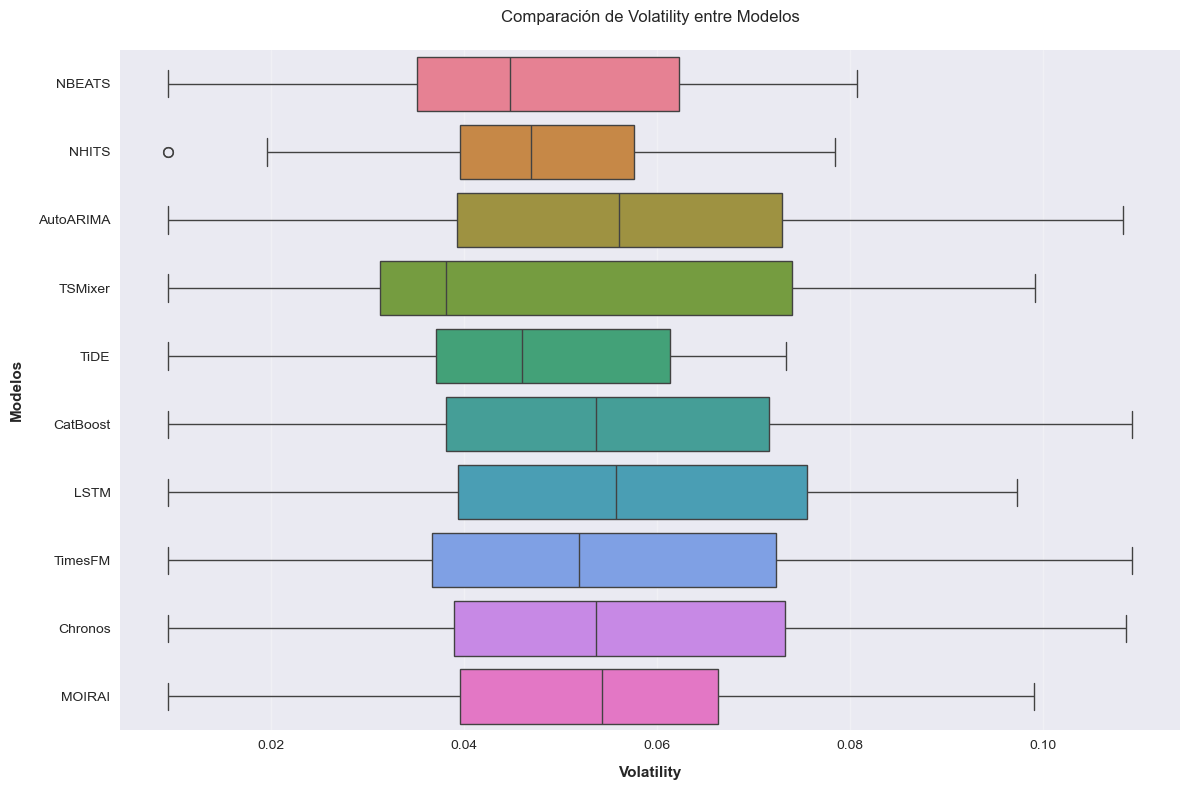


Estadísticas para Volatility:
        NBEATS    NHITS  AutoARIMA  TSMixer     TiDE  CatBoost     LSTM  \
count  60.0000  60.0000    60.0000  60.0000  60.0000   60.0000  60.0000   
mean    0.0483   0.0483     0.0589   0.0486   0.0467    0.0557   0.0578   
std     0.0180   0.0154     0.0235   0.0240   0.0165    0.0247   0.0232   
min     0.0094   0.0094     0.0094   0.0094   0.0094    0.0094   0.0094   
25%     0.0351   0.0396     0.0393   0.0313   0.0371    0.0381   0.0394   
50%     0.0448   0.0469     0.0560   0.0382   0.0460    0.0537   0.0558   
75%     0.0623   0.0576     0.0730   0.0740   0.0613    0.0716   0.0756   
max     0.0807   0.0784     0.1083   0.0992   0.0734    0.1092   0.0973   

       TimesFM  Chronos   MOIRAI  
count  60.0000  60.0000  60.0000  
mean    0.0544   0.0577   0.0542  
std     0.0271   0.0243   0.0230  
min     0.0094   0.0094   0.0094  
25%     0.0367   0.0389   0.0396  
50%     0.0519   0.0537   0.0543  
75%     0.0724   0.0733   0.0663  
max     0.109

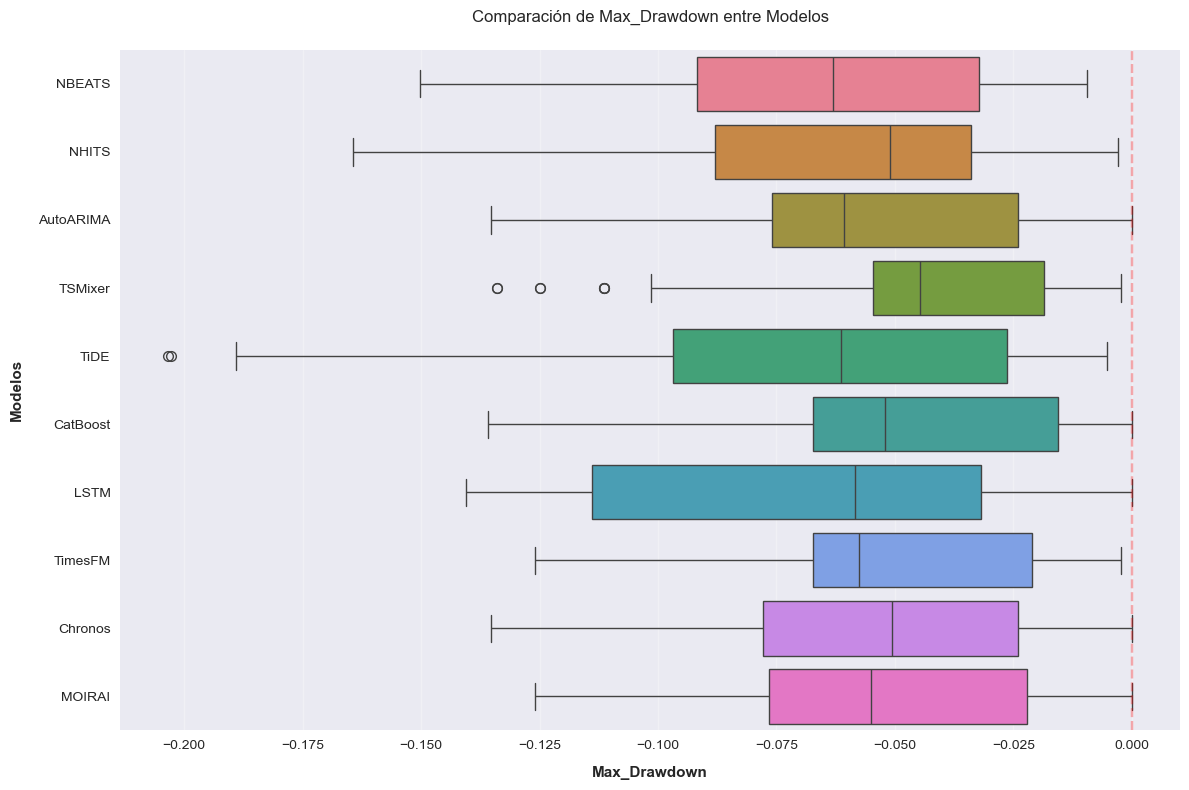


Estadísticas para Max_Drawdown:
        NBEATS    NHITS  AutoARIMA  TSMixer     TiDE  CatBoost     LSTM  \
count  60.0000  60.0000    60.0000  60.0000  60.0000   60.0000  60.0000   
mean   -0.0659  -0.0643    -0.0583  -0.0485  -0.0743   -0.0502  -0.0660   
std     0.0414   0.0455     0.0386   0.0352   0.0575    0.0367   0.0436   
min    -0.1501  -0.1644    -0.1352  -0.1340  -0.2034   -0.1359  -0.1406   
25%    -0.0917  -0.0879    -0.0760  -0.0546  -0.0967   -0.0674  -0.1139   
50%    -0.0631  -0.0509    -0.0608  -0.0448  -0.0615   -0.0522  -0.0585   
75%    -0.0322  -0.0339    -0.0240  -0.0185  -0.0263   -0.0156  -0.0318   
max    -0.0094  -0.0030     0.0000  -0.0022  -0.0052    0.0000   0.0000   

       TimesFM  Chronos   MOIRAI  
count  60.0000  60.0000  60.0000  
mean   -0.0546  -0.0526  -0.0569  
std     0.0367   0.0380   0.0390  
min    -0.1259  -0.1352  -0.1259  
25%    -0.0674  -0.0779  -0.0766  
50%    -0.0575  -0.0506  -0.0551  
75%    -0.0211  -0.0240  -0.0221  
max    -0.0

In [235]:
# Usar la función
plot_metric_comparison_boxplots(all_rolling_metrics)